# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


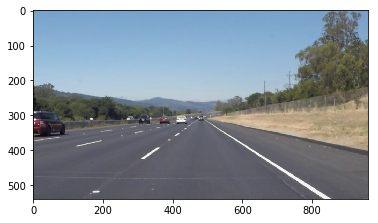

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os


def add_lines(file):
    # Read in and grayscale the image

    image = cv2.imread('test_images/' + file)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 150
    high_threshold = 180
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(imshape[1]*.5, imshape[0]*.58), (imshape[1]*.5, imshape[0]*.58), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)


    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 5     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15 #minimum number of pixels making up a line
    max_line_gap = 15  # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    #print(lines)
    # Iterate over the output "lines" and draw lines on a blank image
    #for line in lines:
        #for x1,y1,x2,y2 in line:
            #cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),1)
    slopes = [[] for i in range(2)]
    print("length of lines is ",len(lines))

    LH_horizon_xmin = imshape[1] 
    LH_horizon_ymin = imshape[0]
    RH_horizon_xmin = imshape[1]
    RH_horizon_ymin = imshape[0]

    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)

            if slope > 0: #this is the right hand lane
                slopes[0].append(slope)
                print('RH',line)
                if line[0,0]<RH_horizon_xmin:
                    RH_horizon_xmin = line[0,0]
                    RH_horizon_ymin = line[0,1]
            else: #this is the left hand lane
                slopes[1].append(slope)
                print('LH',line)
    print("RH_horizon_xmin",RH_horizon_xmin)
    print("RH_horizon_xmin",RH_horizon_ymin)
    right_lane_slope = np.mean(slopes[0])
    print('rls',right_lane_slope)
    left_lane_slope = np.mean(slopes[1])
    print('lls',left_lane_slope)
    
    #for i in slopes:
    cv2.line(line_image,(int(RH_horizon_xmin),int(RH_horizon_ymin)),(int(RH_horizon_xmin+100),int(RH_horizon_xmin*right_lane_slope)),(255,0,0),10)
    
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    #plt.imshow(color_edges)
    plt.imshow(line_image)
    print(lines)
    # Draw the lines on the image
    #lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    lines_edges = cv2.addWeighted(image, 1, line_image, 0.5, 0) 
    cv2.imwrite( "test_images_output/" + file,lines_edges)
    
    return(0)


length of lines is  17
RH [[623 386 647 400]]
RH [[534 340 877 538]]
RH [[508 326 876 538]]
LH [[293 462 353 412]]
RH [[554 348 898 538]]
LH [[280 460 344 410]]
LH [[281 460 346 410]]
LH [[436 342 457 326]]
LH [[438 344 453 334]]
LH [[311 446 352 412]]
RH [[511 328 532 340]]
LH [[437 344 452 332]]
RH [[546 344 601 375]]
LH [[436 344 456 327]]
LH [[295 460 310 447]]
RH [[823 508 876 539]]
RH [[650 407 666 409]]
RH_horizon_xmin 508
RH_horizon_xmin 326
rls 0.516746992739
lls -0.795368943387
[[[623 386 647 400]]

 [[534 340 877 538]]

 [[508 326 876 538]]

 [[293 462 353 412]]

 [[554 348 898 538]]

 [[280 460 344 410]]

 [[281 460 346 410]]

 [[436 342 457 326]]

 [[438 344 453 334]]

 [[311 446 352 412]]

 [[511 328 532 340]]

 [[437 344 452 332]]

 [[546 344 601 375]]

 [[436 344 456 327]]

 [[295 460 310 447]]

 [[823 508 876 539]]

 [[650 407 666 409]]]
length of lines is  20
RH [[609 392 831 537]]
RH [[527 335 853 539]]
RH [[506 325 596 382]]
LH [[310 422 355 392]]
LH [[321 424 363 3

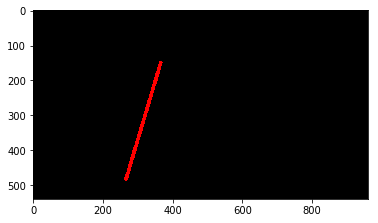

In [6]:
filelist = os.listdir("test_images/")

for i in range(len(filelist)):
    add_lines(filelist[i])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)


    # Read in and grayscale the image
    #image = mpimg.imread('test_images/' + image)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 150
    high_threshold = 180
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(imshape[1]*.5, imshape[0]*.58), (imshape[1]*.5, imshape[0]*.58), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)


    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 5     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15 #minimum number of pixels making up a line
    max_line_gap = 15  # maximum gap in pixels between connectable line segments
    hough_line_image = np.copy(image)*0 # creating a blank to draw lines on
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    #for line in lines:
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    #UNCOMMENT THESE 3 LINES BELOW TO RESET
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(hough_line_image,(x1,y1),(x2,y2),(0,255,0),1)

    slopes = [[] for i in range(2)]
    centers = [[] for i in range(2)]
    rcentersx = []
    rcentersy = []
    lcentersx = []
    lcentersy = []

    LH_horizon_xmax = 0 
    LH_horizon_ymin = imshape[0]
    RH_horizon_xmin = imshape[1]
    RH_horizon_ymin = imshape[0]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            center = [(x2+x1)/2,(y2+y1)/2]

            if (0.8 > slope > 0.5) and x1 > (0.4 * imshape[1]) and x2 > (0.4 * imshape[1]): #this is the right hand lane
                slopes[0].append(slope)
                rcentersx.append(center[0])
                rcentersy.append(center[1])
                #print('RH',line)
                if line[0,0]<RH_horizon_xmin:
                    RH_horizon_xmin = line[0,0]
                    RH_horizon_ymin = line[0,1]
            if (-0.8 < slope < -0.5 and x1 < (0.6 * imshape[1]) and x2 < (0.6 * imshape[1])): #this is the left hand lane
                slopes[1].append(slope)
                lcentersx.append(center[0])
                lcentersy.append(center[1])
                #print('LH',line)
                if line[0,2]>LH_horizon_xmax:
                    LH_horizon_xmax = line[0,2]
                    LH_horizon_ymin = line[0,3]
    right_lane_slope = np.mean(slopes[0])
    left_lane_slope = np.mean(slopes[1])
    print("rcentersx",rcentersx)
    print("rcentersy",rcentersy)
    
    right_lane_center_x = np.mean(rcentersx)
    print("right_lane_center_x",right_lane_center_x)
    right_lane_center_y = np.mean(rcentersy)
    print("right_lane_center_y",right_lane_center_y)
    left_lane_center_x = np.mean(lcentersx)
    print("left_lane_center_x",left_lane_center_x)
    left_lane_center_y = np.mean(lcentersy)
    print("left_lane_center_y",left_lane_center_y)
    
    R_horizon_y = L_horizon_y = 0.6 * imshape[0]
    print("R_horizon_y",R_horizon_y)
    R_horizon_x = -((right_lane_center_y - R_horizon_y)/right_lane_slope) + right_lane_center_x
    print("R_horizon_x",R_horizon_x)
    L_horizon_x = -((left_lane_center_y - L_horizon_y)/left_lane_slope) + left_lane_center_x
    
    #horizon_right_x
    horizon_y = imshape[1] * 0.6
    
    
    
    #print("RLC",centers[0], "rlcx",right_lane_center_x)
    left_lane_center = np.mean(centers[1])
    #print("LLC",centers[1])
    
    #cv2.line(line_image,(int(RH_horizon_xmin),int(RH_horizon_ymin)),(int(RH_horizon_xmin+500),int(RH_horizon_ymin+500*right_lane_slope)),(255,0,0),10)
    #cv2.line(line_image,(int(LH_horizon_xmax),int(LH_horizon_ymin)),(int(LH_horizon_xmax-500),int(LH_horizon_ymin-500*left_lane_slope)),(255,0,0),10)
    cv2.line(line_image,(int(R_horizon_x),int(R_horizon_y)),(int(right_lane_center_x+300),int(right_lane_center_y+300*right_lane_slope)),(255,0,0),10)
    cv2.line(line_image,(int(L_horizon_x),int(L_horizon_y)),(int(left_lane_center_x-300),int(left_lane_center_y-300*left_lane_slope)),(255,0,0),10)

    
    
    
    
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the image
    result = cv2.addWeighted(image, 1, line_image, 0.5, 0) # for image and generated lines
    #result = cv2.addWeighted(result, 1, color_edges, -0.5, 0) # for Canny Edge
    result = cv2.addWeighted(result, 1, hough_line_image, 1, 0) #for hough lines
    
    return result

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

rcentersx [710.0, 680.5, 792.0, 557.5, 561.0, 828.5, 796.0, 617.5, 712.0, 607.5, 538.5, 837.5]
rcentersy [442.0, 432.5, 492.5, 354.5, 353.0, 526.5, 506.0, 385.5, 452.0, 386.0, 343.5, 532.5]
right_lane_center_x 686.541666667
right_lane_center_y 433.875
left_lane_center_x 326.433333333
left_lane_center_y 415.366666667
R_horizon_y 324.0
R_horizon_x 507.722918687
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|                                                                                       | 0/222 [00:00<?, ?it/s]

rcentersx [710.0, 680.5, 792.0, 557.5, 561.0, 828.5, 796.0, 617.5, 712.0, 607.5, 538.5, 837.5]
rcentersy [442.0, 432.5, 492.5, 354.5, 353.0, 526.5, 506.0, 385.5, 452.0, 386.0, 343.5, 532.5]
right_lane_center_x 686.541666667
right_lane_center_y 433.875
left_lane_center_x 326.433333333
left_lane_center_y 415.366666667
R_horizon_y 324.0
R_horizon_x 507.722918687
rcentersx [762.5, 698.5, 587.0, 651.5, 785.0, 633.5, 585.5, 825.5, 809.0, 658.0, 539.0, 724.5]
rcentersy [474.5, 444.0, 373.0, 406.5, 499.5, 402.5, 367.5, 526.0, 503.5, 411.0, 343.5, 451.0]
right_lane_center_x 688.291666667
right_lane_center_y 433.541666667
left_lane_center_x 290.03125
left_lane_center_y 443.75
R_horizon_y 324.0
R_horizon_x 507.784485519


  1%|▋                                                                              | 2/222 [00:00<00:16, 13.04it/s]

rcentersx [638.5, 772.5, 663.5, 743.0, 602.5, 804.0, 577.5, 830.0, 826.5, 613.5, 565.0]
rcentersy [406.5, 480.5, 414.0, 472.5, 383.0, 511.5, 363.0, 516.0, 526.5, 384.5, 356.0]
right_lane_center_x 694.227272727
right_lane_center_y 437.636363636
left_lane_center_x 326.5
left_lane_center_y 415.25
R_horizon_y 324.0
R_horizon_x 509.709629823
rcentersx [659.0, 703.5, 611.0, 706.0, 799.0, 841.0, 776.5, 834.0, 697.0]
rcentersy [419.5, 438.0, 388.5, 440.5, 508.0, 522.5, 493.5, 531.0, 434.5]
right_lane_center_x 736.333333333
right_lane_center_y 464.0
left_lane_center_x 324.181818182
left_lane_center_y 417.5
R_horizon_y 324.0
R_horizon_x 508.93123301


  2%|█▍                                                                             | 4/222 [00:00<00:17, 12.71it/s]

rcentersx [706.0, 710.0, 613.5, 587.5, 791.5, 551.5, 707.5, 835.5, 714.0, 624.0, 690.5, 635.0, 819.5, 568.5, 669.5]
rcentersy [448.5, 442.0, 389.5, 369.5, 491.5, 351.5, 439.5, 530.5, 453.0, 396.5, 438.0, 397.5, 520.5, 357.5, 425.0]
right_lane_center_x 681.6
right_lane_center_y 430.033333333
left_lane_center_x 401.958333333
left_lane_center_y 360.333333333
R_horizon_y 324.0
R_horizon_x 509.90661272
rcentersx [709.0, 635.5, 795.5, 707.5, 811.5, 565.0, 543.0, 761.0, 726.0]
rcentersy [441.5, 404.0, 505.0, 440.0, 516.0, 354.5, 345.0, 483.0, 461.0]
right_lane_center_x 694.888888889
right_lane_center_y 438.888888889
left_lane_center_x 396.555555556
left_lane_center_y 363.888888889
R_horizon_y 324.0
R_horizon_x 507.489378719


  3%|██▏                                                                            | 6/222 [00:00<00:17, 12.27it/s]

rcentersx [710.0, 619.0, 665.0, 749.5, 824.0, 814.5, 548.5, 600.0, 566.5]
rcentersy [442.0, 393.0, 422.5, 465.0, 523.0, 516.5, 348.0, 376.5, 355.0]
right_lane_center_x 677.444444444
right_lane_center_y 426.833333333
left_lane_center_x 386.65
left_lane_center_y 371.0
R_horizon_y 324.0
R_horizon_x 510.17692136
rcentersx [685.0, 713.0, 619.0, 841.0, 748.5, 551.5, 855.0, 812.5, 715.5, 563.5]
rcentersy [434.5, 443.5, 388.0, 519.0, 475.0, 350.0, 527.0, 502.0, 454.0, 354.0]
right_lane_center_x 710.45
right_lane_center_y 444.7
left_lane_center_x 387.7
left_lane_center_y 369.7
R_horizon_y 324.0
R_horizon_x 514.400586523


  4%|██▊                                                                            | 8/222 [00:00<00:17, 12.08it/s]

rcentersx [753.0, 710.5, 718.5, 561.0, 794.0, 566.5, 668.0, 723.0, 625.5]
rcentersy [467.5, 442.5, 456.5, 357.0, 505.0, 355.5, 424.5, 449.0, 392.5]
right_lane_center_x 680.0
right_lane_center_y 427.777777778
left_lane_center_x 381.055555556
left_lane_center_y 374.666666667
R_horizon_y 324.0
R_horizon_x 510.337519535


  4%|███▏                                                                           | 9/222 [00:00<00:18, 11.36it/s]

rcentersx [720.5, 712.0, 557.5, 817.0, 555.5, 674.5, 528.0, 849.5, 541.5, 575.5, 760.0, 594.5, 659.0]
rcentersy [460.5, 446.0, 357.0, 522.0, 351.0, 431.0, 337.5, 528.0, 342.5, 363.5, 474.5, 380.5, 415.0]
right_lane_center_x 657.307692308
right_lane_center_y 416.076923077
left_lane_center_x 359.590909091
left_lane_center_y 391.409090909
R_horizon_y 324.0
R_horizon_x 504.499075666
rcentersx [718.0, 654.5, 569.0, 600.5, 544.5, 786.0, 807.0, 829.0, 515.0, 772.0, 752.0, 836.5, 816.0, 700.0]
rcentersy [452.5, 421.0, 362.0, 387.0, 346.5, 505.0, 518.5, 533.0, 332.5, 496.0, 483.5, 524.5, 524.5, 442.5]
right_lane_center_x 707.142857143
right_lane_center_y 452.071428571
left_lane_center_x 351.818181818
left_lane_center_y 400.363636364
R_horizon_y 324.0
R_horizon_x 498.848533155


  5%|███▊                                                                          | 11/222 [00:00<00:18, 11.29it/s]

rcentersx [751.0, 668.0, 663.0, 555.0, 799.0, 739.0, 635.0, 598.0, 515.0, 543.5, 542.0]
rcentersy [475.5, 432.5, 428.5, 354.0, 515.5, 467.5, 404.0, 381.0, 333.5, 346.5, 350.0]
right_lane_center_x 637.136363636
right_lane_center_y 408.045454545
left_lane_center_x 336.346153846
left_lane_center_y 410.461538462
R_horizon_y 324.0
R_horizon_x 500.372192061
rcentersx [667.0, 666.0, 560.5, 650.5, 813.0, 532.0, 839.5, 696.0, 652.5]
rcentersy [423.0, 430.5, 361.0, 414.0, 513.0, 339.5, 528.5, 451.0, 414.5]
right_lane_center_x 675.222222222
right_lane_center_y 430.555555556
left_lane_center_x 309.3
left_lane_center_y 428.433333333
R_horizon_y 324.0
R_horizon_x 506.499136027


  6%|████▌                                                                         | 13/222 [00:01<00:18, 11.40it/s]

rcentersx [619.0, 680.5, 729.0, 571.5, 809.5, 742.0, 843.5, 554.5, 684.5, 815.0]
rcentersy [398.5, 430.5, 471.0, 367.0, 510.0, 480.0, 530.5, 351.0, 434.0, 526.0]
right_lane_center_x 704.9
right_lane_center_y 449.85
left_lane_center_x 314.0
left_lane_center_y 422.607142857
R_horizon_y 324.0
R_horizon_x 508.047081068
rcentersx [696.5, 606.0, 737.5, 828.0, 575.5, 568.0, 812.0, 552.5, 820.0]
rcentersy [439.0, 388.5, 474.5, 520.0, 367.5, 358.0, 524.0, 348.0, 515.5]
right_lane_center_x 688.444444444
right_lane_center_y 437.222222222
left_lane_center_x 284.857142857
left_lane_center_y 442.0
R_horizon_y 324.0
R_horizon_x 508.758313932


  7%|█████▎                                                                        | 15/222 [00:01<00:18, 11.38it/s]

rcentersx [814.0, 660.5, 694.0, 588.0, 805.0, 671.0, 619.5, 707.0, 577.0, 536.5, 745.0, 772.0, 556.0, 798.5, 816.0, 758.0]
rcentersy [511.0, 422.5, 444.5, 374.5, 517.5, 421.5, 389.0, 444.0, 362.5, 341.0, 468.0, 485.0, 353.5, 501.0, 525.0, 487.0]
right_lane_center_x 694.875
right_lane_center_y 440.46875
left_lane_center_x 285.090909091
left_lane_center_y 440.863636364
R_horizon_y 324.0
R_horizon_x 517.307624484
rcentersx [707.0, 750.5, 592.0, 690.5, 765.5, 640.5, 552.0, 535.0, 813.0]
rcentersy [443.0, 481.0, 376.5, 441.5, 480.5, 401.0, 350.5, 340.0, 522.5]
right_lane_center_x 671.777777778
right_lane_center_y 426.277777778
left_lane_center_x 355.863636364
left_lane_center_y 388.454545455
R_horizon_y 324.0
R_horizon_x 514.289364814


  8%|█████▉                                                                        | 17/222 [00:01<00:17, 11.56it/s]

rcentersx [704.0, 704.5, 731.5, 640.5, 549.5, 796.5, 791.5, 536.0, 556.5, 587.5]
rcentersy [442.0, 442.0, 469.0, 409.0, 349.5, 501.0, 509.0, 341.0, 353.5, 374.0]
right_lane_center_x 659.8
right_lane_center_y 419.0
left_lane_center_x 394.5
left_lane_center_y 363.222222222
R_horizon_y 324.0
R_horizon_x 515.25146214
rcentersx [672.5, 699.0, 805.5, 544.5, 792.5, 572.0, 588.0, 819.0, 732.5, 525.0, 768.0, 549.0, 741.0, 751.5, 676.5, 630.0]
rcentersy [431.5, 440.0, 519.5, 347.5, 511.0, 365.0, 375.5, 528.5, 461.5, 335.5, 494.5, 347.0, 476.5, 483.5, 434.0, 403.0]
right_lane_center_x 679.15625
right_lane_center_y 434.625
left_lane_center_x 395.3
left_lane_center_y 364.35
R_horizon_y 324.0
R_horizon_x 504.791502168


  9%|██████▋                                                                       | 19/222 [00:01<00:17, 11.68it/s]

rcentersx [693.5, 660.0, 787.5, 581.0, 698.0, 842.5, 702.5, 768.0, 549.5, 652.0, 811.0]
rcentersy [438.0, 424.5, 509.0, 372.0, 440.0, 531.5, 444.0, 495.5, 348.5, 418.5, 523.5]
right_lane_center_x 704.136363636
right_lane_center_y 449.545454545
left_lane_center_x 382.954545455
left_lane_center_y 374.727272727
R_horizon_y 324.0
R_horizon_x 506.772168466
rcentersx [720.0, 691.0, 533.0, 551.5, 803.0, 585.5, 822.0, 651.0, 543.5, 700.5, 593.0, 518.5]
rcentersy [464.5, 437.0, 342.5, 354.0, 519.5, 376.0, 532.5, 419.0, 345.5, 443.5, 380.5, 333.5]
right_lane_center_x 642.708333333
right_lane_center_y 412.333333333
left_lane_center_x 376.75
left_lane_center_y 380.0
R_horizon_y 324.0
R_horizon_x 506.994872206


  9%|███████▍                                                                      | 21/222 [00:01<00:16, 11.86it/s]

rcentersx [689.5, 613.0, 733.0, 795.5, 843.0, 526.0, 825.5]
rcentersy [436.5, 394.5, 473.0, 515.0, 531.0, 338.5, 520.5]
right_lane_center_x 717.928571429
right_lane_center_y 458.428571429
left_lane_center_x 351.5
left_lane_center_y 398.3125
R_horizon_y 324.0
R_horizon_x 509.201280467
rcentersx [756.0, 667.5, 691.0, 582.5, 802.0, 550.0, 725.5, 592.5]
rcentersy [488.5, 430.0, 437.0, 373.5, 505.5, 349.5, 459.0, 380.5]
right_lane_center_x 670.875
right_lane_center_y 427.9375
left_lane_center_x 343.65
left_lane_center_y 404.05
R_horizon_y 324.0
R_horizon_x 507.919471458


 10%|████████                                                                      | 23/222 [00:01<00:16, 11.74it/s]

rcentersx [693.5, 765.0, 604.5, 695.0, 729.5, 580.5, 745.0]
rcentersy [438.5, 494.5, 388.0, 438.5, 470.0, 371.5, 471.0]
right_lane_center_x 687.571428571
right_lane_center_y 438.857142857
left_lane_center_x 314.777777778
left_lane_center_y 424.055555556
R_horizon_y 324.0
R_horizon_x 508.526846452
rcentersx [695.0, 651.0, 823.0, 606.0, 784.0, 766.5, 800.0, 814.0, 750.5, 652.5, 714.0, 734.5]
rcentersy [439.0, 418.5, 531.5, 388.5, 506.0, 494.5, 516.5, 525.5, 484.0, 411.5, 460.0, 473.5]
right_lane_center_x 732.583333333
right_lane_center_y 470.75
left_lane_center_x 296.75
left_lane_center_y 436.0
R_horizon_y 324.0
R_horizon_x 496.259731745


 11%|████████▊                                                                     | 25/222 [00:02<00:17, 11.39it/s]

rcentersx [633.5, 695.0, 748.0, 795.0, 594.5, 811.0]
rcentersy [406.5, 438.5, 482.0, 514.0, 380.5, 512.0]
right_lane_center_x 712.833333333
right_lane_center_y 455.583333333
left_lane_center_x 281.708333333
left_lane_center_y 446.458333333
R_horizon_y 324.0
R_horizon_x 508.896461484
rcentersx [694.5, 645.5, 738.0, 597.5, 695.5, 787.0, 567.0]
rcentersy [438.5, 414.5, 475.5, 382.5, 438.5, 508.0, 359.5]
right_lane_center_x 675.0
right_lane_center_y 431.0
left_lane_center_x 306.375
left_lane_center_y 430.083333333
R_horizon_y 324.0
R_horizon_x 507.952763769


 12%|█████████▍                                                                    | 27/222 [00:02<00:17, 11.34it/s]

rcentersx [658.5, 695.5, 748.0, 602.0, 562.5, 795.0, 702.5]
rcentersy [423.0, 438.5, 482.0, 385.5, 356.5, 513.5, 444.0]
right_lane_center_x 680.571428571
right_lane_center_y 434.714285714
left_lane_center_x 320.961538462
left_lane_center_y 419.538461538
R_horizon_y 324.0
R_horizon_x 508.067535527
rcentersx [629.5, 695.0, 686.5, 774.0, 588.5, 732.5, 527.0]
rcentersy [404.0, 439.0, 442.0, 499.5, 373.0, 461.5, 336.5]
right_lane_center_x 661.857142857
right_lane_center_y 422.214285714
left_lane_center_x 354.727272727
left_lane_center_y 393.590909091
R_horizon_y 324.0
R_horizon_x 508.336962936


 13%|██████████▏                                                                   | 29/222 [00:02<00:17, 11.30it/s]

rcentersx [696.0, 684.0, 610.5, 738.0, 760.5, 566.0, 618.0, 822.5]
rcentersy [439.0, 439.5, 391.0, 464.0, 490.0, 358.5, 390.5, 531.0]
right_lane_center_x 686.9375
right_lane_center_y 437.9375
left_lane_center_x 389.8125
left_lane_center_y 369.375
R_horizon_y 324.0
R_horizon_x 508.752420526
rcentersx [698.5, 690.0, 626.0, 745.5, 776.5, 549.5]
rcentersy [440.0, 443.0, 400.5, 468.5, 500.0, 346.5]
right_lane_center_x 681.0
right_lane_center_y 433.083333333
left_lane_center_x 400.590909091
left_lane_center_y 361.136363636
R_horizon_y 324.0
R_horizon_x 508.788654117


 14%|██████████▉                                                                   | 31/222 [00:02<00:16, 11.37it/s]

rcentersx [682.5, 637.0, 700.0, 828.5, 847.0, 533.0, 810.0, 776.5, 663.0, 595.5]
rcentersy [437.5, 401.5, 440.5, 533.5, 531.0, 339.5, 521.5, 499.5, 425.5, 376.5]
right_lane_center_x 707.3
right_lane_center_y 450.65
left_lane_center_x 390.9
left_lane_center_y 368.45
R_horizon_y 324.0
R_horizon_x 505.871834494
rcentersx [678.0, 700.0, 698.5, 774.5, 619.5, 560.5, 827.0]
rcentersy [434.5, 440.5, 448.5, 486.0, 391.0, 357.5, 533.0]
right_lane_center_x 694.0
right_lane_center_y 441.571428571
left_lane_center_x 382.166666667
left_lane_center_y 374.333333333
R_horizon_y 324.0
R_horizon_x 510.84244683


 15%|███████████▌                                                                  | 33/222 [00:02<00:15, 12.19it/s]

rcentersx [694.5, 699.0, 632.5, 676.5, 533.5, 791.5, 840.5]
rcentersy [446.0, 440.0, 405.0, 426.5, 339.5, 510.0, 527.5]
right_lane_center_x 695.428571429
right_lane_center_y 442.071428571
left_lane_center_x 340.214285714
left_lane_center_y 404.428571429
R_horizon_y 324.0
R_horizon_x 511.124190827
rcentersx [680.5, 698.0, 679.0, 766.5, 535.0, 793.5, 530.5, 546.5]
rcentersy [430.0, 449.5, 436.5, 483.0, 340.0, 512.5, 338.5, 349.5]
right_lane_center_x 653.6875
right_lane_center_y 417.4375
left_lane_center_x 334.1
left_lane_center_y 410.0
R_horizon_y 324.0
R_horizon_x 505.450309001


 16%|████████████▎                                                                 | 35/222 [00:02<00:14, 12.91it/s]

rcentersx [763.0, 577.5, 684.0, 718.0, 682.0, 636.0, 540.5, 724.0, 653.0, 593.0, 604.0, 847.0]
rcentersy [481.5, 366.0, 440.5, 464.0, 432.0, 403.5, 346.5, 458.0, 414.0, 381.5, 383.5, 533.0]
right_lane_center_x 668.5
right_lane_center_y 425.333333333
left_lane_center_x 331.636363636
left_lane_center_y 412.818181818
R_horizon_y 324.0
R_horizon_x 513.275971708
rcentersx [712.5, 692.5, 695.5, 762.5, 554.0, 665.5, 530.0, 835.0, 568.5, 551.5]
rcentersy [460.5, 446.5, 440.0, 481.5, 355.5, 422.5, 339.5, 526.0, 360.5, 349.5]
right_lane_center_x 656.75
right_lane_center_y 418.2
left_lane_center_x 295.590909091
left_lane_center_y 437.590909091
R_horizon_y 324.0
R_horizon_x 507.08795489


 17%|█████████████                                                                 | 37/222 [00:03<00:13, 13.53it/s]

rcentersx [707.0, 575.5, 703.0, 743.0, 526.5, 533.0, 840.5, 551.5, 595.5, 631.5]
rcentersy [456.0, 369.5, 444.5, 480.5, 336.0, 341.0, 529.5, 349.0, 383.0, 406.5]
right_lane_center_x 640.7
right_lane_center_y 409.55
left_lane_center_x 297.382352941
left_lane_center_y 437.852941176
R_horizon_y 324.0
R_horizon_x 505.955469859
rcentersx [706.0, 600.0, 686.5, 704.5, 813.0, 570.5, 795.0, 756.0, 769.0, 578.5, 539.0, 718.5, 814.5, 844.5]
rcentersy [445.5, 385.5, 442.5, 445.5, 525.5, 360.5, 513.5, 488.0, 496.5, 371.5, 343.5, 463.5, 526.0, 531.5]
right_lane_center_x 706.821428571
right_lane_center_y 452.785714286
left_lane_center_x 343.772727273
left_lane_center_y 402.636363636
R_horizon_y 324.0
R_horizon_x 501.500937068


 18%|█████████████▋                                                                | 39/222 [00:03<00:12, 14.15it/s]

rcentersx [723.5, 701.5, 559.0, 761.5, 622.0, 727.0, 554.0, 542.5, 564.5, 716.0]
rcentersy [466.0, 442.0, 357.0, 491.5, 399.0, 459.5, 349.0, 345.5, 356.0, 452.0]
right_lane_center_x 647.15
right_lane_center_y 411.75
left_lane_center_x 284.033333333
left_lane_center_y 444.2
R_horizon_y 324.0
R_horizon_x 509.130466615
rcentersx [744.5, 712.0, 729.0, 564.5, 781.5, 600.0, 567.5, 658.0, 542.5, 582.5]
rcentersy [470.0, 448.5, 469.5, 360.0, 504.5, 384.0, 357.5, 422.5, 345.0, 372.0]
right_lane_center_x 648.2
right_lane_center_y 413.35
left_lane_center_x 371.277777778
left_lane_center_y 380.611111111
R_horizon_y 324.0
R_horizon_x 515.236434156


 18%|██████████████▍                                                               | 41/222 [00:03<00:12, 14.65it/s]

rcentersx [715.0, 724.5, 616.0, 555.0, 800.5, 586.5, 559.5, 719.0, 773.0, 829.5, 810.5, 669.5, 571.0, 557.0]
rcentersy [460.5, 457.0, 394.5, 353.5, 517.5, 369.5, 352.0, 453.0, 499.0, 523.5, 523.5, 430.0, 359.5, 355.0]
right_lane_center_x 677.607142857
right_lane_center_y 432.0
left_lane_center_x 399.5
left_lane_center_y 361.045454545
R_horizon_y 324.0
R_horizon_x 507.448632811
rcentersx [748.0, 645.5, 717.0, 794.5, 565.0, 589.5, 556.0, 558.5, 742.5, 576.5]
rcentersy [472.5, 414.5, 452.0, 513.0, 355.5, 371.5, 349.5, 355.0, 479.0, 363.0]
right_lane_center_x 649.3
right_lane_center_y 412.55
left_lane_center_x 392.0
left_lane_center_y 366.357142857
R_horizon_y 324.0
R_horizon_x 509.403209958


 19%|███████████████                                                               | 43/222 [00:03<00:12, 14.78it/s]

rcentersx [665.0, 641.5, 775.5, 802.5, 627.5, 602.5, 723.5, 840.5, 821.0, 755.0, 834.0, 824.0]
rcentersy [427.0, 404.0, 489.0, 518.5, 402.5, 380.0, 456.5, 529.0, 517.5, 476.5, 525.5, 532.0]
right_lane_center_x 742.708333333
right_lane_center_y 471.5
left_lane_center_x 377.611111111
left_lane_center_y 376.055555556
R_horizon_y 324.0
R_horizon_x 517.868908134
rcentersx [680.0, 723.0, 583.5, 814.0, 745.0, 567.0, 735.0, 547.0, 822.5, 637.5, 786.0]
rcentersy [437.5, 456.0, 367.5, 526.0, 470.5, 356.5, 474.5, 348.5, 532.5, 409.5, 508.0]
right_lane_center_x 694.590909091
right_lane_center_y 444.272727273
left_lane_center_x 375.055555556
left_lane_center_y 376.611111111
R_horizon_y 324.0
R_horizon_x 509.878799433


 20%|███████████████▊                                                              | 45/222 [00:03<00:12, 14.68it/s]

rcentersx [682.5, 709.0, 648.5, 764.0, 588.0, 794.5, 822.5, 738.0]
rcentersy [438.5, 446.5, 416.5, 482.5, 370.0, 513.0, 531.0, 465.5]
right_lane_center_x 718.375
right_lane_center_y 457.9375
left_lane_center_x 358.785714286
left_lane_center_y 388.357142857
R_horizon_y 324.0
R_horizon_x 511.817800065
rcentersx [654.5, 765.5, 729.5, 597.0, 820.0, 573.0, 756.0, 557.5, 621.0]
rcentersy [420.0, 493.5, 459.5, 375.5, 529.5, 359.5, 477.0, 354.5, 391.0]
right_lane_center_x 674.888888889
right_lane_center_y 428.888888889
left_lane_center_x 335.6875
left_lane_center_y 405.75
R_horizon_y 324.0
R_horizon_x 511.507740488


 21%|████████████████▌                                                             | 47/222 [00:03<00:11, 14.68it/s]

rcentersx [549.5, 710.0, 699.0, 577.0, 758.0, 640.5, 794.0, 622.0, 604.5, 811.0, 558.5, 595.5, 711.0, 836.0, 542.5, 762.0, 746.0, 668.0]
rcentersy [350.0, 447.5, 450.0, 363.0, 489.5, 411.0, 501.0, 398.5, 386.5, 525.0, 351.0, 375.0, 449.0, 527.5, 344.5, 481.0, 471.0, 429.5]
right_lane_center_x 676.944444444
right_lane_center_y 430.583333333
left_lane_center_x 306.444444444
left_lane_center_y 426.111111111
R_horizon_y 324.0
R_horizon_x 508.922983478
rcentersx [739.5, 662.5, 627.0, 582.5, 541.5, 815.5, 776.5, 799.5, 757.5, 661.5]
rcentersy [466.5, 426.0, 395.5, 367.0, 345.0, 528.0, 491.0, 517.0, 489.5, 426.0]
right_lane_center_x 696.35
right_lane_center_y 445.15
left_lane_center_x 322.535714286
left_lane_center_y 415.75
R_horizon_y 324.0
R_horizon_x 506.319052204


 22%|█████████████████▏                                                            | 49/222 [00:03<00:12, 14.36it/s]

rcentersx [678.5, 716.5, 598.0, 536.0, 830.5, 774.5, 578.5, 795.5, 817.5, 566.0, 553.5, 812.0, 819.5, 685.5, 843.5, 763.5, 689.5]
rcentersy [437.0, 452.0, 377.0, 342.0, 524.5, 489.5, 364.5, 502.5, 529.5, 356.5, 348.5, 513.0, 517.5, 441.0, 532.5, 482.5, 435.5]
right_lane_center_x 709.323529412
right_lane_center_y 449.735294118
left_lane_center_x 283.636363636
left_lane_center_y 444.227272727
R_horizon_y 324.0
R_horizon_x 519.309726189
rcentersx [674.5, 617.0, 718.0, 531.0, 793.5, 781.0, 559.5]
rcentersy [434.0, 389.0, 453.0, 338.5, 513.0, 493.5, 352.0]
right_lane_center_x 667.785714286
right_lane_center_y 424.714285714
left_lane_center_x 337.866666667
left_lane_center_y 403.933333333
R_horizon_y 324.0
R_horizon_x 509.424286892


 23%|█████████████████▉                                                            | 51/222 [00:04<00:12, 14.08it/s]

rcentersx [619.0, 635.0, 707.0, 784.5, 811.5, 549.5, 701.5, 589.0, 802.0, 734.5, 659.5, 750.0, 780.0, 844.5, 759.5, 578.0]
rcentersy [396.5, 400.5, 455.5, 507.5, 512.0, 350.5, 442.5, 371.5, 506.5, 474.0, 423.5, 473.0, 492.5, 532.5, 490.5, 369.0]
right_lane_center_x 706.5625
right_lane_center_y 449.875
left_lane_center_x 315.884615385
left_lane_center_y 418.153846154
R_horizon_y 324.0
R_horizon_x 512.344384202
rcentersx [771.5, 694.5, 672.0, 614.0, 570.5, 793.0, 713.5, 691.5, 645.0, 560.5, 793.0]
rcentersy [487.0, 447.0, 432.5, 387.0, 365.0, 512.5, 450.0, 436.5, 407.0, 352.5, 500.5]
right_lane_center_x 683.545454545
right_lane_center_y 434.318181818
left_lane_center_x 326.678571429
left_lane_center_y 409.964285714
R_horizon_y 324.0
R_horizon_x 511.992867892


 24%|██████████████████▌                                                           | 53/222 [00:04<00:12, 13.55it/s]

rcentersx [679.5, 740.0, 640.5, 586.5, 573.5, 824.0, 548.5, 839.0, 790.5, 527.0, 627.0, 710.0]
rcentersy [437.5, 467.0, 404.0, 370.5, 367.0, 520.5, 346.5, 529.5, 511.0, 336.5, 396.0, 448.5]
right_lane_center_x 673.833333333
right_lane_center_y 427.875
left_lane_center_x 392.833333333
left_lane_center_y 363.277777778
R_horizon_y 324.0
R_horizon_x 515.86219277
rcentersx [600.5, 791.5, 598.5, 679.5, 777.0, 616.5, 677.5, 693.5, 545.5, 557.0, 707.0, 726.0, 814.5, 558.0, 742.0, 739.5, 758.5]
rcentersy [385.0, 500.0, 378.0, 437.5, 502.5, 389.0, 427.5, 437.5, 345.0, 355.5, 446.0, 458.0, 528.0, 352.5, 479.0, 466.5, 478.5]
right_lane_center_x 681.323529412
right_lane_center_y 433.294117647
left_lane_center_x 390.35
left_lane_center_y 365.0
R_horizon_y 324.0
R_horizon_x 515.241673306


 25%|███████████████████▎                                                          | 55/222 [00:04<00:16, 10.38it/s]

rcentersx [725.0, 697.5, 591.0, 763.0, 561.0, 616.0, 574.5, 522.0, 721.5]
rcentersy [458.5, 450.0, 374.0, 493.0, 355.0, 396.0, 369.0, 335.0, 456.0]
right_lane_center_x 641.277777778
right_lane_center_y 409.611111111
left_lane_center_x 380.3
left_lane_center_y 373.0
R_horizon_y 324.0
R_horizon_x 508.105904938
rcentersx [688.5, 728.5, 731.0, 609.0, 568.0, 793.0, 577.5]
rcentersy [436.0, 461.5, 473.0, 392.5, 365.0, 514.5, 366.0]
right_lane_center_x 670.785714286
right_lane_center_y 429.785714286
left_lane_center_x 345.75
left_lane_center_y 395.916666667
R_horizon_y 324.0
R_horizon_x 505.503610762


 26%|████████████████████                                                          | 57/222 [00:04<00:15, 10.60it/s]

rcentersx [581.0, 530.0, 683.5, 744.5, 590.0, 659.0, 744.5, 628.0, 555.5, 805.5, 645.5, 587.5, 843.0, 721.0]
rcentersy [369.0, 341.0, 434.0, 483.0, 380.5, 426.5, 473.0, 405.5, 358.0, 524.0, 417.5, 373.5, 533.0, 467.5]
right_lane_center_x 665.607142857
right_lane_center_y 427.571428571
left_lane_center_x 364.05
left_lane_center_y 385.1
R_horizon_y 324.0
R_horizon_x 502.101984993
rcentersx [587.5, 690.0, 636.5, 683.5, 748.0, 523.5, 512.0, 790.5, 545.0]
rcentersy [373.5, 447.0, 412.0, 434.0, 475.5, 337.0, 330.0, 513.5, 351.0]
right_lane_center_x 635.166666667
right_lane_center_y 408.166666667
left_lane_center_x 348.111111111
left_lane_center_y 396.944444444
R_horizon_y 324.0
R_horizon_x 508.068170687


 27%|████████████████████▋                                                         | 59/222 [00:05<00:18,  8.67it/s]

rcentersx [744.5, 561.0, 624.5, 597.5, 765.5, 695.5, 521.5, 785.0, 837.5, 675.0, 800.5, 744.5, 773.0, 593.5, 731.0, 618.5, 538.0]
rcentersy [473.0, 361.0, 403.5, 380.0, 498.0, 451.5, 336.0, 512.0, 532.5, 437.5, 509.0, 474.0, 492.0, 382.5, 475.0, 393.5, 346.5]
right_lane_center_x 682.735294118
right_lane_center_y 438.676470588
left_lane_center_x 317.4375
left_lane_center_y 415.9375
R_horizon_y 324.0
R_horizon_x 505.685129244
rcentersx [717.5, 665.0, 601.0, 689.5, 558.0, 513.5, 816.0, 538.5, 667.0, 816.5]
rcentersy [457.0, 432.0, 383.0, 447.5, 356.0, 331.0, 519.5, 347.5, 425.0, 520.5]
right_lane_center_x 658.25
right_lane_center_y 421.9
left_lane_center_x 311.0
left_lane_center_y 422.25
R_horizon_y 324.0
R_horizon_x 509.861297937


 27%|█████████████████████▍                                                        | 61/222 [00:05<00:17,  9.46it/s]

rcentersx [682.5, 732.0, 544.0, 557.0, 597.5, 815.5, 615.0, 512.5, 658.5, 628.5, 555.0, 738.0]
rcentersy [443.5, 466.5, 346.5, 359.5, 380.5, 519.5, 391.5, 330.5, 426.5, 400.0, 353.5, 481.5]
right_lane_center_x 636.333333333
right_lane_center_y 408.291666667
left_lane_center_x 320.633333333
left_lane_center_y 414.366666667
R_horizon_y 324.0
R_horizon_x 509.626007307
rcentersx [730.0, 687.0, 569.5, 577.0, 524.5, 820.0, 659.0, 612.0, 832.5, 529.0, 802.0, 549.0, 635.0]
rcentersy [465.5, 446.5, 368.0, 368.0, 339.0, 523.0, 427.0, 390.0, 530.5, 341.5, 525.0, 350.5, 404.5]
right_lane_center_x 655.884615385
right_lane_center_y 421.461538462
left_lane_center_x 315.294117647
left_lane_center_y 418.823529412
R_horizon_y 324.0
R_horizon_x 508.525475849


 28%|██████████████████████▏                                                       | 63/222 [00:05<00:15, 10.13it/s]

rcentersx [678.0, 616.0, 684.0, 559.5, 590.5, 824.0, 803.0, 777.5, 527.0, 809.5, 629.5, 761.0]
rcentersy [441.0, 393.0, 436.5, 362.0, 376.5, 525.5, 512.5, 496.5, 336.0, 530.5, 408.0, 486.0]
right_lane_center_x 688.291666667
right_lane_center_y 442.0
left_lane_center_x 284.714285714
left_lane_center_y 439.107142857
R_horizon_y 324.0
R_horizon_x 505.874813793
rcentersx [660.5, 741.0, 677.5, 593.5, 765.0, 549.5, 518.0, 680.0, 626.0]
rcentersy [430.5, 473.5, 441.0, 379.0, 488.0, 351.5, 335.0, 434.0, 399.5]
right_lane_center_x 645.666666667
right_lane_center_y 414.666666667
left_lane_center_x 401.133333333
left_lane_center_y 359.266666667
R_horizon_y 324.0
R_horizon_x 508.121221853


 29%|██████████████████████▊                                                       | 65/222 [00:05<00:17,  9.07it/s]

rcentersx [760.0, 661.5, 687.0, 589.0, 634.5, 532.5, 542.5, 780.5, 800.5]
rcentersy [485.0, 430.5, 447.0, 376.5, 405.0, 344.5, 347.0, 497.5, 525.0]
right_lane_center_x 665.333333333
right_lane_center_y 428.666666667
left_lane_center_x 401.111111111
left_lane_center_y 358.611111111
R_horizon_y 324.0
R_horizon_x 506.83490379


 30%|███████████████████████▏                                                      | 66/222 [00:05<00:20,  7.68it/s]

rcentersx [665.5, 772.0, 680.0, 620.5, 553.5, 539.0, 706.0, 837.5, 784.5]
rcentersy [432.0, 491.5, 441.0, 395.0, 352.5, 347.5, 449.5, 533.0, 499.0]
right_lane_center_x 684.277777778
right_lane_center_y 437.888888889
left_lane_center_x 383.75
left_lane_center_y 368.75
R_horizon_y 324.0
R_horizon_x 511.818638672
rcentersx [680.0, 667.0, 545.0, 560.5, 795.0, 831.0, 825.5, 748.0, 654.0, 804.5, 766.5, 582.5, 781.5, 730.0, 811.5]
rcentersy [441.0, 424.5, 351.0, 357.0, 505.5, 528.0, 525.0, 476.0, 424.0, 511.5, 487.5, 370.5, 497.0, 464.5, 530.0]
right_lane_center_x 718.833333333
right_lane_center_y 459.533333333
left_lane_center_x 378.625
left_lane_center_y 372.1875
R_horizon_y 324.0
R_horizon_x 518.101113302


 31%|███████████████████████▉                                                      | 68/222 [00:05<00:17,  8.72it/s]

rcentersx [559.0, 753.5, 666.0, 618.5, 547.5, 611.0, 681.0, 650.0, 583.5, 790.5, 529.5, 557.0, 624.5]
rcentersy [356.0, 480.0, 432.5, 394.0, 353.5, 394.5, 433.5, 422.0, 371.5, 515.5, 337.0, 355.0, 397.0]
right_lane_center_x 628.576923077
right_lane_center_y 403.230769231
left_lane_center_x 357.0
left_lane_center_y 387.166666667
R_horizon_y 324.0
R_horizon_x 508.032171252
rcentersx [664.0, 646.5, 770.5, 565.0, 665.0, 837.0, 707.0]
rcentersy [432.0, 412.5, 491.5, 360.5, 432.0, 533.0, 451.0]
right_lane_center_x 693.571428571
right_lane_center_y 444.642857143
left_lane_center_x 345.4375
left_lane_center_y 394.75
R_horizon_y 324.0
R_horizon_x 508.557028039


 32%|████████████████████████▌                                                     | 70/222 [00:06<00:15,  9.68it/s]

rcentersx [665.0, 576.5, 739.0, 666.0, 794.0, 641.0, 617.5, 617.0, 832.5, 727.5, 700.0, 560.5, 724.0]
rcentersy [432.0, 367.5, 471.0, 424.5, 520.0, 408.5, 393.5, 399.0, 530.5, 464.5, 446.5, 357.0, 472.5]
right_lane_center_x 681.576923077
right_lane_center_y 437.461538462
left_lane_center_x 337.85
left_lane_center_y 400.25
R_horizon_y 324.0
R_horizon_x 510.394696173
rcentersx [662.0, 666.0, 739.0, 736.0, 642.5, 572.5, 831.0, 531.5, 819.5]
rcentersy [422.0, 432.5, 482.5, 469.0, 416.0, 365.0, 529.5, 342.5, 522.5]
right_lane_center_x 688.888888889
right_lane_center_y 442.388888889
left_lane_center_x 304.55
left_lane_center_y 422.25
R_horizon_y 324.0
R_horizon_x 509.937223756


 32%|█████████████████████████▎                                                    | 72/222 [00:06<00:14, 10.44it/s]

rcentersx [736.5, 665.0, 558.0, 629.5, 591.0, 766.5, 812.0, 626.5, 536.0, 756.5]
rcentersy [470.5, 432.5, 356.0, 401.5, 377.0, 502.0, 518.0, 406.0, 342.0, 482.5]
right_lane_center_x 667.75
right_lane_center_y 428.8
left_lane_center_x 301.409090909
left_lane_center_y 424.909090909
R_horizon_y 324.0
R_horizon_x 509.762454616
rcentersx [634.0, 753.5, 762.0, 679.5, 588.0, 803.5, 584.5, 527.5, 760.5, 652.0, 802.5, 603.5, 547.0, 605.0, 702.0, 646.0]
rcentersy [411.5, 481.5, 499.5, 434.0, 376.0, 513.0, 379.0, 340.5, 497.5, 424.5, 526.0, 385.5, 349.0, 393.0, 458.0, 413.0]
right_lane_center_x 665.6875
right_lane_center_y 430.09375
left_lane_center_x 302.7
left_lane_center_y 424.266666667
R_horizon_y 324.0
R_horizon_x 505.547367619


 33%|██████████████████████████                                                    | 74/222 [00:06<00:15,  9.49it/s]

rcentersx [667.0, 606.0, 729.0, 781.5, 795.0, 536.0, 688.0, 549.5]
rcentersy [434.5, 387.5, 466.5, 499.0, 522.0, 341.5, 449.5, 354.5]
right_lane_center_x 669.0
right_lane_center_y 431.875
left_lane_center_x 305.7
left_lane_center_y 421.533333333
R_horizon_y 324.0
R_horizon_x 505.255019379
rcentersx [638.0, 695.0, 683.0, 542.5, 790.0, 793.5, 581.5, 531.0, 651.5]
rcentersy [408.0, 454.0, 436.5, 349.5, 505.0, 521.5, 376.5, 342.0, 424.0]
right_lane_center_x 656.222222222
right_lane_center_y 424.111111111
left_lane_center_x 310.1
left_lane_center_y 417.85
R_horizon_y 324.0
R_horizon_x 507.388316457


 34%|██████████████████████████▋                                                   | 76/222 [00:06<00:14, 10.36it/s]

rcentersx [683.0, 733.5, 593.0, 558.0, 715.5, 667.0, 829.5, 806.5, 537.5]
rcentersy [437.0, 481.0, 384.5, 360.0, 468.5, 427.5, 531.0, 516.5, 342.0]
right_lane_center_x 680.388888889
right_lane_center_y 438.666666667
left_lane_center_x 293.666666667
left_lane_center_y 427.7
R_horizon_y 324.0
R_horizon_x 507.402359711
rcentersx [534.5, 644.0, 760.0, 689.0, 535.0, 795.5, 787.5, 526.5, 691.0, 559.0, 798.0, 736.0, 807.5, 553.0, 598.5, 690.0]
rcentersy [341.0, 420.0, 499.5, 441.5, 344.5, 510.0, 518.0, 339.0, 443.5, 361.5, 525.0, 483.0, 531.5, 352.5, 389.0, 451.5]
right_lane_center_x 669.0625
right_lane_center_y 434.4375
left_lane_center_x 391.3
left_lane_center_y 361.9
R_horizon_y 324.0
R_horizon_x 504.281113883


 35%|███████████████████████████▍                                                  | 78/222 [00:06<00:12, 11.08it/s]

rcentersx [685.5, 730.0, 731.5, 539.5, 668.0, 619.5, 767.5, 572.0, 539.0, 522.5, 529.0]
rcentersy [440.0, 480.0, 471.0, 348.5, 437.5, 404.0, 506.5, 371.0, 344.0, 337.0, 337.0]
right_lane_center_x 627.636363636
right_lane_center_y 406.954545455
left_lane_center_x 381.916666667
left_lane_center_y 368.916666667
R_horizon_y 324.0
R_horizon_x 505.266969025
rcentersx [612.0, 692.0, 660.5, 594.5, 767.0, 543.5]
rcentersy [399.0, 445.0, 432.5, 380.5, 505.5, 352.0]
right_lane_center_x 644.916666667
right_lane_center_y 419.083333333
left_lane_center_x 367.333333333
left_lane_center_y 377.888888889
R_horizon_y 324.0
R_horizon_x 505.51703762


 36%|████████████████████████████                                                  | 80/222 [00:07<00:13, 10.69it/s]

rcentersx [755.5, 661.5, 647.5, 763.5, 633.0, 540.0, 822.0, 778.5, 556.0, 712.5]
rcentersy [487.0, 433.0, 415.5, 503.5, 413.5, 344.5, 529.5, 501.5, 360.5, 458.5]
right_lane_center_x 687.0
right_lane_center_y 444.7
left_lane_center_x 358.833333333
left_lane_center_y 384.0
R_horizon_y 324.0
R_horizon_x 508.121918236
rcentersx [660.0, 623.5, 661.0, 797.5, 563.0, 711.5, 721.5, 740.5, 530.5, 531.0, 769.5, 701.0, 584.5]
rcentersy [432.5, 400.0, 432.5, 514.5, 365.5, 458.5, 465.0, 477.5, 339.0, 338.0, 496.5, 451.5, 374.0]
right_lane_center_x 661.153846154
right_lane_center_y 426.538461538
left_lane_center_x 336.3125
left_lane_center_y 397.625
R_horizon_y 324.0
R_horizon_x 510.520728786


 37%|████████████████████████████▊                                                 | 82/222 [00:07<00:12, 11.32it/s]

rcentersx [665.0, 711.0, 661.0, 634.5, 532.5, 586.0, 774.5, 537.0]
rcentersy [436.5, 458.0, 432.5, 407.5, 339.0, 375.0, 500.0, 342.5]
right_lane_center_x 637.6875
right_lane_center_y 411.375
left_lane_center_x 319.916666667
left_lane_center_y 410.166666667
R_horizon_y 324.0
R_horizon_x 505.613788244
rcentersx [666.5, 650.5, 660.0, 800.0, 556.0, 767.0, 536.5, 820.5, 736.5, 781.0, 816.0, 695.5]
rcentersy [437.5, 418.0, 432.0, 517.0, 355.0, 495.0, 341.5, 530.0, 475.0, 504.5, 527.5, 448.0]
right_lane_center_x 707.166666667
right_lane_center_y 456.75
left_lane_center_x 309.681818182
left_lane_center_y 415.954545455
R_horizon_y 324.0
R_horizon_x 514.193724678


 38%|█████████████████████████████▌                                                | 84/222 [00:07<00:11, 11.70it/s]

rcentersx [659.5, 782.5, 622.5, 674.0, 746.0, 553.0, 595.0, 818.5]
rcentersy [432.0, 505.0, 399.5, 443.5, 481.5, 354.0, 382.0, 528.5]
right_lane_center_x 681.375
right_lane_center_y 440.75
left_lane_center_x 314.230769231
left_lane_center_y 414.423076923
R_horizon_y 324.0
R_horizon_x 510.410985049
rcentersx [583.0, 664.0, 539.5, 749.0, 672.0, 642.0, 791.5, 665.0, 524.5, 616.5, 701.0, 548.0]
rcentersy [374.0, 435.0, 343.5, 483.5, 442.0, 413.0, 511.5, 428.0, 337.0, 396.0, 452.0, 350.0]
right_lane_center_x 641.333333333
right_lane_center_y 413.791666667
left_lane_center_x 292.75
left_lane_center_y 427.75
R_horizon_y 324.0
R_horizon_x 510.135813644


 39%|██████████████████████████████▏                                               | 86/222 [00:07<00:11, 11.86it/s]

rcentersx [683.5, 669.5, 659.0, 601.5, 801.0, 536.0, 536.5, 813.0, 785.0, 754.0, 550.5, 628.0]
rcentersy [440.5, 439.5, 431.5, 385.5, 518.0, 341.0, 342.5, 526.0, 507.5, 487.0, 351.5, 403.5]
right_lane_center_x 668.125
right_lane_center_y 431.166666667
left_lane_center_x 255.772727273
left_lane_center_y 451.363636364
R_horizon_y 324.0
R_horizon_x 510.433893732
rcentersx [555.5, 668.0, 770.0, 621.5, 643.0, 531.0, 677.5, 697.5, 802.0, 578.0, 683.0, 719.0, 545.5]
rcentersy [355.5, 438.5, 498.0, 400.0, 414.0, 341.5, 437.0, 450.0, 518.5, 370.0, 450.0, 464.5, 352.5]
right_lane_center_x 653.192307692
right_lane_center_y 422.307692308
left_lane_center_x 280.5
left_lane_center_y 438.083333333
R_horizon_y 324.0
R_horizon_x 511.887308668


 40%|██████████████████████████████▉                                               | 88/222 [00:07<00:12, 10.84it/s]

rcentersx [684.0, 709.0, 670.5, 577.5, 537.0, 758.0, 762.5, 565.0, 631.5, 522.5, 646.0, 677.5, 801.0]
rcentersy [450.5, 458.0, 440.5, 370.0, 346.0, 490.5, 506.5, 362.0, 407.0, 335.0, 416.5, 437.5, 518.5]
right_lane_center_x 657.076923077
right_lane_center_y 426.038461538
left_lane_center_x 315.625
left_lane_center_y 413.5625
R_horizon_y 324.0
R_horizon_x 509.707768694
rcentersx [674.0, 772.5, 660.0, 789.5, 539.0, 597.5, 691.0, 748.5, 550.5, 654.0, 610.0, 715.5, 791.5]
rcentersy [443.0, 499.5, 425.0, 525.5, 347.0, 384.5, 455.5, 484.0, 355.5, 422.0, 392.5, 462.0, 513.0]
right_lane_center_x 676.423076923
right_lane_center_y 439.153846154
left_lane_center_x 394.4375
left_lane_center_y 362.125
R_horizon_y 324.0
R_horizon_x 509.626279802


 41%|███████████████████████████████▌                                              | 90/222 [00:07<00:11, 11.30it/s]

rcentersx [692.5, 555.5, 590.0, 751.0, 797.0, 726.5, 690.5, 818.5, 649.5, 574.0, 533.5, 605.0, 774.5, 674.5, 813.5, 572.0, 761.0]
rcentersy [457.0, 359.5, 378.5, 486.5, 517.0, 470.5, 446.5, 531.0, 419.0, 368.5, 343.5, 395.0, 502.0, 436.0, 527.5, 371.5, 493.0]
right_lane_center_x 681.117647059
right_lane_center_y 441.323529412
left_lane_center_x 382.75
left_lane_center_y 370.375
R_horizon_y 324.0
R_horizon_x 513.584107027
rcentersx [586.5, 746.0, 695.5, 773.0, 620.5, 542.5, 785.0, 668.0, 656.5, 634.5, 526.0, 538.5, 729.5, 579.0]
rcentersy [376.0, 483.0, 459.0, 501.5, 405.5, 349.5, 523.0, 431.0, 423.5, 409.0, 337.0, 347.0, 483.5, 371.5]
right_lane_center_x 648.642857143
right_lane_center_y 421.428571429
left_lane_center_x 379.1
left_lane_center_y 373.8
R_horizon_y 324.0
R_horizon_x 508.290906608


 41%|████████████████████████████████▎                                             | 92/222 [00:08<00:11, 11.58it/s]

rcentersx [704.0, 687.5, 622.5, 546.5, 551.0, 533.0, 807.0, 783.5, 565.0, 652.0]
rcentersy [465.0, 444.0, 406.5, 347.5, 355.5, 342.0, 524.0, 522.0, 360.5, 421.0]
right_lane_center_x 645.2
right_lane_center_y 418.8
left_lane_center_x 370.388888889
left_lane_center_y 379.0
R_horizon_y 324.0
R_horizon_x 507.931634975
rcentersx [593.5, 690.0, 757.0, 734.0, 564.0, 800.5, 640.0, 809.5, 603.0, 651.5, 529.5, 545.0]
rcentersy [386.0, 445.0, 502.0, 486.0, 359.0, 532.5, 419.0, 525.0, 387.0, 420.5, 338.5, 350.0]
right_lane_center_x 659.791666667
right_lane_center_y 429.208333333
left_lane_center_x 358.7
left_lane_center_y 387.2
R_horizon_y 324.0
R_horizon_x 512.440843569


 42%|█████████████████████████████████                                             | 94/222 [00:08<00:11, 11.24it/s]

rcentersx [590.5, 731.5, 714.5, 699.0, 584.5, 814.0, 545.5, 658.0, 640.0, 536.5, 604.5, 621.5, 533.0, 799.5, 568.0, 695.0, 800.0, 572.0]
rcentersy [376.5, 472.5, 471.0, 459.5, 378.0, 527.0, 349.5, 423.5, 411.0, 341.0, 392.5, 398.5, 338.5, 518.0, 366.0, 448.0, 532.0, 363.5]
right_lane_center_x 650.416666667
right_lane_center_y 420.361111111
left_lane_center_x 349.555555556
left_lane_center_y 391.944444444
R_horizon_y 324.0
R_horizon_x 503.504331493
rcentersx [717.0, 624.5, 784.0, 793.5, 734.0, 630.0, 561.0, 766.5, 578.5, 799.0, 733.0, 755.5, 744.5, 613.0, 680.0, 616.0]
rcentersy [462.0, 406.0, 519.0, 513.0, 484.0, 403.0, 355.0, 506.5, 367.5, 530.0, 473.5, 488.0, 491.0, 391.5, 437.5, 393.5]
right_lane_center_x 695.625
right_lane_center_y 451.3125
left_lane_center_x 334.071428571
left_lane_center_y 402.428571429
R_horizon_y 324.0
R_horizon_x 511.202428035


 43%|█████████████████████████████████▋                                            | 96/222 [00:08<00:11, 10.52it/s]

rcentersx [644.5, 664.0, 771.5, 609.5, 802.0, 745.0, 796.0, 815.0, 726.0, 786.5, 823.5, 556.0, 790.5]
rcentersy [419.5, 425.5, 510.0, 388.5, 518.5, 480.5, 526.5, 527.0, 468.0, 508.5, 532.0, 356.0, 523.0]
right_lane_center_x 733.076923077
right_lane_center_y 475.653846154
left_lane_center_x 328.461538462
left_lane_center_y 406.076923077
R_horizon_y 324.0
R_horizon_x 519.581835304
rcentersx [744.5, 656.5, 660.5, 738.5, 618.0, 814.0, 603.0, 561.0, 793.5]
rcentersy [480.5, 427.5, 422.5, 486.5, 400.5, 526.5, 383.0, 354.0, 525.0]
right_lane_center_x 687.722222222
right_lane_center_y 445.111111111
left_lane_center_x 270.307692308
left_lane_center_y 445.807692308
R_horizon_y 324.0
R_horizon_x 513.415125587


 44%|██████████████████████████████████▍                                           | 98/222 [00:08<00:16,  7.65it/s]

rcentersx [697.0, 636.0, 674.0, 760.5, 610.5, 571.0, 748.5]
rcentersy [446.5, 412.5, 439.0, 501.0, 387.0, 366.0, 482.5]
right_lane_center_x 671.071428571
right_lane_center_y 433.5
left_lane_center_x 291.357142857
left_lane_center_y 429.964285714
R_horizon_y 324.0
R_horizon_x 515.287031366


 45%|██████████████████████████████████▊                                           | 99/222 [00:09<00:20,  5.95it/s]

rcentersx [659.5, 701.5, 704.5, 626.5, 766.5, 566.0, 598.5, 802.0]
rcentersy [428.5, 449.0, 460.5, 397.5, 494.0, 356.0, 385.0, 530.0]
right_lane_center_x 678.125
right_lane_center_y 437.5625
left_lane_center_x 278.230769231
left_lane_center_y 438.346153846
R_horizon_y 324.0
R_horizon_x 515.845535132
rcentersx [656.5, 713.5, 651.0, 726.0, 562.5, 547.0, 787.5, 784.0, 667.0]
rcentersy [418.5, 458.0, 423.0, 476.0, 354.0, 347.5, 521.5, 506.5, 434.0]
right_lane_center_x 677.222222222
right_lane_center_y 437.666666667
left_lane_center_x 319.59375
left_lane_center_y 410.78125
R_horizon_y 324.0
R_horizon_x 513.777119647


 45%|███████████████████████████████████                                          | 101/222 [00:09<00:17,  6.88it/s]

rcentersx [698.0, 688.0, 754.5, 650.0, 580.5, 766.5, 548.5, 545.0, 787.5, 583.0, 692.0, 545.5]
rcentersy [447.5, 450.0, 497.5, 422.5, 373.0, 494.5, 346.5, 346.5, 521.5, 369.5, 443.0, 347.5]
right_lane_center_x 653.25
right_lane_center_y 421.625
left_lane_center_x 401.0
left_lane_center_y 358.944444444
R_horizon_y 324.0
R_horizon_x 510.05511304
rcentersx [687.0, 633.5, 780.5, 580.5, 702.5, 554.0, 746.5, 731.0, 574.0, 773.5, 601.5, 719.0, 801.5, 773.5]
rcentersy [440.0, 411.0, 516.0, 374.0, 451.5, 349.5, 491.5, 480.5, 363.5, 510.5, 388.5, 471.5, 531.0, 498.0]
right_lane_center_x 689.892857143
right_lane_center_y 448.357142857
left_lane_center_x 395.7
left_lane_center_y 363.9
R_horizon_y 324.0
R_horizon_x 507.735752467


 46%|███████████████████████████████████▋                                         | 103/222 [00:09<00:15,  7.67it/s]

rcentersx [668.0, 710.0, 712.5, 566.0, 555.0, 607.0, 769.0, 626.5, 579.0, 693.5, 823.5, 549.0, 807.0, 545.5, 579.5, 788.5, 594.0, 732.0]
rcentersy [428.0, 456.0, 468.0, 363.5, 351.0, 393.0, 495.5, 400.0, 367.5, 454.0, 531.5, 346.5, 521.0, 348.0, 373.5, 508.5, 378.0, 471.0]
right_lane_center_x 661.416666667
right_lane_center_y 425.25
left_lane_center_x 383.818181818
left_lane_center_y 372.454545455
R_horizon_y 324.0
R_horizon_x 510.868256236


 47%|████████████████████████████████████                                         | 104/222 [00:09<00:14,  8.20it/s]

rcentersx [680.0, 689.5, 556.0, 717.0, 767.5, 604.0, 634.0, 796.0, 785.5, 669.0, 545.5, 802.5, 589.0, 660.5, 558.5, 783.5]
rcentersy [444.0, 441.0, 355.0, 470.0, 505.5, 390.0, 411.5, 526.5, 505.0, 428.0, 348.5, 530.0, 379.0, 430.0, 352.0, 517.0]
right_lane_center_x 677.375
right_lane_center_y 439.5625
left_lane_center_x 372.833333333
left_lane_center_y 380.222222222
R_horizon_y 324.0
R_horizon_x 506.725450036


 47%|████████████████████████████████████▍                                        | 105/222 [00:09<00:17,  6.53it/s]

rcentersx [705.5, 620.0, 585.5, 744.5, 701.0, 757.5, 810.0, 792.5, 602.0, 554.0, 676.0, 824.0, 779.5]
rcentersy [461.0, 393.5, 376.0, 477.5, 448.5, 498.5, 521.0, 509.5, 382.0, 352.5, 432.0, 530.0, 501.0]
right_lane_center_x 704.0
right_lane_center_y 452.538461538
left_lane_center_x 378.875
left_lane_center_y 375.625
R_horizon_y 324.0
R_horizon_x 519.480700201


 48%|████████████████████████████████████▊                                        | 106/222 [00:10<00:24,  4.67it/s]

rcentersx [694.5, 699.5, 593.0, 673.0, 724.5, 801.0, 566.0, 566.0]
rcentersy [443.0, 455.5, 380.5, 429.0, 474.0, 513.5, 360.5, 355.5]
right_lane_center_x 664.6875
right_lane_center_y 426.4375
left_lane_center_x 333.944444444
left_lane_center_y 405.666666667
R_horizon_y 324.0
R_horizon_x 514.955151827
rcentersx [717.0, 758.5, 678.5, 603.5, 662.0, 790.5, 768.5, 678.5, 809.5, 570.5, 656.0, 728.5, 565.0, 629.5, 553.0]
rcentersy [468.0, 485.5, 432.0, 387.5, 421.5, 519.5, 504.0, 441.0, 518.5, 363.5, 425.0, 476.0, 354.5, 406.5, 350.5]
right_lane_center_x 677.933333333
right_lane_center_y 436.9
left_lane_center_x 339.6
left_lane_center_y 401.75
R_horizon_y 324.0
R_horizon_x 511.76592198


 49%|█████████████████████████████████████▍                                       | 108/222 [00:10<00:20,  5.55it/s]

rcentersx [675.5, 597.0, 713.5, 696.5, 806.0, 675.0, 664.5, 744.0]
rcentersy [430.0, 382.5, 465.5, 443.5, 516.5, 437.5, 423.5, 487.5]
right_lane_center_x 696.5
right_lane_center_y 448.3125
left_lane_center_x 318.1875
left_lane_center_y 416.9375
R_horizon_y 324.0
R_horizon_x 515.672991331


 49%|█████████████████████████████████████▊                                       | 109/222 [00:10<00:17,  6.40it/s]

rcentersx [669.0, 584.5, 640.0, 724.0, 696.0, 806.5, 534.5, 550.5, 605.5, 677.0]
rcentersy [426.0, 374.0, 413.5, 473.5, 443.5, 517.0, 340.0, 350.5, 389.0, 439.5]
right_lane_center_x 648.75
right_lane_center_y 416.65
left_lane_center_x 311.1
left_lane_center_y 422.066666667
R_horizon_y 324.0
R_horizon_x 513.559426772


 50%|██████████████████████████████████████▏                                      | 110/222 [00:10<00:15,  7.08it/s]

rcentersx [706.5, 662.5, 695.5, 636.5, 531.0, 800.5, 542.5, 801.5]
rcentersy [460.5, 422.0, 443.5, 411.0, 338.5, 527.5, 345.5, 514.0]
right_lane_center_x 672.0625
right_lane_center_y 432.8125
left_lane_center_x 308.208333333
left_lane_center_y 423.25
R_horizon_y 324.0
R_horizon_x 514.373681634


 50%|██████████████████████████████████████▌                                      | 111/222 [00:10<00:14,  7.65it/s]

rcentersx [672.5, 679.5, 671.5, 710.5, 564.5, 805.0, 703.0, 591.0]
rcentersy [437.0, 441.0, 427.5, 453.0, 356.5, 515.5, 458.5, 378.0]
right_lane_center_x 674.6875
right_lane_center_y 433.375
left_lane_center_x 310.352941176
left_lane_center_y 423.970588235
R_horizon_y 324.0
R_horizon_x 514.63584233


 50%|██████████████████████████████████████▊                                      | 112/222 [00:10<00:14,  7.73it/s]

rcentersx [759.0, 610.5, 591.0, 762.0, 680.0, 725.5, 649.5, 589.5, 550.0, 682.0, 663.5, 800.0, 823.5, 568.0, 659.5, 707.5, 627.0, 603.5, 584.5, 640.0]
rcentersy [485.0, 391.5, 373.0, 498.5, 432.5, 473.0, 419.5, 377.5, 350.5, 442.5, 429.5, 525.0, 528.0, 362.5, 418.5, 460.0, 403.5, 381.5, 368.5, 405.5]
right_lane_center_x 663.8
right_lane_center_y 426.3
left_lane_center_x 306.65
left_lane_center_y 425.5
R_horizon_y 324.0
R_horizon_x 510.097777313


 51%|███████████████████████████████████████▏                                     | 113/222 [00:10<00:13,  8.29it/s]

rcentersx [679.0, 687.0, 611.0, 751.5, 597.5, 537.5, 832.0, 758.5, 701.0, 719.0]
rcentersy [440.0, 445.0, 386.5, 479.0, 376.5, 342.5, 532.5, 484.5, 446.0, 458.0]
right_lane_center_x 687.4
right_lane_center_y 439.05
left_lane_center_x 394.277777778
left_lane_center_y 364.333333333
R_horizon_y 324.0
R_horizon_x 520.792833301


 51%|███████████████████████████████████████▌                                     | 114/222 [00:11<00:12,  8.48it/s]

rcentersx [815.5, 700.5, 689.5, 621.0, 748.5, 558.0, 774.5, 735.0, 688.5, 723.0, 591.5, 543.0, 810.5, 768.0, 646.0]
rcentersy [520.0, 444.0, 445.5, 391.5, 476.0, 354.5, 493.0, 467.0, 436.0, 459.0, 377.5, 345.0, 517.0, 489.0, 407.5]
right_lane_center_x 694.2
right_lane_center_y 441.5
left_lane_center_x 383.125
left_lane_center_y 371.0625
R_horizon_y 324.0
R_horizon_x 522.805334739


 52%|███████████████████████████████████████▉                                     | 115/222 [00:11<00:12,  8.83it/s]

rcentersx [707.5, 699.0, 679.5, 796.0, 580.0, 598.5, 822.5, 553.5, 542.5, 744.5, 769.0]
rcentersy [448.0, 451.5, 438.5, 506.5, 364.5, 376.0, 524.0, 351.5, 344.5, 482.5, 488.5]
right_lane_center_x 681.136363636
right_lane_center_y 434.181818182
left_lane_center_x 388.333333333
left_lane_center_y 367.583333333
R_horizon_y 324.0
R_horizon_x 521.884948414


 52%|████████████████████████████████████████▏                                    | 116/222 [00:11<00:11,  8.88it/s]

rcentersx [594.5, 737.5, 686.0, 706.5, 722.0, 613.5, 556.0, 825.5, 582.5, 634.0, 795.0, 545.0, 797.5, 609.0, 809.5]
rcentersy [374.5, 467.0, 442.5, 447.0, 467.0, 392.5, 353.5, 525.0, 365.5, 399.0, 505.0, 346.5, 519.0, 383.0, 514.5]
right_lane_center_x 680.933333333
right_lane_center_y 433.433333333
left_lane_center_x 383.75
left_lane_center_y 371.5
R_horizon_y 324.0
R_horizon_x 521.482156838


 53%|████████████████████████████████████████▌                                    | 117/222 [00:11<00:13,  7.91it/s]

rcentersx [767.5, 614.0, 794.0, 675.5, 610.5, 694.0, 532.5, 821.0, 562.5, 700.0, 708.5, 732.5, 783.0, 672.0, 636.0, 741.0]
rcentersy [498.0, 393.0, 505.0, 426.5, 389.5, 447.5, 339.0, 521.5, 354.0, 452.0, 458.0, 474.5, 497.0, 432.5, 400.5, 480.5]
right_lane_center_x 690.28125
right_lane_center_y 441.8125
left_lane_center_x 341.357142857
left_lane_center_y 399.428571429
R_horizon_y 324.0
R_horizon_x 510.292942612


 53%|████████████████████████████████████████▉                                    | 118/222 [00:11<00:12,  8.33it/s]

rcentersx [611.5, 647.5, 754.5, 797.5, 803.0, 696.5, 839.0, 582.5, 729.5, 603.5, 640.5, 773.0, 756.0, 661.0]
rcentersy [385.5, 416.0, 477.5, 518.5, 509.0, 439.5, 533.0, 365.5, 472.0, 385.0, 403.5, 501.5, 490.0, 416.5]
right_lane_center_x 706.821428571
right_lane_center_y 450.928571429
left_lane_center_x 372.375
left_lane_center_y 379.3125
R_horizon_y 324.0
R_horizon_x 516.464743096


 54%|█████████████████████████████████████████▎                                   | 119/222 [00:11<00:12,  8.24it/s]

rcentersx [761.5, 829.0, 653.5, 600.5, 733.0, 692.5, 568.5, 641.0, 797.5, 572.0, 772.0, 567.5, 677.5, 790.5, 684.5, 803.5, 742.5, 833.0, 702.0, 559.0, 610.0, 710.5, 757.5, 652.5]
rcentersy [494.0, 525.5, 412.5, 378.5, 463.5, 437.5, 362.5, 411.5, 505.0, 360.5, 488.5, 362.5, 436.5, 500.5, 441.0, 522.5, 469.0, 528.0, 453.0, 352.0, 385.0, 449.0, 479.0, 412.0]
right_lane_center_x 696.3125
right_lane_center_y 442.895833333
left_lane_center_x 358.392857143
left_lane_center_y 389.285714286
R_horizon_y 324.0
R_horizon_x 521.021474575


 54%|█████████████████████████████████████████▌                                   | 120/222 [00:11<00:12,  8.50it/s]

rcentersx [661.5, 673.0, 771.0, 555.5, 572.5, 626.0, 823.0, 689.0, 603.5, 536.5, 562.0, 639.0]
rcentersy [418.0, 434.5, 488.0, 351.5, 361.5, 401.5, 520.5, 444.5, 386.0, 343.0, 355.0, 404.0]
right_lane_center_x 642.708333333
right_lane_center_y 409.0
left_lane_center_x 337.192307692
left_lane_center_y 403.846153846
R_horizon_y 324.0
R_horizon_x 513.194859569


 55%|█████████████████████████████████████████▉                                   | 121/222 [00:11<00:12,  8.05it/s]

rcentersx [738.5, 674.5, 608.5, 546.0, 661.0, 777.5, 798.5]
rcentersy [467.0, 435.5, 384.5, 349.5, 425.0, 492.5, 518.0]
right_lane_center_x 686.357142857
right_lane_center_y 438.857142857
left_lane_center_x 333.653846154
left_lane_center_y 408.5
R_horizon_y 324.0
R_horizon_x 511.127260015


 55%|██████████████████████████████████████████▎                                  | 122/222 [00:11<00:11,  8.37it/s]

rcentersx [780.5, 706.5, 699.5, 617.5, 675.0, 535.5]
rcentersy [494.0, 455.5, 442.0, 390.0, 435.5, 342.5]
right_lane_center_x 669.083333333
right_lane_center_y 426.583333333
left_lane_center_x 303.5
left_lane_center_y 429.821428571
R_horizon_y 324.0
R_horizon_x 511.401224662


 55%|██████████████████████████████████████████▋                                  | 123/222 [00:12<00:12,  8.15it/s]

rcentersx [585.5, 680.0, 612.0, 790.5, 772.0, 631.5, 729.5, 788.0, 693.0, 807.0]
rcentersy [374.5, 429.5, 392.5, 499.5, 499.0, 398.5, 470.5, 510.0, 446.0, 523.0]
right_lane_center_x 708.9
right_lane_center_y 454.3
left_lane_center_x 304.0625
left_lane_center_y 428.09375
R_horizon_y 324.0
R_horizon_x 506.220578249


 56%|███████████████████████████████████████████                                  | 124/222 [00:12<00:12,  7.70it/s]

rcentersx [687.0, 642.0, 784.5, 648.0, 717.0, 813.5, 547.5, 537.0, 586.0, 773.5]
rcentersy [433.0, 411.5, 494.5, 408.0, 461.5, 513.5, 349.0, 342.5, 374.5, 499.0]
right_lane_center_x 673.6
right_lane_center_y 428.7
left_lane_center_x 323.071428571
left_lane_center_y 414.821428571
R_horizon_y 324.0
R_horizon_x 512.461556174


 56%|███████████████████████████████████████████▎                                 | 125/222 [00:12<00:11,  8.17it/s]

rcentersx [672.0, 702.5, 688.0, 819.0, 549.5, 799.0, 812.5, 585.0, 761.0, 729.5, 785.5, 719.0, 562.5, 743.0, 696.0]
rcentersy [431.0, 442.5, 433.0, 528.5, 350.5, 515.0, 512.0, 373.5, 489.5, 468.5, 506.0, 461.5, 358.5, 477.5, 446.0]
right_lane_center_x 708.266666667
right_lane_center_y 452.9
left_lane_center_x 400.272727273
left_lane_center_y 363.045454545
R_horizon_y 324.0
R_horizon_x 507.109774653


 57%|███████████████████████████████████████████▋                                 | 126/222 [00:12<00:11,  8.29it/s]

rcentersx [652.5, 703.0, 701.5, 756.5, 804.5, 558.0, 677.5, 622.0]
rcentersy [417.5, 441.5, 441.5, 486.0, 518.0, 355.0, 425.0, 397.0]
right_lane_center_x 684.4375
right_lane_center_y 435.1875
left_lane_center_x 397.318181818
left_lane_center_y 365.318181818
R_horizon_y 324.0
R_horizon_x 510.752156177


 57%|████████████████████████████████████████████                                 | 127/222 [00:12<00:11,  8.30it/s]

rcentersx [720.5, 702.0, 628.5, 755.5, 781.0, 622.5, 789.0, 541.0]
rcentersy [462.0, 441.5, 401.5, 473.5, 491.0, 392.0, 507.5, 343.5]
right_lane_center_x 692.5
right_lane_center_y 439.0625
left_lane_center_x 385.944444444
left_lane_center_y 373.611111111
R_horizon_y 324.0
R_horizon_x 512.193698514


 58%|████████████████████████████████████████████▍                                | 128/222 [00:12<00:11,  8.32it/s]

rcentersx [651.0, 702.0, 722.0, 762.5, 608.0, 822.0]
rcentersy [416.0, 441.0, 463.0, 478.0, 383.0, 529.0]
right_lane_center_x 711.25
right_lane_center_y 451.666666667
left_lane_center_x 379.65
left_lane_center_y 378.35
R_horizon_y 324.0
R_horizon_x 510.431059128


 58%|████████████████████████████████████████████▋                                | 129/222 [00:12<00:11,  8.28it/s]

rcentersx [722.5, 682.5, 619.0, 586.0, 834.5, 578.0, 810.5, 740.0, 849.5, 788.5, 670.0, 777.5, 845.5]
rcentersy [454.0, 437.0, 390.0, 374.0, 523.5, 364.0, 508.5, 475.5, 532.0, 495.0, 421.5, 488.0, 530.0]
right_lane_center_x 731.076923077
right_lane_center_y 461.0
left_lane_center_x 386.333333333
left_lane_center_y 374.888888889
R_horizon_y 324.0
R_horizon_x 515.856177982


 59%|█████████████████████████████████████████████                                | 130/222 [00:13<00:13,  6.61it/s]

rcentersx [677.5, 655.5, 714.5, 795.5, 817.0, 633.5, 597.5, 555.5, 735.5, 848.0]
rcentersy [434.5, 413.0, 449.0, 498.5, 524.0, 405.0, 377.5, 350.0, 472.5, 530.5]
right_lane_center_x 703.0
right_lane_center_y 445.45
left_lane_center_x 328.125
left_lane_center_y 416.0
R_horizon_y 324.0
R_horizon_x 510.678839654


 59%|█████████████████████████████████████████████▍                               | 131/222 [00:13<00:12,  7.07it/s]

rcentersx [592.0, 759.0, 699.0, 826.0, 645.0, 834.5, 670.0, 695.0, 789.5, 798.0, 650.5, 614.0, 722.5, 787.5, 559.0, 811.0]
rcentersy [378.5, 488.0, 440.0, 531.5, 407.0, 523.5, 430.0, 446.5, 495.5, 513.0, 417.0, 393.5, 464.0, 506.0, 357.0, 522.0]
right_lane_center_x 715.78125
right_lane_center_y 457.0625
left_lane_center_x 353.05
left_lane_center_y 398.5
R_horizon_y 324.0
R_horizon_x 503.704432605


 59%|█████████████████████████████████████████████▊                               | 132/222 [00:13<00:12,  7.43it/s]

rcentersx [732.0, 688.0, 581.5, 599.5, 818.5, 629.0, 745.0, 852.0, 666.5, 711.0, 690.5]
rcentersy [460.0, 441.0, 367.0, 383.0, 513.0, 396.5, 469.0, 533.0, 420.0, 448.0, 435.0]
right_lane_center_x 701.227272727
right_lane_center_y 442.318181818
left_lane_center_x 335.9
left_lane_center_y 410.55
R_horizon_y 324.0
R_horizon_x 516.895811734


 60%|██████████████████████████████████████████████▏                              | 133/222 [00:13<00:11,  7.70it/s]

rcentersx [752.5, 695.0, 743.0, 814.0, 804.0, 588.0, 572.5, 713.0, 840.5, 619.5, 670.5, 654.5, 776.5, 681.0, 561.5, 853.5, 726.5]
rcentersy [482.5, 436.5, 466.0, 523.0, 516.0, 374.5, 365.0, 456.5, 526.0, 390.0, 428.5, 418.0, 498.5, 435.5, 352.5, 533.5, 465.5]
right_lane_center_x 709.764705882
right_lane_center_y 451.058823529
left_lane_center_x 292.34375
left_lane_center_y 442.15625
R_horizon_y 324.0
R_horizon_x 505.937809172


 60%|██████████████████████████████████████████████▍                              | 134/222 [00:13<00:10,  8.06it/s]

rcentersx [707.5, 715.5, 744.5, 560.5, 571.5, 619.0, 791.5, 669.0, 548.0, 727.5, 635.0, 581.0]
rcentersy [443.0, 457.0, 465.5, 355.0, 362.5, 388.5, 507.5, 426.0, 346.5, 464.5, 404.0, 363.5]
right_lane_center_x 655.875
right_lane_center_y 415.291666667
left_lane_center_x 273.181818182
left_lane_center_y 451.909090909
R_horizon_y 324.0
R_horizon_x 511.781437865


 61%|██████████████████████████████████████████████▊                              | 135/222 [00:13<00:10,  8.19it/s]

rcentersx [713.0, 689.5, 757.5, 810.0, 636.5, 572.0, 716.5, 849.5, 580.5]
rcentersy [445.5, 438.5, 472.5, 518.5, 398.5, 361.5, 456.5, 529.5, 362.0]
right_lane_center_x 702.777777778
right_lane_center_y 442.555555556
left_lane_center_x 294.321428571
left_lane_center_y 436.035714286
R_horizon_y 324.0
R_horizon_x 517.011782819


 61%|███████████████████████████████████████████████▏                             | 136/222 [00:13<00:10,  8.40it/s]

rcentersx [692.0, 716.5, 792.5, 577.5, 724.0, 647.5, 665.0, 589.0]
rcentersy [440.0, 447.0, 493.5, 365.0, 461.5, 405.0, 415.5, 368.0]
right_lane_center_x 675.5
right_lane_center_y 424.4375
left_lane_center_x 325.0
left_lane_center_y 414.607142857
R_horizon_y 324.0
R_horizon_x 516.929874819


 62%|███████████████████████████████████████████████▌                             | 137/222 [00:13<00:10,  8.50it/s]

rcentersx [692.5, 696.5, 808.5, 580.0, 846.5, 590.0, 780.5, 752.0, 609.0, 740.5, 716.0, 828.0, 736.0, 831.0]
rcentersy [432.0, 443.0, 503.5, 366.5, 527.0, 368.5, 486.5, 469.0, 380.5, 462.0, 447.0, 515.5, 468.0, 529.5]
right_lane_center_x 729.071428571
right_lane_center_y 457.035714286
left_lane_center_x 402.409090909
left_lane_center_y 360.181818182
R_horizon_y 324.0
R_horizon_x 519.764007814


 62%|███████████████████████████████████████████████▊                             | 138/222 [00:14<00:10,  7.88it/s]

rcentersx [692.5, 799.0, 654.5, 579.0, 725.0, 579.5, 693.0, 844.5, 663.5, 756.5, 628.0, 829.0, 777.5]
rcentersy [441.5, 498.5, 410.0, 367.0, 453.5, 362.5, 442.5, 526.0, 416.5, 473.0, 393.0, 529.0, 486.0]
right_lane_center_x 709.346153846
right_lane_center_y 446.076923077
left_lane_center_x 404.227272727
left_lane_center_y 360.909090909
R_horizon_y 324.0
R_horizon_x 517.848422304


 63%|████████████████████████████████████████████████▏                            | 139/222 [00:14<00:09,  8.37it/s]

rcentersx [708.0, 684.5, 665.0, 812.5, 719.5, 546.5, 850.0, 689.5]
rcentersy [443.5, 437.0, 417.5, 508.0, 460.5, 346.5, 530.5, 433.5]
right_lane_center_x 709.4375
right_lane_center_y 447.125
left_lane_center_x 399.318181818
left_lane_center_y 365.136363636
R_horizon_y 324.0
R_horizon_x 514.224190646


 63%|████████████████████████████████████████████████▌                            | 140/222 [00:14<00:09,  8.52it/s]

rcentersx [696.5, 689.5, 653.5, 543.5, 820.0, 735.5, 848.0, 584.0, 840.5, 624.0, 779.0]
rcentersy [446.0, 433.0, 411.5, 345.5, 513.5, 472.0, 530.0, 372.0, 526.0, 398.0, 488.0]
right_lane_center_x 710.363636364
right_lane_center_y 448.681818182
left_lane_center_x 387.6875
left_lane_center_y 373.875
R_horizon_y 324.0
R_horizon_x 513.152814523


 64%|████████████████████████████████████████████████▉                            | 141/222 [00:14<00:09,  8.57it/s]

rcentersx [606.0, 639.5, 759.5, 700.0, 816.0, 683.0, 540.5, 559.0, 812.5, 800.0, 755.5, 706.0, 774.5]
rcentersy [387.5, 402.5, 488.5, 440.0, 511.5, 438.0, 343.5, 351.5, 522.0, 514.0, 485.0, 453.0, 497.5]
right_lane_center_x 704.0
right_lane_center_y 448.807692308
left_lane_center_x 386.0
left_lane_center_y 376.142857143
R_horizon_y 324.0
R_horizon_x 505.24297107


 64%|█████████████████████████████████████████████████▎                           | 142/222 [00:14<00:10,  7.41it/s]

rcentersx [588.5, 702.5, 775.0, 656.5, 698.0, 550.5, 623.5, 683.5, 534.5, 740.0, 839.5, 573.0, 542.5, 816.5, 688.5, 794.0, 606.0]
rcentersy [375.5, 441.5, 498.5, 420.0, 447.5, 350.5, 398.5, 430.5, 341.0, 475.0, 526.0, 365.5, 345.5, 524.5, 441.0, 510.0, 387.0]
right_lane_center_x 671.323529412
right_lane_center_y 428.117647059
left_lane_center_x 367.8
left_lane_center_y 389.7
R_horizon_y 324.0
R_horizon_x 508.281547995


 64%|█████████████████████████████████████████████████▌                           | 143/222 [00:14<00:11,  7.10it/s]

rcentersx [621.5, 542.5, 678.5, 709.5, 746.5, 595.5, 801.0, 826.0, 813.0, 613.0, 656.0, 768.0, 796.0, 565.5, 724.0, 826.5, 790.0, 773.5, 667.0, 843.5, 590.0, 536.0, 621.0, 715.0]
rcentersy [390.5, 345.5, 426.0, 454.5, 468.5, 379.5, 514.5, 518.0, 522.5, 391.0, 412.0, 482.0, 499.5, 355.5, 454.5, 531.0, 507.5, 496.5, 426.5, 528.5, 371.0, 340.5, 391.0, 457.5]
right_lane_center_x 700.791666667
right_lane_center_y 444.333333333
left_lane_center_x 319.428571429
left_lane_center_y 424.714285714
R_horizon_y 324.0
R_horizon_x 514.431025028


 65%|█████████████████████████████████████████████████▉                           | 144/222 [00:14<00:14,  5.51it/s]

rcentersx [669.5, 679.0, 805.0, 774.5, 570.5, 639.0, 846.5, 748.0, 826.5, 618.5, 731.5, 809.0, 840.0]
rcentersy [420.5, 434.5, 504.5, 485.5, 358.5, 407.5, 530.0, 469.0, 531.0, 388.5, 459.0, 519.5, 526.5]
right_lane_center_x 735.192307692
right_lane_center_y 464.192307692
left_lane_center_x 351.363636364
left_lane_center_y 402.227272727
R_horizon_y 324.0
R_horizon_x 515.388220165


 65%|██████████████████████████████████████████████████▎                          | 145/222 [00:15<00:12,  5.99it/s]

rcentersx [686.0, 692.5, 562.5, 764.0, 613.0, 683.5, 817.0]
rcentersy [437.5, 433.5, 356.0, 477.0, 384.5, 435.0, 523.0]
right_lane_center_x 688.357142857
right_lane_center_y 435.214285714
left_lane_center_x 327.461538462
left_lane_center_y 418.923076923
R_horizon_y 324.0
R_horizon_x 514.142353344


 66%|██████████████████████████████████████████████████▋                          | 146/222 [00:15<00:11,  6.38it/s]

rcentersx [760.0, 689.5, 621.5, 693.0, 810.0, 689.5, 577.5, 631.0]
rcentersy [474.0, 438.5, 388.5, 440.0, 504.0, 430.5, 360.5, 394.0]
right_lane_center_x 684.0
right_lane_center_y 428.75
left_lane_center_x 332.178571429
left_lane_center_y 413.5
R_horizon_y 324.0
R_horizon_x 517.532825879


 66%|██████████████████████████████████████████████████▉                          | 147/222 [00:15<00:10,  6.93it/s]

rcentersx [695.0, 755.0, 675.5, 821.5, 761.0, 620.5, 659.0]
rcentersy [441.0, 469.5, 420.5, 510.0, 482.5, 387.5, 418.0]
right_lane_center_x 712.5
right_lane_center_y 447.0
left_lane_center_x 293.785714286
left_lane_center_y 442.214285714
R_horizon_y 324.0
R_horizon_x 518.191860724


 67%|███████████████████████████████████████████████████▎                         | 148/222 [00:15<00:09,  7.41it/s]

rcentersx [710.5, 558.5, 854.0, 786.0, 682.0, 610.5, 602.0, 814.5, 816.5, 801.0, 747.0, 581.0, 619.5, 578.5, 771.5, 698.5, 737.5]
rcentersy [441.0, 351.5, 528.5, 498.0, 431.5, 380.0, 380.0, 516.5, 506.0, 496.5, 463.5, 361.5, 391.5, 364.5, 488.5, 442.5, 467.0]
right_lane_center_x 704.058823529
right_lane_center_y 441.676470588
left_lane_center_x 348.066666667
left_lane_center_y 403.066666667
R_horizon_y 324.0
R_horizon_x 513.470331161


 67%|███████████████████████████████████████████████████▋                         | 149/222 [00:15<00:12,  5.82it/s]

rcentersx [735.0, 690.0, 729.5, 757.0, 578.0, 812.5, 599.5, 607.5, 585.5, 575.0]
rcentersy [465.0, 436.0, 452.0, 469.5, 364.5, 514.5, 373.0, 383.5, 364.0, 362.0]
right_lane_center_x 666.95
right_lane_center_y 418.4
left_lane_center_x 409.75
left_lane_center_y 358.65
R_horizon_y 324.0
R_horizon_x 514.979027888


 68%|████████████████████████████████████████████████████                         | 150/222 [00:15<00:12,  5.71it/s]

rcentersx [638.0, 754.5, 754.5, 800.5, 608.0, 732.5, 567.0, 582.0, 826.0, 707.0, 584.0, 656.0]
rcentersy [404.0, 468.0, 478.0, 507.0, 378.5, 454.0, 357.0, 362.0, 522.5, 448.0, 368.0, 415.0]
right_lane_center_x 684.166666667
right_lane_center_y 430.166666667
left_lane_center_x 406.9375
left_lane_center_y 362.6875
R_horizon_y  292.0
left_lane_center_y 452.25
R_horizon_y 324.0
R_horizon_x 516.639560761


 82%|██████████████████████████████████████████████████████████████▊              | 181/222 [00:22<00:19,  2.11it/s]

rcentersx [738.0, 779.5, 848.5, 722.5, 605.5, 626.5, 598.5, 680.0, 647.5, 756.5, 587.5]
rcentersy [460.0, 475.5, 515.0, 443.0, 379.5, 387.0, 370.5, 418.5, 399.5, 472.0, 368.0]
right_lane_center_x 690.045454545
right_lane_center_y 426.227272727
left_lane_center_x 406.0
left_lane_center_y 363.0
R_horizon_y 324.0
R_horizon_x 511.903896941


 82%|███████████████████████████████████████████████████████████████▏             | 182/222 [00:22<00:17,  2.32it/s]

rcentersx [736.0, 744.0, 740.5, 755.5, 578.0, 615.5, 594.0, 607.5, 867.5, 641.5]
rcentersy [450.0, 463.5, 453.5, 471.0, 362.5, 385.0, 372.0, 375.0, 525.0, 401.0]
right_lane_center_x 688.0
right_lane_center_y 425.85
left_lane_center_x 341.222222222
left_lane_center_y 416.5
R_horizon_y 324.0
R_horizon_x 519.689094828


 82%|███████████████████████████████████████████████████████████████▍             | 183/222 [00:22<00:13,  2.80it/s]

rcentersx [742.0, 621.0, 641.0, 643.0, 777.5, 880.5, 863.0, 761.5, 572.0, 754.0]
rcentersy [454.0, 388.5, 401.0, 396.0, 484.0, 532.5, 523.0, 466.0, 358.0, 469.5]
right_lane_center_x 725.55
right_lane_center_y 447.25
left_lane_center_x 291.2
left_lane_center_y 458.3
R_horizon_y 324.0
R_horizon_x 516.769761869


 83%|███████████████████████████████████████████████████████████████▊             | 184/222 [00:22<00:10,  3.46it/s]

rcentersx [733.0, 743.5, 663.0, 816.5, 661.5, 589.0, 812.0, 847.5, 685.5, 791.5, 597.0, 627.5, 757.0, 707.0, 780.0]
rcentersy [457.0, 454.5, 407.5, 508.0, 413.0, 369.0, 495.0, 526.5, 428.0, 493.0, 373.0, 392.0, 472.0, 441.5, 486.0]
right_lane_center_x 720.766666667
right_lane_center_y 447.733333333
left_lane_center_x 333.4
left_lane_center_y 419.6
R_horizon_y 324.0
R_horizon_x 509.656475989


 83%|████████████████████████████████████████████████████████████████▏            | 185/222 [00:23<00:11,  3.20it/s]

rcentersx [638.5, 745.5, 734.5, 677.0, 594.5, 789.5, 829.0]
rcentersy [399.0, 456.0, 458.0, 415.5, 372.5, 491.5, 505.0]
right_lane_center_x 715.5
right_lane_center_y 442.5
left_lane_center_x 405.5
left_lane_center_y 364.785714286
R_horizon_y 324.0
R_horizon_x 518.857597095


 84%|████████████████████████████████████████████████████████████████▌            | 186/222 [00:23<00:10,  3.50it/s]

rcentersx [743.5, 654.5, 807.0, 602.0, 781.5, 700.5, 863.0]
rcentersy [455.0, 409.0, 502.0, 377.5, 487.0, 429.5, 525.0]
right_lane_center_x 736.0
right_lane_center_y 455.0
left_lane_center_x 397.0
left_lane_center_y 369.333333333
R_horizon_y 324.0
R_horizon_x 517.702648507


 84%|████████████████████████████████████████████████████████████████▊            | 187/222 [00:23<00:08,  4.19it/s]

rcentersx [712.0, 741.0, 836.0, 788.0, 594.0, 753.0, 600.5, 637.5, 709.0]
rcentersy [443.0, 452.0, 506.0, 489.5, 371.0, 459.5, 370.0, 397.5, 433.0]
right_lane_center_x 707.888888889
right_lane_center_y 435.722222222
left_lane_center_x 425.833333333
left_lane_center_y 348.333333333
R_horizon_y 324.0
R_horizon_x 516.280981795


 85%|█████████████████████████████████████████████████████████████████▏           | 188/222 [00:24<00:11,  2.95it/s]

rcentersx [724.0, 714.0, 788.5, 863.0, 708.0, 621.5, 850.0]
rcentersy [447.5, 434.5, 476.5, 518.5, 438.5, 380.5, 522.0]
right_lane_center_x 752.714285714
right_lane_center_y 459.714285714
left_lane_center_x 356.5
left_lane_center_y 397.0
R_horizon_y 324.0
R_horizon_x 520.158066551


 85%|█████████████████████████████████████████████████████████████████▌           | 189/222 [00:24<00:08,  3.70it/s]

rcentersx [736.5, 842.5, 706.5, 796.0, 652.0, 753.0, 795.0, 653.0, 776.0, 831.5]
rcentersy [452.0, 503.5, 427.0, 487.0, 402.0, 453.0, 477.0, 397.0, 466.0, 498.0]
right_lane_center_x 754.2
right_lane_center_y 456.25
left_lane_center_x 381.416666667
left_lane_center_y 377.333333333
R_horizon_y 324.0
R_horizon_x 531.30305302


 86%|█████████████████████████████████████████████████████████████████▉           | 190/222 [00:24<00:07,  4.40it/s]

rcentersx [784.5, 773.5, 652.0, 623.5, 668.0, 867.0, 824.0, 639.5, 681.0, 693.5]
rcentersy [470.5, 473.5, 396.0, 385.0, 411.5, 528.5, 503.5, 394.5, 412.5, 426.5]
right_lane_center_x 720.65
right_lane_center_y 440.2
left_lane_center_x 381.785714286
left_lane_center_y 378.785714286
R_horizon_y 324.0
R_horizon_x 512.41135831


 86%|██████████████████████████████████████████████████████████████████▏          | 191/222 [00:24<00:06,  5.14it/s]

rcentersx [788.5, 683.0, 847.0, 700.5, 827.5, 637.0, 881.5, 585.5, 893.0, 717.5, 685.0, 767.0, 858.5, 834.5, 586.5, 748.0, 642.5]
rcentersy [474.0, 421.5, 517.0, 425.0, 506.5, 389.0, 526.0, 364.5, 532.0, 434.5, 416.0, 471.0, 513.0, 499.5, 364.5, 451.5, 391.5]
right_lane_center_x 746.058823529
right_lane_center_y 452.764705882
left_lane_center_x 348.375
left_lane_center_y 406.0
R_horizon_y 324.0
R_horizon_x 527.949638703


 86%|██████████████████████████████████████████████████████████████████▌          | 192/222 [00:24<00:08,  3.60it/s]

rcentersx [611.0, 692.0, 785.5, 714.5, 863.0, 744.5, 595.5, 804.5, 886.0, 592.5, 567.5, 648.0, 838.5, 675.0]
rcentersy [382.0, 423.0, 484.5, 443.0, 519.0, 452.0, 372.0, 496.5, 531.0, 367.0, 357.0, 403.5, 505.5, 419.5]
right_lane_center_x 715.571428571
right_lane_center_y 439.678571429
left_lane_center_x 350.5625
left_lane_center_y 408.8125
R_horizon_y 324.0
R_horizon_x 514.41180224


 87%|██████████████████████████████████████████████████████████████████▉          | 193/222 [00:25<00:08,  3.50it/s]

rcentersx [724.5, 799.0, 603.5, 734.0, 840.0, 683.5, 850.5, 589.0, 826.0, 602.0, 526.0, 583.0, 700.0, 562.5, 659.5]
rcentersy [443.0, 495.0, 379.0, 456.5, 509.0, 426.0, 526.0, 369.5, 511.5, 373.0, 335.0, 363.0, 436.0, 355.5, 411.5]
right_lane_center_x 685.533333333
right_lane_center_y 425.966666667
left_lane_center_x 371.555555556
left_lane_center_y 392.666666667
R_horizon_y 324.0
R_horizon_x 507.657669914


 87%|███████████████████████████████████████████████████████████████████▎         | 194/222 [00:25<00:06,  4.32it/s]

rcentersx [707.5, 632.0, 723.0, 781.0, 871.0, 724.0, 821.5, 858.0, 527.5, 554.0, 710.0, 610.5, 851.0, 879.0, 743.0, 841.5, 680.0]
rcentersy [442.0, 390.5, 450.0, 476.0, 528.0, 443.0, 499.5, 520.5, 336.0, 350.5, 435.0, 377.5, 516.5, 532.0, 454.0, 511.0, 418.0]
right_lane_center_x 736.147058824
right_lane_center_y 451.764705882
left_lane_center_x 384.888888889
left_lane_center_y 382.055555556
R_horizon_y 324.0
R_horizon_x 522.564389075


 88%|███████████████████████████████████████████████████████████████████▋         | 195/222 [00:25<00:06,  4.48it/s]

rcentersx [717.0, 729.0, 720.5, 837.0, 572.5, 538.0, 691.0, 570.5, 550.0, 522.5]
rcentersy [448.5, 447.5, 443.5, 521.5, 362.5, 343.0, 432.0, 357.5, 349.5, 334.5]
right_lane_center_x 644.8
right_lane_center_y 404.0
left_lane_center_x 358.944444444
left_lane_center_y 402.5
R_horizon_y 324.0
R_horizon_x 509.1429341


 88%|███████████████████████████████████████████████████████████████████▉         | 196/222 [00:25<00:04,  5.28it/s]

rcentersx [605.5, 720.5, 578.5, 749.0, 778.0, 699.5, 750.5, 707.5]
rcentersy [376.0, 449.5, 365.5, 458.0, 474.0, 436.0, 459.5, 442.5]
right_lane_center_x 698.625
right_lane_center_y 432.625
left_lane_center_x 361.857142857
left_lane_center_y 399.428571429
R_horizon_y 324.0
R_horizon_x 514.879324033


 89%|████████████████████████████████████████████████████████████████████▎        | 197/222 [00:25<00:04,  5.84it/s]

rcentersx [852.5, 724.0, 594.0, 646.5, 797.0, 741.0, 530.5, 843.5, 582.5, 833.5, 753.5, 545.0, 765.5, 874.5]
rcentersy [516.5, 451.0, 374.0, 399.0, 485.0, 453.0, 337.5, 523.5, 362.5, 506.0, 460.0, 345.5, 467.0, 529.0]
right_lane_center_x 720.25
right_lane_center_y 443.535714286
left_lane_center_x 405.75
left_lane_center_y 365.0
R_horizon_y 324.0
R_horizon_x 518.242431718


 89%|████████████████████████████████████████████████████████████████████▋        | 198/222 [00:26<00:06,  3.45it/s]

rcentersx [715.0, 743.5, 804.0, 569.5, 623.5, 771.0, 528.5, 549.0, 601.5]
rcentersy [445.5, 454.0, 487.5, 359.0, 385.5, 478.0, 336.5, 347.5, 378.0]
right_lane_center_x 656.166666667
right_lane_center_y 407.944444444
left_lane_center_x 416.785714286
left_lane_center_y 354.428571429
R_horizon_y 324.0
R_horizon_x 513.903578261


 90%|█████████████████████████████████████████████████████████████████████        | 199/222 [00:26<00:05,  4.23it/s]

rcentersx [711.5, 663.5, 713.5, 607.0, 780.5, 545.5, 848.5, 868.0, 800.5, 791.5, 609.5, 528.5, 821.5, 781.0]
rcentersy [444.5, 409.0, 437.5, 377.0, 484.5, 346.5, 514.5, 525.5, 487.0, 482.0, 384.0, 337.0, 499.0, 476.0]
right_lane_center_x 719.321428571
right_lane_center_y 443.142857143
left_lane_center_x 397.785714286
left_lane_center_y 371.571428571
R_horizon_y 324.0
R_horizon_x 519.652477561


 90%|█████████████████████████████████████████████████████████████████████▎       | 200/222 [00:26<00:06,  3.64it/s]

rcentersx [784.0, 765.5, 570.0, 629.0, 606.5, 649.5, 679.5, 870.5, 881.0, 702.0, 857.0, 723.0, 565.5, 599.0, 736.0, 836.5]
rcentersy [485.5, 466.0, 359.5, 388.5, 380.5, 406.0, 424.0, 525.5, 531.0, 437.5, 530.0, 441.5, 356.0, 371.0, 457.5, 506.0]
right_lane_center_x 715.90625
right_lane_center_y 441.625
left_lane_center_x 397.277777778
left_lane_center_y 371.333333333
R_horizon_y 324.0
R_horizon_x 510.732159979


 91%|█████████████████████████████████████████████████████████████████████▋       | 201/222 [00:26<00:04,  4.44it/s]

rcentersx [721.0, 775.5, 552.5, 812.5, 648.0, 597.0, 615.0, 877.5, 563.0, 614.5, 825.5, 854.0, 871.5, 642.5, 864.0]
rcentersy [447.5, 470.5, 348.5, 501.5, 398.5, 374.0, 379.5, 528.5, 354.5, 384.5, 499.0, 515.0, 525.0, 401.5, 531.5]
right_lane_center_x 722.266666667
right_lane_center_y 443.966666667
left_lane_center_x 397.9
left_lane_center_y 369.1
R_horizon_y 324.0
R_horizon_x 515.516588938


 91%|██████████████████████████████████████████████████████████████████████       | 202/222 [00:27<00:03,  5.09it/s]

rcentersx [671.0, 687.5, 745.5, 849.0, 834.5, 649.5, 688.5, 774.0, 559.5, 796.5, 540.0, 816.0, 876.5]
rcentersy [418.5, 421.0, 462.0, 512.0, 514.5, 400.0, 429.5, 470.0, 352.5, 482.5, 342.0, 493.5, 527.0]
right_lane_center_x 729.846153846
right_lane_center_y 448.076923077
left_lane_center_x 376.5
left_lane_center_y 385.6
R_horizon_y 324.0
R_horizon_x 517.750425253


 91%|██████████████████████████████████████████████████████████████████████▍      | 203/222 [00:27<00:03,  5.70it/s]

rcentersx [653.5, 713.5, 674.0, 757.5, 838.5, 862.5, 550.0, 886.0, 836.5, 869.5, 619.0, 561.0, 679.0, 819.5, 587.5, 810.0]
rcentersy [407.0, 442.0, 412.5, 459.0, 515.5, 518.0, 346.5, 530.5, 503.5, 533.0, 381.5, 352.5, 414.5, 494.0, 368.0, 499.0]
right_lane_center_x 732.34375
right_lane_center_y 448.5625
left_lane_center_x 420.3
left_lane_center_y 352.9
R_horizon_y 324.0
R_horizon_x 520.610086132


 92%|██████████████████████████████████████████████████████████████████████▊      | 204/222 [00:27<00:05,  3.51it/s]

rcentersx [702.5, 711.5, 742.0, 873.5, 840.5, 841.5, 608.5, 568.5, 769.0, 604.0, 643.0, 798.5]
rcentersy [427.5, 440.0, 449.5, 523.0, 505.0, 516.5, 379.5, 356.5, 473.5, 372.5, 394.0, 481.5]
right_lane_center_x 725.25
right_lane_center_y 443.25
left_lane_center_x 286.0
left_lane_center_y 453.833333333
R_horizon_y 324.0
R_horizon_x 520.221943724


 92%|███████████████████████████████████████████████████████████████████████      | 205/222 [00:27<00:03,  4.30it/s]

rcentersx [784.5, 703.0, 840.0, 684.5, 606.5, 628.5, 781.5, 561.5, 857.0, 733.0, 892.5, 605.0, 815.5, 574.5, 749.0]
rcentersy [482.5, 427.5, 504.5, 424.0, 378.0, 385.5, 471.5, 352.5, 525.0, 444.0, 533.5, 373.0, 491.0, 359.5, 453.0]
right_lane_center_x 721.1
right_lane_center_y 440.333333333
left_lane_center_x 345.416666667
left_lane_center_y 408.5
R_horizon_y 324.0
R_horizon_x 523.005354976


 93%|███████████████████████████████████████████████████████████████████████▍     | 206/222 [00:27<00:03,  5.04it/s]

rcentersx [834.0, 724.5, 799.5, 670.5, 646.5, 808.0, 668.5, 847.0]
rcentersy [511.5, 438.5, 480.5, 415.0, 400.5, 495.5, 406.5, 507.5]
right_lane_center_x 749.8125
right_lane_center_y 456.9375
left_lane_center_x 321.0
left_lane_center_y 427.1
R_horizon_y 324.0
R_horizon_x 515.857178098


 93%|███████████████████████████████████████████████████████████████████████▊     | 207/222 [00:28<00:02,  5.77it/s]

rcentersx [660.5, 759.0, 809.5, 857.0, 726.0, 734.5, 598.5]
rcentersy [408.5, 457.5, 496.0, 524.5, 438.5, 452.0, 371.5]
right_lane_center_x 735.0
right_lane_center_y 449.785714286
left_lane_center_x 325.0
left_lane_center_y 423.625
R_horizon_y 324.0
R_horizon_x 515.87510555


 94%|████████████████████████████████████████████████████████████████████████▏    | 208/222 [00:28<00:02,  6.45it/s]

rcentersx [706.5, 758.5, 756.0, 720.0, 822.5]
rcentersy [435.0, 456.0, 455.5, 443.0, 503.0]
right_lane_center_x 752.7
right_lane_center_y 458.5
left_lane_center_x 350.333333333
left_lane_center_y 404.888888889
R_horizon_y 324.0
R_horizon_x 515.693037748


 94%|████████████████████████████████████████████████████████████████████████▍    | 209/222 [00:28<00:01,  7.01it/s]

rcentersx [718.0, 753.5, 729.0, 678.0, 813.5, 683.5, 560.0]
rcentersy [442.5, 454.5, 448.0, 413.0, 486.5, 423.0, 352.0]
right_lane_center_x 705.071428571
right_lane_center_y 431.357142857
left_lane_center_x 417.8
left_lane_center_y 353.0
R_horizon_y 324.0
R_horizon_x 514.776191768


 95%|████████████████████████████████████████████████████████████████████████▊    | 210/222 [00:28<00:01,  6.40it/s]

rcentersx [748.5, 716.0, 840.0, 552.0, 822.5, 823.0, 879.0]
rcentersy [452.0, 441.5, 501.5, 348.0, 502.0, 492.5, 523.5]
right_lane_center_x 768.714285714
right_lane_center_y 465.857142857
left_lane_center_x 377.0
left_lane_center_y 383.0
R_horizon_y 324.0
R_horizon_x 516.378911576


 95%|█████████████████████████████████████████████████████████████████████████▏   | 211/222 [00:28<00:01,  7.09it/s]

rcentersx [736.0, 712.5, 858.5, 700.0, 581.0, 639.0, 878.5, 610.5]
rcentersy [446.0, 440.0, 512.5, 433.5, 361.0, 397.0, 524.0, 377.0]
right_lane_center_x 714.5
right_lane_center_y 436.375
left_lane_center_x 410.833333333
left_lane_center_y 360.166666667
R_horizon_y 324.0
R_horizon_x 514.56683715


 95%|█████████████████████████████████████████████████████████████████████████▌   | 212/222 [00:28<00:01,  7.57it/s]

rcentersx [736.5, 706.0, 741.0, 783.5, 708.5, 537.0, 894.0, 580.5]
rcentersy [447.5, 438.0, 449.0, 483.0, 438.5, 341.0, 533.0, 361.5]
right_lane_center_x 710.875
right_lane_center_y 436.4375
left_lane_center_x 412.5
left_lane_center_y 359.0
R_horizon_y 324.0
R_horizon_x 511.19021083


 96%|█████████████████████████████████████████████████████████████████████████▉   | 213/222 [00:28<00:01,  7.87it/s]

rcentersx [727.0, 560.0, 703.0, 736.5, 849.5, 812.5, 778.0, 825.5, 750.5]
rcentersy [443.5, 355.0, 436.5, 447.5, 522.0, 500.5, 480.5, 508.0, 464.5]
right_lane_center_x 749.166666667
right_lane_center_y 462.0
left_lane_center_x 376.666666667
left_lane_center_y 388.833333333
R_horizon_y 324.0
R_horizon_x 500.117363184


 96%|██████████████████████████████████████████████████████████████████████████▏  | 214/222 [00:28<00:01,  7.98it/s]

rcentersx [727.0, 771.5, 627.5, 735.5, 556.5, 597.0, 699.0, 658.0, 727.5, 750.5]
rcentersy [443.0, 476.5, 393.0, 447.0, 352.5, 371.5, 434.0, 410.5, 450.5, 464.0]
right_lane_center_x 685.0
right_lane_center_y 424.25
left_lane_center_x 373.8125
left_lane_center_y 389.375
R_horizon_y 324.0
R_horizon_x 504.697026929


 97%|██████████████████████████████████████████████████████████████████████████▌  | 215/222 [00:29<00:00,  8.26it/s]

rcentersx [664.0, 723.0, 580.5, 819.0, 760.0, 708.5, 856.0, 603.5, 877.5, 776.0, 731.0, 541.5, 745.5, 621.5]
rcentersy [415.0, 442.0, 367.0, 505.0, 470.5, 440.5, 526.5, 376.0, 526.5, 480.0, 453.5, 344.5, 453.5, 390.5]
right_lane_center_x 714.821428571
right_lane_center_y 442.214285714
left_lane_center_x 445.666666667
left_lane_center_y 335.166666667
R_horizon_y 324.0
R_horizon_x 501.857124301


 97%|██████████████████████████████████████████████████████████████████████████▉  | 216/222 [00:29<00:00,  7.14it/s]

rcentersx [725.0, 692.5, 787.5, 518.0, 727.0, 557.0, 719.5]
rcentersy [442.5, 431.5, 487.5, 332.0, 444.5, 354.0, 447.5]
right_lane_center_x 675.214285714
right_lane_center_y 419.928571429
left_lane_center_x 393.75
left_lane_center_y 375.416666667
R_horizon_y 324.0
R_horizon_x 509.709712004


 98%|███████████████████████████████████████████████████████████████████████████▎ | 217/222 [00:29<00:00,  7.71it/s]

rcentersx [723.5, 692.5, 628.0, 736.0, 599.5, 545.5, 696.5]
rcentersy [442.0, 432.5, 394.0, 450.0, 378.0, 347.0, 434.0]
right_lane_center_x 660.214285714
right_lane_center_y 411.071428571
left_lane_center_x 368.357142857
left_lane_center_y 393.642857143
R_horizon_y 324.0
R_horizon_x 507.529597317


 98%|███████████████████████████████████████████████████████████████████████████▌ | 218/222 [00:29<00:00,  8.07it/s]

rcentersx [736.0, 724.5, 639.0, 726.5, 522.5, 824.0]
rcentersy [449.5, 450.5, 400.5, 443.0, 334.0, 509.0]
right_lane_center_x 695.416666667
right_lane_center_y 431.083333333
left_lane_center_x 350.5
left_lane_center_y 407.333333333
R_horizon_y 324.0
R_horizon_x 507.336446633


 99%|███████████████████████████████████████████████████████████████████████████▉ | 219/222 [00:29<00:00,  8.33it/s]

rcentersx [735.0, 722.0, 764.0, 544.0, 775.5, 628.0, 594.5, 527.0, 571.5, 684.0]
rcentersy [448.5, 449.0, 465.5, 345.0, 480.5, 388.5, 374.5, 336.0, 356.5, 426.5]
right_lane_center_x 654.55
right_lane_center_y 407.05
left_lane_center_x 356.958333333
left_lane_center_y 401.5
R_horizon_y 324.0
R_horizon_x 506.632651369


 99%|████████████████████████████████████████████████████████████████████████████▎| 220/222 [00:29<00:00,  8.51it/s]

rcentersx [731.5, 753.0, 632.0, 769.5, 571.5, 574.0, 856.5]
rcentersy [446.0, 467.0, 396.5, 468.5, 360.5, 358.0, 528.0]
right_lane_center_x 698.285714286
right_lane_center_y 432.071428571
left_lane_center_x 366.346153846
left_lane_center_y 394.153846154
R_horizon_y 324.0
R_horizon_x 507.257279111


100%|████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:29<00:00,  8.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 32.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

rcentersx [721.0, 684.5, 725.0, 700.5, 566.5, 734.0, 556.5, 550.0, 694.0, 743.5]
rcentersy [461.0, 446.0, 473.5, 448.0, 357.0, 469.0, 354.5, 348.0, 452.0, 486.0]
right_lane_center_x 667.55
right_lane_center_y 429.5
left_lane_center_x 248.78125
left_lane_center_y 455.875
R_horizon_y 324.0
R_horizon_x 515.84157806
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                                                       | 0/682 [00:00<?, ?it/s]

rcentersx [721.0, 684.5, 725.0, 700.5, 566.5, 734.0, 556.5, 550.0, 694.0, 743.5]
rcentersy [461.0, 446.0, 473.5, 448.0, 357.0, 469.0, 354.5, 348.0, 452.0, 486.0]
right_lane_center_x 667.55
right_lane_center_y 429.5
left_lane_center_x 248.78125
left_lane_center_y 455.875
R_horizon_y 324.0
R_horizon_x 515.84157806


  0%|                                                                               | 1/682 [00:00<01:09,  9.78it/s]

rcentersx [552.0, 749.0, 730.5, 575.5, 561.5, 797.5, 792.0, 563.0, 571.5, 764.0, 804.0, 710.0, 547.5, 703.0, 820.5, 824.0, 702.0, 559.5, 747.0, 719.5]
rcentersy [351.5, 479.5, 477.5, 368.5, 356.0, 511.5, 520.0, 355.0, 361.5, 501.0, 529.0, 454.0, 346.0, 458.0, 526.0, 526.5, 449.0, 355.0, 478.0, 470.5]
right_lane_center_x 689.675
right_lane_center_y 443.7
left_lane_center_x 275.104166667
left_lane_center_y 439.145833333
R_horizon_y 324.0
R_horizon_x 508.197671954


  0%|▏                                                                              | 2/682 [00:00<01:11,  9.53it/s]

rcentersx [761.5, 776.5, 555.5, 564.0, 751.0, 579.5, 742.0, 584.5, 571.0, 549.0, 820.0, 810.5, 559.5]
rcentersy [498.5, 497.5, 352.0, 360.0, 492.0, 371.5, 474.0, 369.0, 361.0, 348.5, 525.0, 532.0, 353.5]
right_lane_center_x 663.423076923
right_lane_center_y 425.730769231
left_lane_center_x 275.791666667
left_lane_center_y 438.791666667
R_horizon_y 324.0
R_horizon_x 512.346844114


  0%|▎                                                                              | 3/682 [00:00<01:15,  8.98it/s]

rcentersx [795.0, 570.5, 780.0, 555.0, 584.5, 796.0, 586.5, 772.0, 551.5, 567.5, 586.0, 549.5, 790.5, 591.5]
rcentersy [509.0, 361.5, 511.0, 349.5, 375.5, 509.0, 375.0, 506.0, 348.0, 361.0, 375.5, 350.0, 517.5, 374.5]
right_lane_center_x 648.285714286
right_lane_center_y 415.928571429
left_lane_center_x 299.444444444
left_lane_center_y 426.805555556
R_horizon_y 324.0
R_horizon_x 510.517381213


  1%|▍                                                                              | 4/682 [00:00<01:16,  8.88it/s]

rcentersx [802.0, 555.0, 598.5, 821.0, 573.5, 598.0, 566.0, 826.5, 591.0, 812.0, 593.0, 556.0, 798.0]
rcentersy [524.5, 351.5, 377.5, 525.0, 366.0, 378.5, 357.5, 527.5, 379.5, 531.0, 380.5, 350.5, 522.5]
right_lane_center_x 668.5
right_lane_center_y 428.615384615
left_lane_center_x 352.615384615
left_lane_center_y 392.0
R_horizon_y 324.0
R_horizon_x 513.183180159


  1%|▌                                                                              | 5/682 [00:00<01:16,  8.84it/s]

rcentersx [600.0, 558.5, 559.5, 610.0, 539.5, 557.0, 606.0, 557.5]
rcentersy [384.5, 354.5, 352.5, 386.0, 343.5, 352.0, 384.0, 354.0]
right_lane_center_x 573.5
right_lane_center_y 363.875
left_lane_center_x 319.9
left_lane_center_y 415.15
R_horizon_y 324.0
R_horizon_x 515.306079242


  1%|▋                                                                              | 6/682 [00:00<01:14,  9.08it/s]

rcentersx [608.0, 613.5, 544.5, 559.5, 562.0, 562.5, 622.0, 560.0, 605.0]
rcentersy [389.5, 388.0, 344.0, 355.5, 355.0, 355.0, 394.0, 357.5, 388.5]
right_lane_center_x 581.888888889
right_lane_center_y 369.666666667
left_lane_center_x 305.076923077
left_lane_center_y 426.230769231
R_horizon_y 324.0
R_horizon_x 509.601687505


  1%|▊                                                                              | 7/682 [00:00<01:14,  9.08it/s]

rcentersx [626.0, 618.5, 567.0, 565.0, 623.5, 617.0, 565.5]
rcentersy [394.0, 395.5, 357.0, 359.0, 394.0, 395.5, 356.5]
right_lane_center_x 597.5
right_lane_center_y 378.785714286
left_lane_center_x 305.5625
left_lane_center_y 423.166666667
R_horizon_y 324.0
R_horizon_x 514.265291218


  1%|▉                                                                              | 8/682 [00:00<01:15,  8.88it/s]

rcentersx [636.5, 568.5, 629.0, 570.5, 626.0, 642.5, 630.0]
rcentersy [400.5, 359.5, 401.5, 358.5, 401.0, 403.5, 403.0]
right_lane_center_x 614.714285714
right_lane_center_y 389.642857143
left_lane_center_x 291.625
left_lane_center_y 435.25
R_horizon_y 324.0
R_horizon_x 517.496605913


  1%|█                                                                              | 9/682 [00:01<01:15,  8.86it/s]

rcentersx [651.5, 821.0, 642.5, 647.5, 653.0, 641.0, 819.5, 658.0]
rcentersy [410.0, 530.5, 410.5, 413.0, 410.0, 410.5, 532.0, 421.0]
right_lane_center_x 691.75
right_lane_center_y 442.1875
left_lane_center_x 310.590909091
left_lane_center_y 422.136363636
R_horizon_y 324.0
R_horizon_x 518.207449862


  1%|█▏                                                                            | 10/682 [00:01<01:15,  8.90it/s]

rcentersx [655.5, 660.0, 661.5, 658.5, 692.0, 660.5, 680.0]
rcentersy [411.5, 422.0, 416.0, 422.0, 435.0, 421.5, 428.0]
right_lane_center_x 666.857142857
right_lane_center_y 422.285714286
left_lane_center_x 288.222222222
left_lane_center_y 435.555555556
R_horizon_y 324.0
R_horizon_x 510.364491416


  2%|█▎                                                                            | 11/682 [00:01<01:16,  8.78it/s]

rcentersx [691.0, 679.5, 652.0, 696.5, 570.5, 665.5, 702.5, 709.0]
rcentersy [433.5, 434.5, 416.5, 445.0, 358.0, 425.5, 442.0, 444.5]
right_lane_center_x 670.8125
right_lane_center_y 424.9375
left_lane_center_x 309.916666667
left_lane_center_y 423.229166667
R_horizon_y 324.0
R_horizon_x 517.725145941


  2%|█▎                                                                            | 12/682 [00:01<01:19,  8.46it/s]

rcentersx [706.5, 718.5, 710.5, 685.0, 730.0, 560.0, 560.0, 677.0]
rcentersy [452.0, 451.5, 454.5, 438.5, 458.0, 353.0, 352.0, 425.5]
right_lane_center_x 668.4375
right_lane_center_y 423.125
left_lane_center_x 325.454545455
left_lane_center_y 411.590909091
R_horizon_y 324.0
R_horizon_x 512.188970497


  2%|█▍                                                                            | 13/682 [00:01<01:21,  8.17it/s]

rcentersx [571.5, 740.5, 563.5, 806.0, 755.0, 720.5, 553.5, 784.0, 557.5, 692.5, 704.5, 790.0, 696.0, 575.5, 545.5, 786.0, 798.5, 745.5, 753.0]
rcentersy [359.0, 474.5, 357.5, 506.0, 474.0, 453.0, 350.0, 492.0, 351.5, 443.5, 442.5, 509.5, 437.0, 366.0, 345.5, 504.5, 501.5, 468.0, 483.5]
right_lane_center_x 691.526315789
right_lane_center_y 437.842105263
left_lane_center_x 281.321428571
left_lane_center_y 441.392857143
R_horizon_y 324.0
R_horizon_x 506.862077456


  2%|█▌                                                                            | 14/682 [00:01<01:22,  8.05it/s]

rcentersx [582.0, 786.5, 770.5, 771.0, 566.0, 787.5, 784.5, 582.5, 718.5, 550.5]
rcentersy [369.0, 493.0, 494.5, 494.0, 356.5, 493.0, 492.5, 366.5, 459.0, 347.0]
right_lane_center_x 689.95
right_lane_center_y 436.5
left_lane_center_x 299.527777778
left_lane_center_y 431.694444444
R_horizon_y 324.0
R_horizon_x 504.388496008


  2%|█▋                                                                            | 15/682 [00:01<01:24,  7.91it/s]

rcentersx [803.0, 787.0, 586.5, 591.5, 777.0, 831.0, 848.5, 742.0, 555.5, 559.0, 588.5, 768.5, 593.0, 799.5, 821.0, 574.5, 837.5]
rcentersy [503.5, 503.5, 373.0, 371.5, 486.0, 533.0, 530.5, 475.5, 350.5, 353.5, 373.0, 492.5, 371.5, 512.0, 513.5, 360.5, 524.0]
right_lane_center_x 709.617647059
right_lane_center_y 448.676470588
left_lane_center_x 312.066666667
left_lane_center_y 424.5
R_horizon_y 324.0
R_horizon_x 512.334423681


  2%|█▊                                                                            | 16/682 [00:01<01:25,  7.75it/s]

rcentersx [824.0, 592.5, 598.5, 805.5, 801.0, 568.5, 828.0, 553.0, 598.0, 555.5, 801.5, 567.0, 824.5, 845.0, 597.0]
rcentersy [516.0, 377.0, 375.5, 516.0, 501.0, 358.0, 530.5, 350.0, 376.0, 352.5, 512.5, 358.0, 515.5, 529.0, 379.0]
right_lane_center_x 690.633333333
right_lane_center_y 436.433333333
left_lane_center_x 287.95
left_lane_center_y 438.375
R_horizon_y 324.0
R_horizon_x 510.111250029


  2%|█▉                                                                            | 17/682 [00:02<01:31,  7.29it/s]

rcentersx [599.0, 556.0, 854.5, 605.5, 607.0, 563.0, 556.0, 557.0, 598.5, 559.5, 556.5]
rcentersy [382.0, 352.5, 534.5, 381.0, 381.0, 353.5, 351.5, 351.5, 380.5, 352.0, 353.5]
right_lane_center_x 601.136363636
right_lane_center_y 379.409090909
left_lane_center_x 266.208333333
left_lane_center_y 453.5
R_horizon_y 324.0
R_horizon_x 516.317560041


  3%|██                                                                            | 18/682 [00:02<01:30,  7.33it/s]

rcentersx [609.0, 615.0, 560.0, 565.0, 610.0, 613.0, 559.5, 614.5]
rcentersy [387.5, 385.5, 353.5, 354.5, 387.0, 385.5, 354.0, 391.5]
right_lane_center_x 593.25
right_lane_center_y 374.875
left_lane_center_x 275.0
left_lane_center_y 448.727272727
R_horizon_y 324.0
R_horizon_x 511.161586586


  3%|██▏                                                                           | 19/682 [00:02<01:28,  7.46it/s]

rcentersx [624.0, 618.0, 616.0, 562.5, 617.0, 632.0]
rcentersy [391.0, 392.5, 392.5, 355.5, 386.0, 397.0]
right_lane_center_x 611.583333333
right_lane_center_y 385.75
left_lane_center_x 272.25
left_lane_center_y 449.625
R_horizon_y 324.0
R_horizon_x 512.521268559


  3%|██▎                                                                           | 20/682 [00:02<01:24,  7.81it/s]

rcentersx [629.0, 643.5, 566.5, 638.5, 617.0, 631.0]
rcentersy [399.0, 402.0, 356.5, 406.0, 391.0, 394.5]
right_lane_center_x 620.916666667
right_lane_center_y 391.5
left_lane_center_x 310.4375
left_lane_center_y 424.0625
R_horizon_y 324.0
R_horizon_x 508.843613344


  3%|██▍                                                                           | 21/682 [00:02<01:20,  8.19it/s]

rcentersx [634.5, 640.5, 651.0, 658.0, 574.0, 634.5]
rcentersy [397.0, 406.0, 405.5, 411.0, 360.5, 403.0]
right_lane_center_x 632.083333333
right_lane_center_y 397.166666667
left_lane_center_x 317.4375
left_lane_center_y 418.3125
R_horizon_y 324.0
R_horizon_x 517.886997957


  3%|██▌                                                                           | 22/682 [00:02<01:18,  8.37it/s]

rcentersx [653.0, 658.0, 680.0, 657.0, 645.0, 685.5, 663.5]
rcentersy [408.0, 417.5, 424.5, 418.0, 402.5, 429.0, 414.5]
right_lane_center_x 663.142857143
right_lane_center_y 416.285714286
left_lane_center_x 298.8125
left_lane_center_y 433.59375
R_horizon_y 324.0
R_horizon_x 508.178557666


  3%|██▋                                                                           | 23/682 [00:02<01:17,  8.46it/s]

rcentersx [677.5, 568.5, 672.5, 703.0, 567.0, 716.0, 710.0, 659.5, 675.0, 676.5]
rcentersy [430.0, 355.5, 420.5, 438.5, 357.0, 448.0, 444.0, 411.5, 429.5, 429.0]
right_lane_center_x 662.55
right_lane_center_y 416.35
left_lane_center_x 285.35
left_lane_center_y 439.65
R_horizon_y 324.0
R_horizon_x 511.448236837


  4%|██▋                                                                           | 24/682 [00:02<01:20,  8.21it/s]

rcentersx [727.0, 710.5, 701.5, 678.0, 721.0, 666.5, 573.0]
rcentersy [454.5, 444.0, 446.0, 423.0, 459.5, 423.5, 359.0]
right_lane_center_x 682.5
right_lane_center_y 429.928571429
left_lane_center_x 346.133333333
left_lane_center_y 398.366666667
R_horizon_y 324.0
R_horizon_x 509.061665452


  4%|██▊                                                                           | 25/682 [00:03<01:19,  8.26it/s]

rcentersx [732.0, 763.0, 555.0, 731.5, 782.5, 698.0, 578.5, 718.0, 551.0, 567.0, 692.5, 578.0, 732.5, 703.5, 569.5, 574.0]
rcentersy [466.0, 476.0, 350.0, 466.5, 489.0, 436.5, 363.0, 449.5, 348.5, 359.5, 442.0, 364.0, 467.5, 440.0, 358.5, 365.0]
right_lane_center_x 657.90625
right_lane_center_y 415.09375
left_lane_center_x 312.535714286
left_lane_center_y 424.5
R_horizon_y 324.0
R_horizon_x 516.123764263


  4%|██▉                                                                           | 26/682 [00:03<01:18,  8.34it/s]

rcentersx [784.5, 784.0, 790.5, 565.5, 584.5, 724.5, 861.5, 573.0, 835.5, 578.5, 563.5, 706.5, 746.5]
rcentersy [498.0, 487.5, 490.5, 357.5, 365.0, 459.5, 532.0, 359.0, 531.0, 367.0, 355.0, 447.5, 474.0]
right_lane_center_x 699.884615385
right_lane_center_y 440.269230769
left_lane_center_x 328.928571429
left_lane_center_y 413.0
R_horizon_y 324.0
R_horizon_x 512.166345716


  4%|███                                                                           | 27/682 [00:03<01:18,  8.33it/s]

rcentersx [823.0, 789.5, 773.0, 586.0, 856.0, 757.5, 579.0, 835.0, 587.5, 760.5, 788.5]
rcentersy [509.0, 499.0, 479.0, 370.0, 529.0, 479.0, 362.5, 527.5, 370.0, 482.0, 499.0]
right_lane_center_x 739.590909091
right_lane_center_y 464.181818182
left_lane_center_x 282.441176471
left_lane_center_y 443.705882353
R_horizon_y 324.0
R_horizon_x 510.567426472


  4%|███▏                                                                          | 28/682 [00:03<01:20,  8.08it/s]

rcentersx [823.5, 810.0, 844.0, 595.5, 593.5, 595.0, 794.0, 864.0, 805.5, 571.5, 831.0]
rcentersy [507.5, 510.5, 531.0, 370.0, 373.0, 371.0, 489.5, 531.5, 508.0, 358.0, 512.5]
right_lane_center_x 738.863636364
right_lane_center_y 460.227272727
left_lane_center_x 334.423076923
left_lane_center_y 409.346153846
R_horizon_y 324.0
R_horizon_x 507.268238638


  4%|███▎                                                                          | 29/682 [00:03<01:22,  7.88it/s]

rcentersx [600.0, 603.0, 837.0, 856.0, 854.0, 603.5, 834.5, 605.0, 597.5]
rcentersy [377.0, 375.0, 526.0, 525.0, 524.5, 380.0, 523.5, 375.0, 371.5]
right_lane_center_x 710.055555556
right_lane_center_y 441.944444444
left_lane_center_x 355.535714286
left_lane_center_y 393.214285714
R_horizon_y 324.0
R_horizon_x 512.172851809


  4%|███▍                                                                          | 30/682 [00:03<01:23,  7.81it/s]

rcentersx [611.5, 606.5, 610.0, 606.0]
rcentersy [379.0, 381.5, 379.5, 380.5]
right_lane_center_x 608.5
right_lane_center_y 380.125
left_lane_center_x 272.25
left_lane_center_y 450.9375
R_horizon_y 324.0
R_horizon_x 514.478583506


  5%|███▌                                                                          | 31/682 [00:03<01:22,  7.84it/s]

rcentersx [620.5, 617.5, 624.0, 611.0]
rcentersy [390.5, 387.0, 386.5, 384.0]
right_lane_center_x 618.25
right_lane_center_y 387.0
left_lane_center_x 307.071428571
left_lane_center_y 430.119047619
R_horizon_y 324.0
R_horizon_x 511.634879257


  5%|███▋                                                                          | 32/682 [00:03<01:21,  8.00it/s]

rcentersx [633.5, 627.5, 627.0, 637.5]
rcentersy [392.5, 393.0, 393.5, 394.0]
right_lane_center_x 631.375
right_lane_center_y 393.25
left_lane_center_x 288.35
left_lane_center_y 442.05
R_horizon_y 324.0
R_horizon_x 519.304327137


  5%|███▊                                                                          | 33/682 [00:04<01:18,  8.25it/s]

rcentersx [628.0, 653.5, 630.0, 661.5, 645.5]
rcentersy [393.5, 410.0, 389.5, 409.0, 405.5]
right_lane_center_x 643.7
right_lane_center_y 401.5
left_lane_center_x 266.075
left_lane_center_y 458.0
R_horizon_y 324.0
R_horizon_x 525.203154056


  5%|███▉                                                                          | 34/682 [00:04<01:17,  8.31it/s]

rcentersx [660.5, 663.5, 669.0, 637.0, 680.5, 642.0, 670.0, 648.0, 662.0]
rcentersy [408.0, 416.0, 420.5, 400.0, 420.5, 396.5, 414.0, 407.0, 416.0]
right_lane_center_x 659.166666667
right_lane_center_y 410.944444444
left_lane_center_x 320.192307692
left_lane_center_y 419.576923077
R_horizon_y 324.0
R_horizon_x 505.982888208


  5%|████                                                                          | 35/682 [00:04<01:21,  7.90it/s]

rcentersx [669.5, 678.5, 695.0, 656.0, 659.0, 681.0, 677.0]
rcentersy [420.5, 418.5, 429.0, 412.5, 406.5, 427.0, 418.5]
right_lane_center_x 673.714285714
right_lane_center_y 418.928571429
left_lane_center_x 286.5
left_lane_center_y 446.2
R_horizon_y 324.0
R_horizon_x 516.57847004


  5%|████                                                                          | 36/682 [00:04<01:21,  7.96it/s]

rcentersx [691.0, 702.0, 702.0, 568.5, 717.5, 686.5, 720.5]
rcentersy [433.5, 432.5, 433.5, 355.5, 449.5, 422.5, 452.0]
right_lane_center_x 684.0
right_lane_center_y 425.571428571
left_lane_center_x 291.0
left_lane_center_y 441.733333333
R_horizon_y 324.0
R_horizon_x 520.633311339


  5%|████▏                                                                         | 37/682 [00:04<01:20,  8.02it/s]

rcentersx [572.0, 705.5, 732.0, 757.5, 741.0, 730.5, 573.0, 703.5]
rcentersy [358.0, 442.5, 450.0, 475.0, 464.5, 450.0, 358.0, 441.5]
right_lane_center_x 689.375
right_lane_center_y 429.9375
left_lane_center_x 343.333333333
left_lane_center_y 401.8
R_horizon_y 324.0
R_horizon_x 511.276989362


  6%|████▎                                                                         | 38/682 [00:04<01:19,  8.07it/s]

rcentersx [774.5, 828.0, 723.0, 737.0, 769.0, 806.5, 578.5, 794.0, 577.0, 735.5, 788.0]
rcentersy [485.0, 506.5, 453.0, 452.5, 471.5, 504.5, 360.5, 487.0, 360.5, 460.5, 493.0]
right_lane_center_x 737.363636364
right_lane_center_y 457.681818182
left_lane_center_x 293.458333333
left_lane_center_y 437.958333333
R_horizon_y 324.0
R_horizon_x 519.517260938


  6%|████▍                                                                         | 39/682 [00:04<01:18,  8.18it/s]

rcentersx [806.0, 802.0, 845.0, 583.5, 756.0, 582.5, 736.0, 842.0, 745.0]
rcentersy [493.0, 501.0, 515.0, 363.0, 472.5, 363.5, 452.5, 526.0, 457.0]
right_lane_center_x 744.222222222
right_lane_center_y 460.388888889
left_lane_center_x 297.666666667
left_lane_center_y 431.433333333
R_horizon_y 324.0
R_horizon_x 511.740511138


  6%|████▌                                                                         | 40/682 [00:04<01:19,  8.12it/s]

rcentersx [588.5, 822.0, 795.5, 846.0, 773.0, 851.0, 777.0, 590.5, 852.0, 844.0, 805.0]
rcentersy [367.5, 502.5, 497.0, 528.0, 474.0, 518.5, 486.5, 368.5, 532.5, 526.5, 502.5]
right_lane_center_x 776.772727273
right_lane_center_y 482.181818182
left_lane_center_x 303.375
left_lane_center_y 428.291666667
R_horizon_y 324.0
R_horizon_x 514.242501381


  6%|████▋                                                                         | 41/682 [00:04<01:17,  8.26it/s]

rcentersx [842.0, 825.5, 844.0, 593.0, 594.5, 825.5, 814.0, 828.5]
rcentersy [515.0, 516.0, 515.5, 371.5, 371.5, 515.0, 497.5, 518.5]
right_lane_center_x 770.875
right_lane_center_y 477.5625
left_lane_center_x 313.46875
left_lane_center_y 420.875
R_horizon_y 324.0
R_horizon_x 515.449889552


  6%|████▊                                                                         | 42/682 [00:05<01:15,  8.53it/s]

rcentersx [602.0, 607.0, 874.0, 606.5, 876.5, 605.5, 612.5]
rcentersy [376.5, 375.0, 534.0, 380.0, 534.0, 375.0, 378.0]
right_lane_center_x 683.428571429
right_lane_center_y 421.785714286
left_lane_center_x 299.75
left_lane_center_y 433.75
R_horizon_y 324.0
R_horizon_x 520.393220451


  6%|████▉                                                                         | 43/682 [00:05<01:14,  8.57it/s]

rcentersx [615.0, 611.0, 613.0, 604.0]
rcentersy [380.0, 382.5, 380.0, 379.5]
right_lane_center_x 610.75
right_lane_center_y 380.5
left_lane_center_x 328.208333333
left_lane_center_y 411.458333333
R_horizon_y 324.0
R_horizon_x 518.283092659


  6%|█████                                                                         | 44/682 [00:05<01:11,  8.92it/s]

rcentersx [624.0, 618.5, 621.0, 567.0, 619.0, 618.0, 623.0]
rcentersy [387.5, 389.5, 390.5, 354.5, 384.0, 390.0, 387.5]
right_lane_center_x 612.928571429
right_lane_center_y 383.357142857
left_lane_center_x 273.642857143
left_lane_center_y 450.785714286
R_horizon_y 324.0
R_horizon_x 512.660326008
rcentersx [635.5, 630.5, 633.0, 643.5, 628.5, 569.0]
rcentersy [395.0, 397.0, 392.5, 400.0, 397.0, 357.0]
right_lane_center_x 623.333333333
right_lane_center_y 389.75
left_lane_center_x 308.928571429
left_lane_center_y 424.928571429
R_horizon_y 324.0
R_horizon_x 514.87623254


  7%|█████▎                                                                        | 46/682 [00:05<01:08,  9.32it/s]

rcentersx [642.5, 650.0, 656.5, 662.5, 639.0]
rcentersy [406.0, 404.0, 414.0, 412.0, 397.0]
right_lane_center_x 650.1
right_lane_center_y 406.6
left_lane_center_x 281.333333333
left_lane_center_y 447.633333333
R_horizon_y 324.0
R_horizon_x 512.515891892


  7%|█████▍                                                                        | 47/682 [00:05<01:06,  9.51it/s]

rcentersx [651.5, 668.0, 672.5, 659.0, 681.0, 561.5, 649.5]
rcentersy [411.5, 415.0, 425.0, 410.0, 429.5, 352.5, 410.5]
right_lane_center_x 649.0
right_lane_center_y 407.714285714
left_lane_center_x 269.833333333
left_lane_center_y 452.533333333
R_horizon_y 324.0
R_horizon_x 511.1457813
rcentersx [677.5, 686.0, 676.0, 672.0, 564.5, 710.0, 678.0, 565.0]
rcentersy [427.0, 425.5, 427.5, 416.5, 354.0, 440.5, 428.0, 354.0]
right_lane_center_x 653.625
right_lane_center_y 409.125
left_lane_center_x 299.7
left_lane_center_y 431.15
R_horizon_y 324.0
R_horizon_x 512.279008819


  7%|█████▌                                                                        | 49/682 [00:05<01:05,  9.68it/s]

rcentersx [711.5, 703.0, 729.0, 675.5, 670.5, 721.0, 737.5]
rcentersy [439.5, 442.5, 450.5, 417.5, 423.0, 445.5, 464.5]
right_lane_center_x 706.857142857
right_lane_center_y 440.428571429
left_lane_center_x 278.4
left_lane_center_y 445.5
R_horizon_y 324.0
R_horizon_x 510.346969481


  7%|█████▋                                                                        | 50/682 [00:05<01:04,  9.77it/s]

rcentersx [733.5, 758.0, 734.0, 727.5, 574.5, 697.5, 784.5, 771.5]
rcentersy [461.0, 467.0, 462.0, 450.0, 362.0, 431.0, 483.5, 475.0]
right_lane_center_x 722.625
right_lane_center_y 448.9375
left_lane_center_x 280.055555556
left_lane_center_y 444.388888889
R_horizon_y 324.0
R_horizon_x 510.11551525


  7%|█████▊                                                                        | 51/682 [00:06<01:04,  9.77it/s]

rcentersx [789.0, 778.5, 577.0, 746.0, 714.5, 810.0, 572.5, 580.5, 761.0, 578.0, 811.5, 580.0, 837.0, 732.5, 559.5]
rcentersy [485.5, 489.0, 364.0, 460.0, 450.5, 498.5, 358.0, 361.5, 479.0, 363.5, 510.5, 362.5, 525.0, 461.5, 351.5]
right_lane_center_x 695.166666667
right_lane_center_y 434.7
left_lane_center_x 313.590909091
left_lane_center_y 420.318181818
R_horizon_y 324.0
R_horizon_x 512.234159706


  8%|█████▉                                                                        | 52/682 [00:06<01:05,  9.66it/s]

rcentersx [808.0, 787.0, 764.0, 577.5, 791.5, 581.5, 864.0, 855.0, 795.0, 564.5, 805.5, 583.0, 555.0, 749.0, 587.0, 834.0, 824.0, 781.5]
rcentersy [508.5, 495.5, 472.0, 361.0, 488.0, 368.0, 530.5, 525.0, 489.5, 354.0, 496.0, 367.5, 350.0, 471.5, 366.0, 525.0, 507.0, 482.0]
right_lane_center_x 728.166666667
right_lane_center_y 453.166666667
left_lane_center_x 323.111111111
left_lane_center_y 415.0
R_horizon_y 324.0
R_horizon_x 517.090784974


  8%|██████                                                                        | 53/682 [00:06<01:06,  9.50it/s]

rcentersx [807.0, 815.5, 798.0, 588.0, 837.5, 591.5, 859.0, 548.0, 559.5, 817.5, 568.5, 592.0, 585.5, 842.0]
rcentersy [507.5, 502.0, 503.5, 372.0, 515.5, 370.0, 528.0, 346.5, 352.5, 503.0, 356.5, 369.5, 371.5, 529.0]
right_lane_center_x 700.678571429
right_lane_center_y 437.642857143
left_lane_center_x 280.666666667
left_lane_center_y 448.3
R_horizon_y 324.0
R_horizon_x 509.542532342


  8%|██████▏                                                                       | 54/682 [00:06<01:06,  9.45it/s]

rcentersx [850.5, 830.5, 599.5, 596.0, 852.0, 550.5, 556.5, 598.5, 846.5, 823.5, 833.5, 552.0]
rcentersy [524.0, 522.5, 375.0, 377.5, 523.5, 348.0, 350.5, 375.5, 532.0, 517.5, 525.5, 350.0]
right_lane_center_x 707.458333333
right_lane_center_y 443.458333333
left_lane_center_x 270.346153846
left_lane_center_y 452.307692308
R_horizon_y 324.0
R_horizon_x 511.028653939


  8%|██████▎                                                                       | 55/682 [00:06<01:06,  9.46it/s]

rcentersx [606.5, 553.0, 604.0, 607.0, 601.0, 555.0, 608.0]
rcentersy [380.0, 350.0, 382.5, 379.5, 381.5, 350.5, 379.5]
right_lane_center_x 590.642857143
right_lane_center_y 371.928571429
left_lane_center_x 269.833333333
left_lane_center_y 453.833333333
R_horizon_y 324.0
R_horizon_x 511.318210119


  8%|██████▍                                                                       | 56/682 [00:06<01:05,  9.53it/s]

rcentersx [616.0, 556.5, 611.5, 616.0, 615.0, 615.5, 563.5, 557.0, 564.0]
rcentersy [385.0, 352.0, 387.0, 391.0, 385.0, 390.0, 354.5, 351.5, 354.0]
right_lane_center_x 590.555555556
right_lane_center_y 372.222222222
left_lane_center_x 301.1875
left_lane_center_y 431.875
R_horizon_y 324.0
R_horizon_x 506.216403755


  8%|██████▌                                                                       | 57/682 [00:06<01:05,  9.49it/s]

rcentersx [622.0, 619.5, 626.0, 611.5, 638.5]
rcentersy [390.0, 393.0, 392.0, 389.0, 398.5]
right_lane_center_x 623.5
right_lane_center_y 392.5
left_lane_center_x 323.714285714
left_lane_center_y 415.214285714
R_horizon_y 324.0
R_horizon_x 514.444969675


  9%|██████▋                                                                       | 58/682 [00:06<01:07,  9.26it/s]

rcentersx [640.0, 627.5, 638.0, 645.0, 618.0, 637.5]
rcentersy [406.0, 398.5, 399.0, 409.5, 392.5, 397.5]
right_lane_center_x 634.333333333
right_lane_center_y 400.5
left_lane_center_x 290.958333333
left_lane_center_y 437.958333333
R_horizon_y 324.0
R_horizon_x 499.529436269


  9%|██████▋                                                                       | 59/682 [00:06<01:11,  8.69it/s]

rcentersx [652.0, 645.5, 653.0, 646.0, 829.5]
rcentersy [408.5, 409.5, 408.0, 411.0, 523.5]
right_lane_center_x 685.2
right_lane_center_y 432.1
left_lane_center_x 297.214285714
left_lane_center_y 434.428571429
R_horizon_y 324.0
R_horizon_x 506.437656657


  9%|██████▊                                                                       | 60/682 [00:07<01:09,  8.97it/s]

rcentersx [655.5, 642.5, 691.0, 677.0, 554.5, 662.5, 646.0, 548.5, 650.5, 692.5, 689.5]
rcentersy [410.5, 409.0, 431.5, 430.5, 350.0, 421.5, 404.5, 347.5, 414.0, 433.0, 430.0]
right_lane_center_x 646.363636364
right_lane_center_y 407.454545455
left_lane_center_x 303.111111111
left_lane_center_y 429.611111111
R_horizon_y 324.0
R_horizon_x 497.305148257


  9%|██████▉                                                                       | 61/682 [00:07<01:09,  9.00it/s]

rcentersx [559.0, 690.5, 704.5, 551.5, 683.5, 682.5, 663.0, 564.5]
rcentersy [352.0, 431.0, 440.0, 350.0, 433.5, 434.0, 414.5, 357.5]
right_lane_center_x 637.375
right_lane_center_y 401.5625
left_lane_center_x 275.055555556
left_lane_center_y 448.0
R_horizon_y 324.0
R_horizon_x 508.124672225


  9%|███████                                                                       | 62/682 [00:07<01:09,  8.92it/s]

rcentersx [701.5, 719.0, 570.0, 566.5, 727.0, 742.5, 672.0, 567.5, 739.5, 696.5, 569.5, 677.5, 763.5, 672.0]
rcentersy [445.5, 448.0, 358.0, 360.0, 461.5, 471.0, 427.0, 359.0, 461.0, 435.0, 358.5, 424.0, 473.5, 426.5]
right_lane_center_x 670.321428571
right_lane_center_y 422.035714286
left_lane_center_x 287.166666667
left_lane_center_y 437.555555556
R_horizon_y 324.0
R_horizon_x 515.833399165


  9%|███████▏                                                                      | 63/682 [00:07<01:09,  8.87it/s]

rcentersx [741.0, 572.0, 755.0, 811.5, 574.5, 572.5, 709.5, 742.5, 555.0, 571.5, 804.0]
rcentersy [470.5, 363.5, 469.5, 501.5, 360.5, 362.5, 443.0, 470.5, 350.0, 359.5, 498.0]
right_lane_center_x 673.545454545
right_lane_center_y 422.636363636
left_lane_center_x 287.681818182
left_lane_center_y 436.863636364
R_horizon_y 324.0
R_horizon_x 510.10749246


  9%|███████▎                                                                      | 64/682 [00:07<01:09,  8.93it/s]

rcentersx [565.5, 765.5, 859.5, 761.0, 812.0, 735.0, 576.0, 808.5, 550.0, 838.0, 580.5, 577.0, 723.5, 578.0, 794.0, 758.0, 775.0, 713.0]
rcentersy [356.0, 476.5, 531.5, 483.0, 515.0, 466.5, 367.0, 502.0, 348.5, 519.0, 364.0, 366.0, 451.0, 367.5, 493.5, 472.0, 492.0, 452.5] 583.333333333
right_lane_center_y 374.5
left_lane_center_x 299.75
left_lane_center_y 432.75
R_horizon_y 324.0
R_horizon_x 503.494274761


 14%|██████████▉                                                                   | 96/682 [00:12<02:16,  4.28it/s]

rcentersx [627.0, 625.5, 564.0, 620.0, 537.0, 550.5, 560.0, 539.5, 610.0, 630.0]
rcentersy [399.0, 399.0, 360.0, 401.0, 343.5, 353.5, 360.0, 343.5, 395.5, 407.5]
right_lane_center_x 586.35
right_lane_center_y 376.25
left_lane_center_x 303.0
left_lane_center_y 431.071428571
R_horizon_y 324.0
R_horizon_x 507.130860314


 14%|███████████                                                                   | 97/682 [00:12<01:54,  5.12it/s]

rcentersx [641.5, 639.5, 523.0, 638.0, 644.0, 624.5, 536.5]
rcentersy [415.0, 406.0, 335.0, 406.0, 415.5, 403.5, 342.5]
right_lane_center_x 606.714285714
right_lane_center_y 389.071428571
left_lane_center_x 281.84375
left_lane_center_y 443.15625
R_horizon_y 324.0
R_horizon_x 498.801576951


 14%|███████████▏                                                                  | 98/682 [00:12<01:40,  5.79it/s]

rcentersx [647.0, 558.5, 655.5, 651.0, 525.5, 665.5, 654.5]
rcentersy [418.0, 356.5, 416.5, 420.0, 335.5, 422.0, 415.0]
right_lane_center_x 622.5
right_lane_center_y 397.642857143
left_lane_center_x 328.8
left_lane_center_y 412.0
R_horizon_y 324.0
R_horizon_x 504.979430922


 15%|███████████▎                                                                  | 99/682 [00:13<01:33,  6.24it/s]

rcentersx [689.5, 526.5, 663.5, 651.5, 672.5, 684.0, 649.5, 650.0, 562.5, 698.0, 562.5, 561.5, 645.5]
rcentersy [436.5, 336.0, 428.0, 421.0, 426.0, 441.5, 412.0, 411.5, 357.5, 442.0, 358.5, 358.5, 410.5]
right_lane_center_x 632.076923077
right_lane_center_y 403.038461538
left_lane_center_x 322.0
left_lane_center_y 418.590909091
R_horizon_y 324.0
R_horizon_x 500.236116623


 15%|███████████▎                                                                 | 100/682 [00:13<01:28,  6.61it/s]

rcentersx [699.0, 696.0, 659.5, 668.5, 526.5, 715.0, 661.5, 654.5, 704.0, 526.0, 716.0, 680.5]
rcentersy [452.0, 441.5, 425.5, 422.5, 336.5, 462.0, 426.5, 423.0, 445.5, 336.5, 452.5, 439.5]
right_lane_center_x 658.916666667
right_lane_center_y 421.958333333
left_lane_center_x 293.4
left_lane_center_y 435.1
R_horizon_y 324.0
R_horizon_x 513.762799428


 15%|███████████▍                                                                 | 101/682 [00:13<01:50,  5.27it/s]

rcentersx [571.5, 716.0, 727.0, 568.0, 691.5, 572.5, 744.5, 528.5, 756.0]
rcentersy [363.5, 462.0, 460.0, 364.0, 437.0, 362.5, 481.5, 337.0, 477.0]
right_lane_center_x 652.833333333
right_lane_center_y 416.055555556
left_lane_center_x 297.285714286
left_lane_center_y 435.285714286
R_horizon_y 324.0
R_horizon_x 504.132054285


 15%|███████████▌                                                                 | 102/682 [00:13<01:43,  5.61it/s]

rcentersx [766.5, 751.5, 757.5, 557.5, 552.5, 575.5, 715.0, 710.0, 694.5, 552.0, 575.5, 541.5, 552.5, 772.0, 800.5]
rcentersy [484.0, 486.0, 479.0, 357.5, 351.0, 365.5, 461.5, 450.0, 448.0, 353.0, 368.5, 346.5, 351.0, 498.5, 517.0]
right_lane_center_x 658.3
right_lane_center_y 421.133333333
left_lane_center_x 271.5
left_lane_center_y 453.666666667
R_horizon_y 324.0
R_horizon_x 505.505560677


 15%|███████████▋                                                                 | 103/682 [00:13<01:44,  5.56it/s]

rcentersx [770.5, 555.0, 774.0, 785.0, 834.5, 578.0, 770.0, 564.5, 561.5, 544.5]
rcentersy [497.5, 353.0, 488.5, 496.0, 526.5, 371.5, 498.5, 357.0, 360.0, 348.0]
right_lane_center_x 673.75
right_lane_center_y 429.65
left_lane_center_x 289.0
left_lane_center_y 437.285714286
R_horizon_y 324.0
R_horizon_x 504.996224948


 15%|███████████▋                                                                 | 104/682 [00:13<01:30,  6.40it/s]

rcentersx [803.5, 787.0, 824.5, 583.5, 567.5, 560.0, 550.0, 775.0, 766.0, 585.0, 843.0, 540.0, 547.5, 787.5, 547.5]
rcentersy [506.5, 508.0, 519.5, 374.5, 361.0, 355.5, 348.0, 489.0, 483.0, 374.0, 531.0, 343.0, 348.5, 509.0, 350.5]
right_lane_center_x 671.166666667
right_lane_center_y 426.733333333
left_lane_center_x 301.96875
left_lane_center_y 427.0625
R_horizon_y 324.0
R_horizon_x 504.072554375


 15%|███████████▊                                                                 | 105/682 [00:14<01:41,  5.67it/s]

rcentersx [826.5, 590.5, 809.5, 594.5, 829.0, 550.5, 552.0, 589.0, 809.0, 550.0, 542.0, 530.0, 592.0, 553.0]
rcentersy [522.0, 378.0, 523.0, 376.5, 522.0, 351.5, 349.5, 378.5, 521.5, 352.0, 345.0, 338.5, 376.0, 350.0]
right_lane_center_x 636.964285714
right_lane_center_y 406.0
left_lane_center_x 278.291666667
left_lane_center_y 446.333333333
R_horizon_y 324.0
R_horizon_x 505.0250542


 16%|███████████▉                                                                 | 106/682 [00:14<01:32,  6.22it/s]

rcentersx [543.0, 602.5, 601.5, 602.5, 554.5, 598.5, 556.0, 535.5, 603.0]
rcentersy [347.0, 386.5, 382.0, 381.5, 352.5, 383.5, 352.0, 341.0, 381.0]
right_lane_center_x 577.444444444
right_lane_center_y 367.444444444
left_lane_center_x 314.933333333
left_lane_center_y 418.6
R_horizon_y 324.0
R_horizon_x 507.308151748


 16%|████████████                                                                 | 107/682 [00:14<01:33,  6.14it/s]

rcentersx [609.0, 537.0, 558.5, 604.5, 558.0, 604.0, 557.0, 549.5, 606.0, 607.5, 537.0]
rcentersy [386.5, 343.5, 353.5, 389.0, 354.5, 383.0, 357.0, 350.0, 389.0, 391.0, 343.5]
right_lane_center_x 575.272727273
right_lane_center_y 367.318181818
left_lane_center_x 303.944444444
left_lane_center_y 427.388888889
R_horizon_y 324.0
R_horizon_x 506.502672586


 16%|████████████▏                                                                | 108/682 [00:14<01:33,  6.13it/s]

rcentersx [619.5, 614.0, 549.5, 548.5, 562.5, 607.5, 609.0, 562.5]
rcentersy [393.5, 395.5, 350.5, 351.0, 357.5, 392.0, 386.5, 356.5]
right_lane_center_x 584.125
right_lane_center_y 372.875
left_lane_center_x 324.291666667
left_lane_center_y 413.708333333
R_horizon_y 324.0
R_horizon_x 507.161085659


 16%|████████████▎                                                                | 109/682 [00:14<01:23,  6.84it/s]

rcentersx [626.0, 631.5, 627.5, 631.0, 523.5, 537.5, 564.5]
rcentersy [404.0, 400.5, 404.0, 401.0, 335.0, 343.0, 360.5]
right_lane_center_x 591.642857143
right_lane_center_y 378.285714286
left_lane_center_x 307.090909091
left_lane_center_y 425.545454545
R_horizon_y 324.0
R_horizon_x 506.53155173


 16%|████████████▍                                                                | 110/682 [00:14<01:18,  7.33it/s]

rcentersx [653.5, 525.5, 645.0, 633.0, 653.5, 643.0, 632.0, 650.5]
rcentersy [421.5, 336.0, 409.5, 408.0, 415.0, 415.0, 401.0, 420.0]
right_lane_center_x 629.5
right_lane_center_y 403.25
left_lane_center_x 306.911764706
left_lane_center_y 425.911764706
R_horizon_y 324.0
R_horizon_x 508.217192368


 16%|████████████▌                                                                | 111/682 [00:14<01:14,  7.62it/s]

rcentersx [663.0, 560.5, 654.0, 645.0, 646.5, 682.0, 642.5, 669.5]
rcentersy [420.0, 359.0, 422.0, 415.5, 411.0, 432.5, 407.0, 431.5]
right_lane_center_x 645.375
right_lane_center_y 412.3125
left_lane_center_x 315.0
left_lane_center_y 421.375
R_horizon_y 324.0
R_horizon_x 503.452722806


 16%|████████████▋                                                                | 112/682 [00:15<01:24,  6.71it/s]

rcentersx [674.5, 685.0, 566.5, 673.5, 654.5, 698.0, 564.5, 566.0, 526.5]
rcentersy [434.5, 433.0, 359.5, 435.0, 415.5, 442.0, 361.5, 360.0, 336.5]
right_lane_center_x 623.222222222
right_lane_center_y 397.5
left_lane_center_x 307.0
left_lane_center_y 428.2
R_horizon_y 324.0
R_horizon_x 506.148758503


 17%|████████████▊                                                                | 113/682 [00:15<01:17,  7.33it/s]

rcentersx [709.0, 699.0, 697.5, 528.5, 571.0, 567.5, 724.0, 709.5, 572.5, 530.5, 696.5]
rcentersy [448.0, 450.0, 450.0, 337.5, 363.0, 364.5, 456.5, 449.0, 362.5, 338.0, 448.0]
right_lane_center_x 636.863636364
right_lane_center_y 406.090909091
left_lane_center_x 313.583333333
left_lane_center_y 422.541666667
R_horizon_y 324.0
R_horizon_x 507.839818443


 17%|████████████▊                                                                | 114/682 [00:15<01:14,  7.67it/s]

rcentersx [730.0, 549.0, 716.0, 763.5, 730.5, 559.5, 573.0, 573.5, 747.0, 544.0, 526.5, 576.0]
rcentersy [470.5, 351.0, 452.0, 481.5, 470.0, 356.0, 367.5, 366.5, 471.0, 344.5, 335.0, 364.5]
right_lane_center_x 632.375
right_lane_center_y 402.5
left_lane_center_x 332.107142857
left_lane_center_y 411.464285714
R_horizon_y 324.0
R_horizon_x 499.87119326


 17%|████████████▉                                                                | 115/682 [00:15<01:10,  8.00it/s]

rcentersx [765.0, 801.0, 557.0, 714.0, 570.5, 579.0, 747.0, 819.5, 714.5, 579.0, 572.0, 737.0, 837.0, 547.5, 768.0]
rcentersy [493.0, 503.5, 354.0, 450.5, 362.5, 371.0, 470.5, 527.0, 452.0, 370.0, 364.0, 464.0, 526.5, 346.0, 493.5]
right_lane_center_x 687.2
right_lane_center_y 436.533333333
left_lane_center_x 329.916666667
left_lane_center_y 411.041666667
R_horizon_y 324.0
R_horizon_x 494.421360344


 17%|█████████████                                                                | 116/682 [00:15<01:08,  8.21it/s]

rcentersx [797.0, 780.5, 763.5, 767.5, 556.5, 568.0, 558.0, 546.0, 845.5, 547.5, 582.0, 586.0, 550.0, 801.0]
rcentersy [501.0, 501.5, 492.0, 482.5, 356.0, 360.5, 353.5, 347.0, 531.0, 347.0, 374.0, 375.0, 347.5, 504.0]
right_lane_center_x 660.642857143
right_lane_center_y 419.464285714
left_lane_center_x 315.461538462
left_lane_center_y 420.0
R_horizon_y 324.0
R_horizon_x 512.085559556


 17%|█████████████▏                                                               | 117/682 [00:15<01:07,  8.36it/s]

rcentersx [799.5, 816.5, 792.5, 552.0, 593.5, 592.0, 543.0, 824.5, 591.5, 773.5, 594.0, 592.5, 550.0, 551.0, 550.0, 826.5]
rcentersy [514.0, 513.0, 497.5, 349.0, 375.5, 380.0, 345.0, 518.5, 378.0, 497.0, 380.5, 375.5, 351.0, 352.5, 348.5, 532.0]
right_lane_center_x 658.90625
right_lane_center_y 419.21875
left_lane_center_x 336.5
left_lane_center_y 406.607142857
R_horizon_y 324.0
R_horizon_x 502.334716495


 17%|█████████████▎                                                               | 118/682 [00:15<01:16,  7.37it/s]

rcentersx [825.5, 843.5, 600.5, 553.0, 600.5, 603.0, 554.0, 553.0, 545.5, 843.5, 602.0, 825.0, 820.5, 558.0]
rcentersy [530.5, 529.0, 380.0, 353.0, 384.5, 386.5, 354.0, 350.0, 346.5, 528.0, 380.5, 529.0, 528.0, 355.0]
right_lane_center_x 666.25
right_lane_center_y 423.892857143
left_lane_center_x 320.96875
left_lane_center_y 419.3125
R_horizon_y 324.0
R_horizon_x 502.144706485


 17%|█████████████▍                                                               | 119/682 [00:15<01:11,  7.90it/s]

rcentersx [605.0, 609.5, 547.5, 556.5, 559.0, 604.5, 609.5, 606.5, 559.0, 538.5]
rcentersy [387.5, 385.0, 348.0, 355.5, 353.5, 388.0, 386.0, 388.5, 353.0, 343.0]
right_lane_center_x 579.55
right_lane_center_y 368.8
left_lane_center_x 260.266666667
left_lane_center_y 460.3
R_horizon_y 324.0
R_horizon_x 508.191749933


 18%|█████████████▌                                                               | 120/682 [00:16<01:20,  6.99it/s]

rcentersx [614.0, 619.0, 548.5, 620.5, 560.0, 561.0, 612.5, 563.5, 605.0]
rcentersy [393.0, 391.5, 350.0, 391.5, 355.5, 355.5, 393.0, 356.0, 388.5]
right_lane_center_x 589.333333333
right_lane_center_y 374.944444444
left_lane_center_x 328.75
left_lane_center_y 413.0
R_horizon_y 324.0
R_horizon_x 515.004608474


 18%|█████████████▋                                                               | 121/682 [00:16<01:14,  7.49it/s]

rcentersx [630.0, 625.5, 632.0, 563.0, 618.5, 555.0, 623.5]
rcentersy [398.5, 400.5, 398.5, 359.0, 397.5, 351.5, 400.5]
right_lane_center_x 606.785714286
right_lane_center_y 386.571428571
left_lane_center_x 311.238095238
left_lane_center_y 425.595238095
R_horizon_y 324.0
R_horizon_x 507.489128432


 18%|█████████████▊                                                               | 122/682 [00:16<01:13,  7.59it/s]

rcentersx [637.5, 644.5, 622.5, 643.5, 644.5]
rcentersy [409.0, 406.5, 399.0, 407.0, 414.5]
right_lane_center_x 638.5
right_lane_center_y 407.2
left_lane_center_x 309.555555556
left_lane_center_y 427.5
R_horizon_y 324.0
R_horizon_x 504.76430144


 18%|█████████████▉                                                               | 123/682 [00:16<01:08,  8.16it/s]

rcentersx [645.0, 661.0, 652.5, 640.0, 678.5, 640.0, 673.0, 660.5]
rcentersy [407.5, 417.0, 419.5, 412.0, 429.0, 405.0, 425.0, 424.0]
right_lane_center_x 656.3125
right_lane_center_y 417.375
left_lane_center_x 297.789473684
left_lane_center_y 434.342105263
R_horizon_y 324.0
R_horizon_x 510.806574571


 18%|██████████████                                                               | 124/682 [00:16<01:11,  7.86it/s]

rcentersx [667.5, 680.0, 565.5, 692.0, 683.0, 649.5, 705.0, 564.5, 564.5]
rcentersy [428.5, 429.0, 358.0, 443.5, 429.5, 417.0, 445.0, 359.5, 358.5]
right_lane_center_x 641.277777778
right_lane_center_y 407.611111111
left_lane_center_x 272.25
left_lane_center_y 451.40625
R_horizon_y 324.0
R_horizon_x 500.956096991


 18%|██████████████                                                               | 125/682 [00:16<01:14,  7.47it/s]

rcentersx [703.5, 570.0, 694.5, 568.0, 728.0, 693.0, 529.0, 569.0, 569.5, 707.5, 703.0]
rcentersy [443.5, 360.5, 446.0, 362.0, 457.5, 446.0, 337.5, 362.0, 361.5, 445.5, 451.0]
right_lane_center_x 639.545454545
right_lane_center_y 406.636363636
left_lane_center_x 294.607142857 [347.5, 384.0, 385.5, 354.5, 385.5, 356.0, 383.5, 356.5, 357.0]
right_lane_center_x 581.333333333
right_lane_center_y 367.777777778
left_lane_center_x 295.214285714
left_lane_center_y 447.642857143
R_horizon_y 324.0
R_horizon_x 507.30578324


 25%|███████████████████                                                          | 169/682 [00:25<01:26,  5.92it/s]

rcentersx [620.0, 619.0, 610.0, 564.5, 563.0, 569.5, 571.0, 623.5, 621.0]
rcentersy [388.0, 389.0, 387.0, 359.0, 358.5, 361.0, 360.5, 395.0, 387.5]
right_lane_center_x 595.722222222
right_lane_center_y 376.166666667
left_lane_center_x 327.75
left_lane_center_y 422.6875
R_horizon_y 324.0
R_horizon_x 503.715049885


 25%|███████████████████▏                                                         | 170/682 [00:25<01:35,  5.38it/s]

rcentersx [630.0, 631.5, 526.0, 570.0, 629.5, 617.5, 526.0]
rcentersy [392.5, 399.5, 337.0, 359.0, 393.0, 391.0, 337.5]
right_lane_center_x 590.071428571
right_lane_center_y 372.785714286
left_lane_center_x 291.823529412
left_lane_center_y 450.147058824
R_horizon_y 324.0
R_horizon_x 501.327209319


 25%|███████████████████▎                                                         | 171/682 [00:26<01:26,  5.91it/s]

rcentersx [638.0, 527.5, 642.0, 634.0, 647.5, 578.0, 645.5, 652.0]
rcentersy [402.5, 338.0, 400.0, 395.0, 409.5, 365.0, 407.0, 406.0]
right_lane_center_x 620.5625
right_lane_center_y 390.375
left_lane_center_x 348.375
left_lane_center_y 409.333333333
R_horizon_y 324.0
R_horizon_x 503.701985172


 25%|███████████████████▍                                                         | 172/682 [00:26<02:24,  3.52it/s]

rcentersx [651.5, 657.0, 674.0, 530.5, 527.0, 657.0, 584.0, 529.5, 641.0, 658.5]
rcentersy [411.0, 409.0, 419.0, 337.5, 338.0, 408.0, 368.5, 338.0, 398.5, 416.0]
right_lane_center_x 611.0
right_lane_center_y 384.35
left_lane_center_x 342.230769231
left_lane_center_y 414.461538462
R_horizon_y 324.0
R_horizon_x 506.02666902


 25%|███████████████████▌                                                         | 173/682 [00:27<03:04,  2.76it/s]

rcentersx [667.0, 674.0, 569.0, 663.0, 659.0, 530.0, 531.0, 649.0]
rcentersy [420.0, 417.5, 359.5, 410.5, 414.5, 338.5, 338.0, 407.5]
right_lane_center_x 617.75
right_lane_center_y 388.25
left_lane_center_x 284.142857143
left_lane_center_y 458.214285714
R_horizon_y 324.0
R_horizon_x 506.788676462


 26%|███████████████████▋                                                         | 174/682 [00:27<02:31,  3.35it/s]

rcentersx [575.0, 687.0, 572.5, 697.5, 688.5, 531.0, 670.0, 534.0, 573.5, 699.0]
rcentersy [361.0, 431.5, 362.0, 430.5, 431.5, 339.0, 415.0, 340.0, 361.0, 431.0]
right_lane_center_x 622.8
right_lane_center_y 390.25
left_lane_center_x 317.375
left_lane_center_y 431.666666667
R_horizon_y 324.0
R_horizon_x 510.449420992


 26%|███████████████████▊                                                         | 175/682 [00:27<03:04,  2.74it/s]

rcentersx [714.0, 723.5, 745.5, 534.5, 676.5, 694.5, 742.0, 577.0, 728.0, 704.5]
rcentersy [447.0, 444.0, 458.0, 341.0, 424.5, 428.5, 463.5, 364.5, 447.5, 441.5]
right_lane_center_x 684.0
right_lane_center_y 426.0
left_lane_center_x 325.272727273
left_lane_center_y 427.0
R_horizon_y 324.0
R_horizon_x 512.806365412


 26%|███████████████████▊                                                         | 176/682 [00:27<02:28,  3.41it/s]

rcentersx [745.5, 791.0, 730.0, 705.5, 585.0, 534.0, 751.0, 748.5, 535.5, 788.0, 712.5, 531.0, 792.0]
rcentersy [465.0, 483.0, 448.0, 440.5, 366.0, 341.0, 460.0, 466.5, 340.5, 480.5, 437.0, 337.5, 494.0]
right_lane_center_x 688.423076923
right_lane_center_y 427.653846154
left_lane_center_x 308.933333333
left_lane_center_y 438.766666667
R_horizon_y 324.0
R_horizon_x 503.809369996


 26%|███████████████████▉                                                         | 177/682 [00:28<02:24,  3.50it/s]

rcentersx [788.0, 788.5, 802.5, 764.5, 536.5, 585.5, 536.0, 586.5, 537.0, 870.5, 535.0, 741.0]
rcentersy [491.0, 490.5, 489.5, 466.5, 342.5, 370.5, 340.0, 370.5, 341.5, 527.0, 342.5, 454.5]
right_lane_center_x 672.625
right_lane_center_y 418.875
left_lane_center_x 328.166666667
left_lane_center_y 426.708333333
R_horizon_y 324.0
R_horizon_x 510.598502931


 26%|████████████████████                                                         | 178/682 [00:28<02:48,  3.00it/s]

rcentersx [553.5, 807.0, 555.5, 593.5, 600.0, 849.0, 820.0, 781.0, 875.0, 753.0, 595.0, 592.0, 871.5, 552.0, 841.0, 862.5, 766.0, 791.0]
rcentersy [352.0, 501.0, 351.5, 375.0, 374.5, 515.0, 498.0, 477.0, 529.0, 469.5, 372.5, 375.0, 528.0, 352.5, 522.0, 533.5, 468.0, 492.0]
right_lane_center_x 725.472222222
right_lane_center_y 449.222222222
left_lane_center_x 298.538461538
left_lane_center_y 449.307692308
R_horizon_y 324.0
R_horizon_x 506.518830632


 26%|████████████████████▏                                                        | 179/682 [00:28<02:44,  3.05it/s]

rcentersx [825.5, 841.0, 542.5, 843.0, 549.0, 790.5, 853.5, 547.5, 538.0, 546.5, 599.0]
rcentersy [511.5, 510.5, 347.0, 511.0, 347.0, 491.5, 527.5, 347.0, 344.0, 347.5, 374.5]
right_lane_center_x 679.636363636
right_lane_center_y 423.545454545
left_lane_center_x 346.444444444
left_lane_center_y 413.611111111
R_horizon_y 324.0
R_horizon_x 508.716099306


 26%|████████████████████▎                                                        | 180/682 [00:29<02:15,  3.71it/s]

rcentersx [610.5, 532.0, 852.5, 869.5, 611.5, 546.5, 608.0, 848.0, 872.5, 545.0, 546.5, 562.5]
rcentersy [381.0, 341.0, 526.0, 525.0, 380.5, 347.5, 384.0, 523.0, 526.0, 347.5, 346.5, 354.5]
right_lane_center_x 667.083333333
right_lane_center_y 415.208333333
left_lane_center_x 308.958333333
left_lane_center_y 439.125
R_horizon_y 324.0
R_horizon_x 504.173022498


 27%|████████████████████▍                                                        | 181/682 [00:29<02:48,  2.98it/s]

rcentersx [562.5, 614.5, 616.0, 562.5, 619.0]
rcentersy [356.5, 387.5, 387.0, 357.5, 385.0]
right_lane_center_x 594.9
right_lane_center_y 374.7
left_lane_center_x 360.833333333
left_lane_center_y 401.166666667
R_horizon_y 324.0
R_horizon_x 499.03892955


 27%|████████████████████▌                                                        | 182/682 [00:29<02:19,  3.59it/s]

rcentersx [559.0, 624.0, 631.5, 520.5, 551.0, 521.0, 627.0, 571.5]
rcentersy [353.0, 393.0, 391.5, 335.0, 349.5, 334.5, 394.0, 360.5]
right_lane_center_x 575.6875
right_lane_center_y 363.875
left_lane_center_x 338.636363636
left_lane_center_y 417.136363636
R_horizon_y 324.0
R_horizon_x 506.678759002


 27%|████████████████████▋                                                        | 183/682 [00:29<01:55,  4.32it/s]

rcentersx [638.5, 638.5, 553.5, 521.0, 638.5, 622.0]
rcentersy [402.0, 396.0, 351.0, 335.5, 401.5, 392.5]
right_lane_center_x 602.0
right_lane_center_y 379.75
left_lane_center_x 331.772727273
left_lane_center_y 422.909090909
R_horizon_y 324.0
R_horizon_x 500.02598596


 27%|████████████████████▊                                                        | 184/682 [00:30<02:35,  3.20it/s]

rcentersx [655.0, 646.5, 653.5, 666.0, 523.0, 530.5, 646.0, 632.0]
rcentersy [406.0, 407.5, 406.0, 417.5, 337.5, 337.5, 406.0, 398.5]
right_lane_center_x 619.0625
right_lane_center_y 389.5625
left_lane_center_x 319.666666667
left_lane_center_y 435.055555556
R_horizon_y 324.0
R_horizon_x 502.935166032


 27%|████████████████████▉                                                        | 185/682 [00:30<02:15,  3.66it/s]

rcentersx [662.5, 675.5, 866.0, 523.5, 566.5, 662.0, 528.5]
rcentersy [416.0, 417.5, 531.0, 337.5, 359.5, 417.0, 337.0]
right_lane_center_x 640.642857143
right_lane_center_y 402.214285714
left_lane_center_x 311.307692308
left_lane_center_y 439.192307692
R_horizon_y 324.0
R_horizon_x 500.315026479


 27%|█████████████████████                                                        | 186/682 [00:30<01:54,  4.33it/s]

rcentersx [674.5, 690.0, 674.5, 699.5, 718.0, 662.0, 547.0]
rcentersy [424.0, 427.0, 417.0, 438.0, 441.0, 416.5, 350.5]
right_lane_center_x 666.5
right_lane_center_y 416.285714286
left_lane_center_x 332.8
left_lane_center_y 422.6
R_horizon_y 324.0
R_horizon_x 498.70225512


 27%|█████████████████████                                                        | 187/682 [00:31<02:56,  2.80it/s]

rcentersx [704.5, 728.0, 546.5, 679.0, 575.5, 699.5, 532.0, 531.5, 574.5, 747.5]
rcentersy [441.0, 446.5, 349.5, 420.0, 363.0, 437.5, 339.5, 340.5, 364.0, 458.0]
right_lane_center_x 631.85
right_lane_center_y 395.95
left_lane_center_x 324.777777778
left_lane_center_y 429.666666667
R_horizon_y 324.0
R_horizon_x 502.668996017


 28%|█████████████████████▏                                                       | 188/682 [00:31<02:21,  3.49it/s]

rcentersx [762.5, 734.0, 704.0, 574.5, 539.5, 696.0, 579.5, 778.0, 579.0, 793.5, 774.0, 555.0, 688.5, 557.0]
rcentersy [465.5, 458.0, 433.0, 367.5, 347.0, 436.0, 365.5, 483.5, 366.0, 483.0, 479.5, 353.0, 431.5, 354.5]
right_lane_center_x 665.357142857
right_lane_center_y 415.964285714
left_lane_center_x 342.2
left_lane_center_y 416.2
R_horizon_y 324.0
R_horizon_x 498.089873568


 28%|█████████████████████▎                                                       | 189/682 [00:31<01:58,  4.17it/s]

rcentersx [771.0, 541.0, 771.0, 786.5, 772.0, 539.0, 562.0, 585.0, 849.5, 576.0, 848.5, 529.5]
rcentersy [480.0, 348.0, 471.0, 478.5, 479.5, 344.0, 358.5, 369.5, 512.0, 364.0, 512.0, 341.0]
right_lane_center_x 677.583333333
right_lane_center_y 421.5
left_lane_center_x 307.0
left_lane_center_y 442.8
R_horizon_y 324.0
R_horizon_x 509.089709248


 28%|█████████████████████▍                                                       | 190/682 [00:31<02:10,  3.78it/s]

rcentersx [812.0, 800.5, 827.5, 589.5, 585.5, 538.0, 553.5, 869.0, 875.5, 537.0, 547.5, 777.5, 763.0]
rcentersy [493.5, 497.0, 511.5, 372.0, 374.5, 343.0, 354.5, 524.5, 528.5, 345.0, 350.0, 474.0, 476.0]
right_lane_center_x 698.153846154
right_lane_center_y 434.153846154
left_lane_center_x 324.566666667
left_lane_center_y 428.033333333
R_horizon_y 324.0
R_horizon_x 493.917708288


 28%|█████████████████████▌                                                       | 191/682 [00:31<01:47,  4.56it/s]

rcentersx [819.5, 548.5, 835.5, 529.0, 798.0, 591.5, 861.0, 596.0, 595.0, 551.5, 855.0, 830.5, 543.5, 796.0]
rcentersy [508.0, 350.0, 506.5, 342.5, 486.5, 378.0, 530.5, 375.5, 376.0, 353.5, 516.5, 513.5, 350.0, 495.0]
right_lane_center_x 696.464285714
right_lane_center_y 434.428571429
left_lane_center_x 338.0
left_lane_center_y 419.5
R_horizon_y 324.0
R_horizon_x 500.824698732


 28%|█████████████████████▋                                                       | 192/682 [00:32<01:35,  5.13it/s]

rcentersx [840.5, 601.5, 537.5, 829.0, 857.0, 545.5, 838.5, 599.5, 603.0, 858.5, 538.0, 532.0, 548.0]
rcentersy [519.0, 379.5, 347.0, 513.0, 518.5, 349.0, 507.5, 382.0, 379.0, 529.0, 346.5, 342.0, 349.0]
right_lane_center_x 671.423076923
right_lane_center_y 420.076923077
left_lane_center_x 319.571428571
left_lane_center_y 428.357142857
R_horizon_y 324.0
R_horizon_x 501.90140543


 28%|█████████████████████▊                                                       | 193/682 [00:32<03:12,  2.53it/s]

rcentersx [610.0, 556.0, 542.0, 607.0, 550.5, 606.0, 613.5, 562.5]
rcentersy [383.0, 356.0, 347.0, 386.5, 350.0, 384.5, 384.0, 358.5]
right_lane_center_x 580.9375
right_lane_center_y 368.6875
left_lane_center_x 321.0
left_lane_center_y 432.0
R_horizon_y 324.0
R_horizon_x 502.334785783


 28%|█████████████████████▉                                                       | 194/682 [00:33<02:31,  3.22it/s]

rcentersx [618.5, 546.5, 613.0, 545.0, 561.0, 614.5, 529.5, 624.5, 614.5]
rcentersy [387.5, 347.5, 389.5, 349.0, 355.0, 386.0, 341.0, 389.5, 389.5]
right_lane_center_x 585.222222222
right_lane_center_y 370.5
left_lane_center_x 306.071428571
left_lane_center_y 439.785714286
R_horizon_y 324.0
R_horizon_x 503.220596196


 29%|██████████████████████                                                       | 195/682 [00:33<02:15,  3.60it/s]

rcentersx [524.5, 623.0, 522.5, 622.0, 628.5, 534.5, 537.5, 624.5, 642.5, 568.5]
rcentersy [335.0, 395.0, 337.5, 395.5, 394.0, 343.5, 344.0, 395.5, 400.0, 362.5]
right_lane_center_x 582.8
right_lane_center_y 370.25
left_lane_center_x 262.0
left_lane_center_y 473.136363636
R_horizon_y 324.0
R_horizon_x 502.005835033


 29%|██████████████████████▏                                                      | 196/682 [00:33<01:54,  4.23it/s]

rcentersx [635.0, 641.5, 524.5, 632.5, 522.5, 524.0, 523.0]
rcentersy [402.0, 400.5, 336.0, 401.5, 338.5, 337.0, 338.0]
right_lane_center_x 571.857142857
right_lane_center_y 364.785714286
left_lane_center_x 324.055555556
left_lane_center_y 427.462962963
R_horizon_y 324.0
R_horizon_x 498.537772406


 29%|██████████████████████▏                                                      | 197/682 [00:33<02:17,  3.52it/s]

rcentersx [654.5, 656.5, 657.0, 526.5, 525.5, 660.5, 665.5]
rcentersy [414.5, 410.0, 409.0, 337.5, 338.0, 413.0, 421.5]
right_lane_center_x 620.857142857
right_lane_center_y 391.928571429
left_lane_center_x 313.9
left_lane_center_y 436.05
R_horizon_y 324.0
R_horizon_x 494.960460519


 29%|██████████████████████▎                                                      | 198/682 [00:34<02:06,  3.83it/s]

rcentersx [664.5, 674.5, 658.0, 526.5, 671.5, 564.5, 686.5, 527.5, 662.5, 652.5]
rcentersy [420.0, 419.0, 417.0, 338.0, 419.0, 359.0, 432.5, 338.0, 413.0, 406.0]
right_lane_center_x 628.85
right_lane_center_y 396.15R_horizon_x 502.180270021


 34%|██████████████████████████▏                                                  | 232/682 [00:40<01:50,  4.06it/s]

rcentersx [620.5, 616.0, 533.5, 615.0, 519.5, 531.5, 615.0]
rcentersy [393.5, 395.0, 341.5, 395.5, 332.5, 342.5, 388.5]
right_lane_center_x 578.714285714
right_lane_center_y 369.857142857
left_lane_center_x 332.277777778
left_lane_center_y 412.5
R_horizon_y 324.0
R_horizon_x 500.628959815


 34%|██████████████████████████▎                                                  | 233/682 [00:40<01:32,  4.85it/s]

rcentersx [625.5, 625.0, 632.0, 520.5, 532.5, 620.5, 642.0, 542.0, 527.5]
rcentersy [401.5, 395.5, 400.0, 333.5, 344.0, 399.5, 407.0, 349.0, 340.0]
right_lane_center_x 585.277777778
right_lane_center_y 374.444444444
left_lane_center_x 291.642857143
left_lane_center_y 442.071428571
R_horizon_y 324.0
R_horizon_x 499.176693781


 34%|██████████████████████████▍                                                  | 234/682 [00:40<01:20,  5.55it/s]

rcentersx [646.0, 541.0, 637.0, 637.0, 536.5, 521.5, 631.0, 519.5, 538.0, 810.5, 651.5, 647.0, 519.5]
rcentersy [409.0, 347.5, 409.5, 403.0, 346.0, 334.5, 406.0, 337.5, 347.0, 518.0, 411.5, 415.5, 337.0]
right_lane_center_x 602.769230769
right_lane_center_y 386.307692308
left_lane_center_x 269.363636364
left_lane_center_y 456.727272727
R_horizon_y 324.0
R_horizon_x 499.941464532


 34%|██████████████████████████▌                                                  | 235/682 [00:40<01:12,  6.20it/s]

rcentersx [658.5, 653.5, 651.5, 522.0, 674.5, 638.0, 520.0, 520.5, 523.0, 683.5, 670.5, 523.5, 555.5]
rcentersy [421.5, 410.5, 410.5, 335.0, 424.0, 408.5, 336.0, 337.0, 335.5, 430.0, 429.5, 337.5, 355.5]
right_lane_center_x 599.576923077
right_lane_center_y 382.384615385
left_lane_center_x 324.416666667
left_lane_center_y 417.458333333
R_horizon_y 324.0
R_horizon_x 499.997197985


 35%|██████████████████████████▋                                                  | 236/682 [00:41<01:19,  5.62it/s]

rcentersx [659.5, 672.5, 682.0, 523.5, 560.0, 647.5, 521.5, 525.0, 690.5, 525.0, 701.5, 664.0, 683.5]
rcentersy [413.5, 429.5, 428.0, 334.5, 356.0, 412.5, 336.0, 334.5, 441.5, 336.5, 438.5, 416.5, 428.0]
right_lane_center_x 619.692307692
right_lane_center_y 392.730769231
left_lane_center_x 312.791666667
left_lane_center_y 425.333333333
R_horizon_y 324.0
R_horizon_x 504.451236263


 35%|██████████████████████████▊                                                  | 237/682 [00:41<01:10,  6.29it/s]

rcentersx [697.0, 709.5, 686.5, 523.5, 561.5, 734.5, 728.0, 672.5, 687.0, 524.0]
rcentersy [444.0, 444.0, 438.0, 337.5, 359.5, 458.0, 463.5, 422.0, 430.5, 336.0]
right_lane_center_x 652.4
right_lane_center_y 413.3
left_lane_center_x 345.363636364
left_lane_center_y 401.181818182
R_horizon_y 324.0
R_horizon_x 506.79503704


 35%|██████████████████████████▊                                                  | 238/682 [00:41<01:17,  5.73it/s]

rcentersx [728.0, 761.0, 710.5, 715.0, 701.0, 547.5, 779.5, 543.0, 547.0, 536.0, 737.5, 770.0, 696.5, 732.5, 547.0]
rcentersy [462.5, 474.5, 453.0, 447.0, 437.5, 348.5, 486.5, 348.5, 347.0, 343.5, 460.0, 489.5, 443.0, 466.5, 348.0]
right_lane_center_x 670.133333333
right_lane_center_y 423.7
left_lane_center_x 278.2
left_lane_center_y 449.15
R_horizon_y 324.0
R_horizon_x 501.655871267


 35%|██████████████████████████▉                                                  | 239/682 [00:41<01:09,  6.35it/s]

rcentersx [572.0, 768.5, 813.0, 769.5, 545.5, 725.0, 548.5, 773.5, 568.5, 833.0, 765.5, 533.5, 539.5, 529.0]
rcentersy [364.0, 489.5, 506.0, 488.5, 351.0, 453.0, 349.5, 482.0, 365.0, 517.0, 478.0, 343.5, 345.5, 337.0]
right_lane_center_x 663.178571429
right_lane_center_y 419.25
left_lane_center_x 265.9
left_lane_center_y 459.4
R_horizon_y 324.0
R_horizon_x 502.160793342


 35%|███████████████████████████                                                  | 240/682 [00:41<01:05,  6.75it/s]

rcentersx [801.5, 769.0, 786.0, 804.5, 550.0, 535.0, 552.5, 534.0, 828.5, 560.0, 571.5]
rcentersy [498.5, 487.5, 499.0, 499.0, 354.0, 341.0, 351.5, 343.0, 526.5, 357.0, 367.5]
right_lane_center_x 662.954545455
right_lane_center_y 420.409090909
left_lane_center_x 287.75
left_lane_center_y 442.05
R_horizon_y 324.0
R_horizon_x 499.993464314


 35%|███████████████████████████▏                                                 | 241/682 [00:41<01:01,  7.13it/s]

rcentersx [834.5, 805.0, 579.5, 537.5, 582.5, 792.5, 551.0, 535.5, 784.5, 531.5, 577.0, 781.5, 827.0, 532.0, 854.5, 530.0, 833.5]
rcentersy [517.0, 510.0, 371.5, 342.5, 369.5, 492.0, 354.5, 345.0, 486.5, 340.0, 371.0, 496.5, 512.0, 342.0, 529.0, 340.0, 529.0]
right_lane_center_x 674.676470588
right_lane_center_y 426.352941176
left_lane_center_x 293.730769231
left_lane_center_y 438.115384615
R_horizon_y 324.0
R_horizon_x 498.947494783


 35%|███████████████████████████▎                                                 | 242/682 [00:41<01:04,  6.85it/s]

rcentersx [582.5, 847.5, 588.5, 830.5, 585.5, 542.5, 587.5, 828.5, 841.5, 527.5]
rcentersy [374.5, 524.5, 372.5, 526.0, 375.0, 347.0, 372.5, 524.0, 519.5, 338.5]
right_lane_center_x 676.2
right_lane_center_y 427.4
left_lane_center_x 303.923076923
left_lane_center_y 430.769230769
R_horizon_y 324.0
R_horizon_x 505.253048701


 36%|███████████████████████████▍                                                 | 243/682 [00:42<01:00,  7.29it/s]

rcentersx [595.0, 536.5, 592.0, 527.0, 594.0, 541.0, 595.0, 546.5, 593.5, 528.5, 528.0, 589.0]
rcentersy [377.0, 344.0, 379.0, 341.0, 378.5, 345.5, 382.5, 353.0, 381.0, 340.0, 340.5, 374.5]
right_lane_center_x 563.833333333
right_lane_center_y 361.375
left_lane_center_x 295.464285714
left_lane_center_y 436.642857143
R_horizon_y 324.0
R_horizon_x 497.795209106


 36%|███████████████████████████▌                                                 | 244/682 [00:42<01:04,  6.80it/s]

rcentersx [542.5, 598.5, 606.5, 603.0, 541.5, 594.0, 536.0, 549.5, 599.0, 551.5, 553.0]
rcentersy [348.0, 384.5, 384.5, 383.0, 349.5, 378.0, 347.0, 355.5, 386.0, 354.5, 354.0]
right_lane_center_x 570.454545455
right_lane_center_y 365.863636364
left_lane_center_x 284.891304348
left_lane_center_y 446.434782609
R_horizon_y 324.0
R_horizon_x 500.302097302


 36%|███████████████████████████▋                                                 | 245/682 [00:42<01:00,  7.27it/s]

rcentersx [604.5, 610.5, 543.5, 556.0, 540.0, 607.5, 525.0, 520.5, 554.5, 544.0]
rcentersy [390.0, 388.0, 351.5, 355.5, 348.0, 390.5, 342.0, 335.0, 359.0, 351.0]
right_lane_center_x 560.6
right_lane_center_y 361.05
left_lane_center_x 304.692307692
left_lane_center_y 434.884615385
R_horizon_y 324.0
R_horizon_x 496.881379969


 36%|███████████████████████████▊                                                 | 246/682 [00:42<00:57,  7.54it/s]

rcentersx [548.0, 546.5, 616.0, 632.0, 611.5, 537.5, 542.5, 619.5]
rcentersy [352.0, 353.5, 396.5, 401.0, 394.5, 348.5, 349.0, 398.0]
right_lane_center_x 581.6875
right_lane_center_y 374.125
left_lane_center_x 305.238095238
left_lane_center_y 430.285714286
R_horizon_y 324.0
R_horizon_x 498.629331392


 36%|███████████████████████████▉                                                 | 247/682 [00:42<00:55,  7.77it/s]

rcentersx [627.5, 560.5, 631.0, 648.5, 521.5, 559.0, 626.5, 634.5, 522.5]
rcentersy [403.0, 361.5, 399.5, 410.0, 336.0, 362.0, 403.0, 408.5, 335.5]
right_lane_center_x 592.388888889
right_lane_center_y 379.888888889
left_lane_center_x 316.772727273
left_lane_center_y 424.136363636
R_horizon_y 324.0
R_horizon_x 493.050708563


 36%|████████████████████████████                                                 | 248/682 [00:42<00:54,  7.98it/s]

rcentersx [645.0, 646.5, 642.5, 536.5, 542.5, 622.5, 523.5, 654.5, 520.5]
rcentersy [409.0, 409.0, 412.5, 346.0, 349.5, 400.5, 336.0, 420.5, 338.5]
right_lane_center_x 592.666666667
right_lane_center_y 380.166666667
left_lane_center_x 318.941176471
left_lane_center_y 422.235294118
R_horizon_y 324.0
R_horizon_x 495.24402641


 37%|████████████████████████████                                                 | 249/682 [00:42<01:00,  7.17it/s]

rcentersx [663.5, 645.5, 675.5, 523.5, 651.5, 520.5, 525.0, 632.5, 666.5, 685.5, 678.0]
rcentersy [419.5, 415.0, 433.5, 339.0, 413.0, 338.5, 337.0, 407.0, 427.0, 432.5, 435.0]
right_lane_center_x 624.318181818
right_lane_center_y 399.727272727
left_lane_center_x 337.733333333
left_lane_center_y 410.533333333
R_horizon_y 324.0
R_horizon_x 493.219043101


 37%|████████████████████████████▏                                                | 250/682 [00:42<00:55,  7.74it/s]

rcentersx [526.0, 698.5, 683.0, 647.5, 524.0, 659.5, 697.5, 686.5, 525.0, 656.0, 709.0, 523.5, 560.5]
rcentersy [337.0, 447.0, 430.5, 416.5, 338.5, 423.5, 439.0, 440.0, 337.5, 414.5, 446.0, 339.5, 360.5]
right_lane_center_x 622.807692308
right_lane_center_y 397.692307692
left_lane_center_x 281.205882353
left_lane_center_y 451.5
R_horizon_y 324.0
R_horizon_x 499.59978924


 37%|████████████████████████████▎                                                | 251/682 [00:43<00:58,  7.39it/s]

rcentersx [709.5, 564.5, 704.5, 709.5, 566.5, 565.0, 527.5, 526.0, 566.0, 527.5, 565.0, 665.0, 529.0, 697.0]
rcentersy [446.5, 364.5, 451.5, 446.0, 362.5, 363.0, 339.0, 341.0, 363.0, 341.0, 364.0, 427.0, 339.0, 448.0]
right_lane_center_x 601.607142857
right_lane_center_y 385.428571429
left_lane_center_x 308.043478261
left_lane_center_y 429.847826087
R_horizon_y 324.0
R_horizon_x 497.76953884


 37%|████████████████████████████▍                                                | 252/682 [00:43<00:58,  7.29it/s]

rcentersx [742.5, 699.5, 732.5, 556.0, 567.5, 772.5, 541.5, 540.0, 700.0, 525.5, 742.0, 569.5, 731.5, 529.5, 538.0]
rcentersy [467.0, 450.5, 469.5, 356.5, 367.5, 493.5, 348.5, 349.0, 441.5, 341.5, 467.5, 367.5, 469.5, 340.0, 349.5]
right_lane_center_x 632.533333333
right_lane_center_y 405.266666667
left_lane_center_x 312.447368421
left_lane_center_y 426.421052632
R_horizon_y 324.0
R_horizon_x 493.259300897


 37%|████████████████████████████▌                                                | 253/682 [00:43<00:55,  7.70it/s]

rcentersx [780.5, 744.5, 550.0, 577.0, 813.5, 707.5, 549.0, 825.5, 530.5, 781.5, 535.5, 785.0, 714.5, 548.0, 800.0, 756.0, 541.5, 524.0, 558.0, 576.5]
rcentersy [490.0, 478.5, 355.0, 368.5, 520.5, 446.5, 355.0, 527.0, 341.0, 489.5, 344.5, 503.0, 459.0, 356.0, 502.0, 485.0, 351.5, 339.5, 359.0, 369.0]
right_lane_center_x 659.925
right_lane_center_y 422.0
left_lane_center_x 327.964285714
left_lane_center_y 417.821428571
R_horizon_y 324.0
R_horizon_x 494.529206709


 37%|████████████████████████████▋                                                | 254/682 [00:43<00:55,  7.76it/s]

rcentersx [799.0, 782.0, 724.0, 552.0, 733.0, 746.0, 843.0, 583.5, 562.5, 852.0, 777.5, 537.0, 818.0, 582.5, 543.0]
rcentersy [511.5, 490.5, 461.5, 357.0, 470.0, 470.0, 526.0, 373.0, 362.0, 530.5, 498.0, 345.0, 511.5, 372.5, 352.0]
right_lane_center_x 695.666666667
right_lane_center_y 442.066666667
left_lane_center_x 319.083333333
left_lane_center_y 423.208333333
R_horizon_y 324.0
R_horizon_x 504.144748699


 37%|████████████████████████████▊                                                | 255/682 [00:43<00:54,  7.88it/s]

rcentersx [798.0, 813.0, 760.0, 765.0, 539.5, 583.5, 558.0, 545.5, 589.0, 854.0, 760.0, 796.0, 528.0, 536.0, 563.5, 549.0, 841.0, 800.5]
rcentersy [510.0, 508.0, 483.5, 484.0, 346.0, 377.0, 358.0, 353.5, 375.0, 533.0, 484.5, 508.0, 340.0, 348.0, 362.5, 351.0, 524.0, 501.5]
right_lane_center_x 676.638888889
right_lane_center_y 430.416666667
left_lane_center_x 318.3
left_lane_center_y 423.766666667
R_horizon_y 324.0
R_horizon_x 496.342559793


 38%|████████████████████████████▉                                                | 256/682 [00:43<00:53,  8.00it/s]

rcentersx [851.5, 595.0, 589.5, 832.5, 809.5, 539.0, 592.0, 550.5, 589.0, 541.5, 535.0, 833.0, 530.0, 855.0, 551.0]
rcentersy [531.0, 379.0, 380.5, 531.5, 515.0, 350.0, 378.5, 353.5, 381.0, 347.5, 346.5, 532.5, 341.0, 533.5, 352.5]
right_lane_center_x 652.933333333
right_lane_center_y 416.9
left_lane_center_x 271.545454545
left_lane_center_y 458.5
R_horizon_y 324.0
R_horizon_x 498.207130972


 38%|█████████████████████████████                                                | 257/682 [00:44<01:18,  5.41it/s]

rcentersx [550.5, 601.0, 597.0, 543.5, 602.5, 598.5, 535.5, 556.0, 518.5, 537.0]
rcentersy [356.5, 383.5, 385.5, 349.5, 383.0, 385.0, 343.5, 355.5, 335.5, 347.5]
right_lane_center_x 564.0
right_lane_center_y 362.5
left_lane_center_x 303.857142857
left_lane_center_y 434.178571429
R_horizon_y 324.0
R_horizon_x 500.381713071


 38%|█████████████████████████████▏                                               | 258/682 [00:44<01:10,  6.00it/s]

rcentersx [604.5, 541.0, 611.0, 557.0, 557.5, 547.5, 612.0, 554.5, 605.5, 526.5, 533.5, 559.5]
rcentersy [390.0, 350.0, 388.5, 356.5, 355.5, 350.5, 388.0, 358.5, 390.0, 340.0, 342.5, 357.5]
right_lane_center_x 567.5
right_lane_center_y 363.958333333
left_lane_center_x 329.5
left_lane_center_y 416.5
R_horizon_y 324.0
R_horizon_x 501.77045871


 38%|█████████████████████████████▏                                               | 259/682 [00:44<01:10,  5.99it/s]

rcentersx [619.5, 616.5, 516.5, 613.5, 520.0, 544.0, 621.5, 562.5, 612.5]
rcentersy [393.5, 396.0, 337.0, 395.5, 336.0, 351.0, 393.5, 359.0, 393.5]
right_lane_center_x 580.722222222
right_lane_center_y 372.777777778
left_lane_center_x 340.090909091
left_lane_center_y 408.727272727
R_horizon_y 324.0
R_horizon_x 498.896603886


 38%|█████████████████████████████▎                                               | 260/682 [00:44<01:03,  6.64it/s]

rcentersx [626.5, 628.0, 633.5, 520.5, 569.0, 635.0, 620.5, 570.5, 545.0]
rcentersy [403.5, 403.0, 401.5, 337.0, 365.0, 401.5, 394.0, 364.0, 349.5]
right_lane_center_x 594.277777778
right_lane_center_y 379.888888889
left_lane_center_x 334.166666667
left_lane_center_y 413.0
R_horizon_y 324.0
R_horizon_x 501.77958935


 38%|█████████████████████████████▍                                               | 261/682 [00:44<01:01,  6.85it/s]

rcentersx [647.5, 641.5, 640.0, 522.5, 523.5, 522.0, 642.0, 520.0, 648.5, 651.5]
rcentersy [410.0, 412.0, 412.0, 340.0, 338.5, 338.5, 407.5, 339.5, 410.0, 420.0]
right_lane_center_x 595.9
right_lane_center_y 382.8
left_lane_center_x 315.125
left_lane_center_y 427.6875
R_horizon_y 324.0
R_horizon_x 495.593636207


 38%|█████████████████████████████▌                                               | 262/682 [00:44<00:57,  7.28it/s]

rcentersx [656.0, 520.5, 663.5, 524.0, 523.5, 647.0, 676.5, 561.5, 639.0, 524.5, 657.5]
rcentersy

 45%|██████████████████████████████████▌                                          | 306/682 [00:52<00:57,  6.56it/s]

rcentersx [537.0, 603.0, 605.5, 554.0, 598.5, 849.0, 539.0, 527.0, 539.0, 599.5, 555.0, 603.5, 602.5, 547.5]
rcentersy [346.5, 383.5, 383.5, 353.0, 385.0, 533.5, 345.5, 341.0, 347.0, 384.5, 353.0, 388.5, 383.0, 350.0]
right_lane_center_x 590.0
right_lane_center_y 376.964285714
left_lane_center_x 283.142857143
left_lane_center_y 449.142857143
R_horizon_y 324.0
R_horizon_x 503.881953881


 45%|██████████████████████████████████▋                                          | 307/682 [00:53<00:53,  6.96it/s]

rcentersx [606.5, 558.5, 517.5, 611.5, 556.5, 612.0, 541.5, 542.0, 610.0, 620.0, 601.5]
rcentersy [389.5, 355.0, 334.5, 387.5, 357.5, 387.0, 348.0, 346.5, 391.0, 393.0, 387.5]
right_lane_center_x 579.772727273
right_lane_center_y 370.636363636
left_lane_center_x 343.272727273
left_lane_center_y 405.818181818
R_horizon_y 324.0
R_horizon_x 500.791323232


 45%|██████████████████████████████████▊                                          | 308/682 [00:53<00:53,  7.01it/s]

rcentersx [623.0, 616.0, 559.5, 521.0, 624.0, 564.0, 613.0, 619.5]
rcentersy [394.0, 395.0, 359.0, 333.5, 393.5, 359.5, 394.5, 397.0]
right_lane_center_x 592.5
right_lane_center_y 378.25
left_lane_center_x 294.409090909
left_lane_center_y 443.863636364
R_horizon_y 324.0
R_horizon_x 504.528868034


 45%|██████████████████████████████████▉                                          | 309/682 [00:53<00:51,  7.26it/s]

rcentersx [626.5, 635.5, 520.0, 521.0, 546.5, 638.0, 633.5, 522.5, 636.5, 564.5, 625.5, 518.5]
rcentersy [402.0, 401.0, 335.5, 335.0, 350.0, 408.5, 400.5, 334.0, 400.5, 360.0, 400.5, 335.5]
right_lane_center_x 582.375
right_lane_center_y 371.916666667
left_lane_center_x 333.6875
left_lane_center_y 412.625
R_horizon_y 324.0
R_horizon_x 506.042487477


 45%|███████████████████████████████████                                          | 310/682 [00:53<01:03,  5.88it/s]

rcentersx [642.0, 666.5, 648.0, 633.0, 522.0, 655.0, 523.0, 522.5, 516.0, 664.0, 525.0, 649.0]
rcentersy [410.5, 420.5, 409.0, 399.0, 336.5, 420.0, 334.0, 335.0, 333.5, 417.0, 334.5, 408.5]
right_lane_center_x 597.166666667
right_lane_center_y 379.833333333
left_lane_center_x 294.130434783
left_lane_center_y 441.565217391
R_horizon_y 324.0
R_horizon_x 503.143608082


 46%|███████████████████████████████████                                          | 311/682 [00:53<00:58,  6.30it/s]

rcentersx [657.0, 523.5, 667.0, 664.5, 657.0, 519.0, 524.5]
rcentersy [421.5, 335.5, 419.5, 419.5, 420.5, 335.0, 335.5]
right_lane_center_x 601.785714286
right_lane_center_y 383.857142857
left_lane_center_x 326.428571429
left_lane_center_y 415.428571429
R_horizon_y 324.0
R_horizon_x 500.641504477


 46%|███████████████████████████████████▏                                         | 312/682 [00:53<00:53,  6.95it/s]

rcentersx [677.5, 670.5, 676.5, 706.0, 655.5, 712.5, 525.0, 565.5, 564.5]
rcentersy [433.0, 422.5, 434.0, 444.0, 413.0, 446.5, 336.5, 361.0, 362.0]
right_lane_center_x 639.277777778
right_lane_center_y 405.833333333
left_lane_center_x 318.0
left_lane_center_y 420.636363636
R_horizon_y 324.0
R_horizon_x 498.668121657


 46%|███████████████████████████████████▎                                         | 313/682 [00:54<00:54,  6.72it/s]

rcentersx [703.0, 712.0, 701.5, 540.5, 680.5, 527.0, 734.5, 751.0, 526.5, 528.5, 693.5]
rcentersy [449.5, 446.5, 449.5, 349.0, 427.5, 337.5, 460.5, 471.0, 338.5, 337.5, 435.5]
right_lane_center_x 645.318181818
right_lane_center_y 409.318181818
left_lane_center_x 333.346153846
left_lane_center_y 409.653846154
R_horizon_y 324.0
R_horizon_x 499.47096405


 46%|███████████████████████████████████▍                                         | 314/682 [00:54<00:50,  7.31it/s]

rcentersx [734.5, 732.0, 747.5, 746.0, 551.0, 568.0, 544.5, 539.5, 571.5, 531.5]
rcentersy [469.0, 469.0, 468.0, 468.5, 352.5, 361.5, 351.5, 347.0, 368.5, 341.5]
right_lane_center_x 626.6
right_lane_center_y 399.7
left_lane_center_x 329.2
left_lane_center_y 414.2
R_horizon_y 324.0
R_horizon_x 502.938427554


 46%|███████████████████████████████████▌                                         | 315/682 [00:54<00:48,  7.55it/s]

rcentersx [749.0, 523.5, 783.5, 564.5, 787.5, 791.0, 818.0, 578.0, 582.0, 543.5, 533.5, 723.5, 552.0, 542.0, 785.0, 751.0]
rcentersy [479.5, 339.5, 491.0, 360.5, 492.0, 505.5, 522.0, 372.5, 370.0, 348.5, 344.0, 463.5, 353.5, 351.5, 491.0, 480.0]
right_lane_center_x 662.96875
right_lane_center_y 422.78125
left_lane_center_x 305.55
left_lane_center_y 431.175
R_horizon_y 324.0
R_horizon_x 502.093572622


 46%|███████████████████████████████████▋                                         | 316/682 [00:54<00:47,  7.66it/s]

rcentersx [821.0, 786.5, 583.0, 776.5, 537.5, 586.5, 840.5, 557.5, 739.5, 831.5, 534.5, 803.5, 763.0, 756.0, 857.0]
rcentersy [512.0, 502.5, 376.0, 485.5, 345.0, 373.0, 523.0, 358.0, 472.0, 529.5, 346.5, 501.5, 487.0, 473.5, 532.5]
right_lane_center_x 718.266666667
right_lane_center_y 454.5
left_lane_center_x 318.266666667
left_lane_center_y 421.133333333
R_horizon_y 324.0
R_horizon_x 500.513267454


 46%|███████████████████████████████████▊                                         | 317/682 [00:54<00:57,  6.33it/s]

rcentersx [824.5, 805.0, 594.5, 826.0, 535.5, 589.0, 785.5, 821.0, 532.0, 526.0, 550.5, 539.5, 594.0, 592.5, 587.0, 795.0]
rcentersy [514.0, 513.5, 378.0, 514.0, 344.5, 380.0, 501.5, 523.0, 343.5, 341.5, 352.5, 350.0, 379.0, 377.5, 377.0, 495.5]
right_lane_center_x 656.09375
right_lane_center_y 417.8125
left_lane_center_x 296.0
left_lane_center_y 438.537037037
R_horizon_y 324.0
R_horizon_x 500.806499358


 47%|███████████████████████████████████▉                                         | 318/682 [00:54<00:53,  6.86it/s]

rcentersx [537.5, 835.0, 597.5, 852.0, 601.5, 524.5, 853.5, 594.5, 604.0, 553.0, 517.0, 518.0, 598.5, 596.5]
rcentersy [345.5, 531.5, 384.5, 530.0, 382.5, 340.5, 530.0, 384.0, 383.0, 354.0, 334.5, 334.5, 384.5, 384.5]
right_lane_center_x 627.357142857
right_lane_center_y 400.25
left_lane_center_x 298.133333333
left_lane_center_y 433.766666667
R_horizon_y 324.0
R_horizon_x 498.738643025


 47%|████████████████████████████████████                                         | 319/682 [00:54<00:51,  7.07it/s]

rcentersx [604.5, 540.0, 553.5, 610.5, 554.5, 610.5, 531.0, 516.5, 557.0, 504.0, 555.5]
rcentersy [389.0, 345.5, 357.5, 387.5, 356.5, 386.5, 342.0, 335.5, 360.0, 325.5, 356.0]
right_lane_center_x 557.954545455
right_lane_center_y 358.318181818
left_lane_center_x 298.807692308
left_lane_center_y 436.538461538
R_horizon_y 324.0
R_horizon_x 497.688454508


 47%|████████████████████████████████████▏                                        | 320/682 [00:54<00:49,  7.29it/s]

rcentersx [614.5, 621.5, 623.0, 541.5, 541.0, 621.0, 534.5, 562.0, 560.5, 608.0, 623.5]
rcentersy [393.5, 392.5, 399.5, 348.0, 349.5, 393.5, 344.5, 358.5, 358.5, 390.0, 400.0]
right_lane_center_x 586.454545455
right_lane_center_y 375.272727273
left_lane_center_x 289.558823529
left_lane_center_y 442.205882353
R_horizon_y 324.0
R_horizon_x 501.882211167


 47%|████████████████████████████████████▏                                        | 321/682 [00:55<00:47,  7.55it/s]

rcentersx [634.0, 626.5, 625.5, 521.5, 632.0, 569.0, 522.5, 567.5, 621.0]
rcentersy [399.5, 400.5, 401.5, 334.5, 399.5, 364.0, 337.0, 364.0, 398.0]
right_lane_center_x 591.055555556
right_lane_center_y 377.611111111
left_lane_center_x 332.466666667
left_lane_center_y 413.3
R_horizon_y 324.0
R_horizon_x 498.189908713


 47%|████████████████████████████████████▎                                        | 322/682 [00:55<00:46,  7.71it/s]

rcentersx [522.5, 636.5, 646.0, 639.5, 626.5, 516.5, 540.0, 659.0, 565.5, 638.0]
rcentersy [335.5, 407.5, 407.0, 408.5, 402.0, 335.0, 347.0, 415.0, 362.5, 402.0]
right_lane_center_x 599.0
right_lane_center_y 382.2
left_lane_center_x 301.090909091
left_lane_center_y 435.409090909
R_horizon_y 324.0
R_horizon_x 507.066442521


 47%|████████████████████████████████████▍                                        | 323/682 [00:55<00:45,  7.90it/s]

rcentersx [655.5, 664.5, 649.5, 518.0, 517.0, 640.0, 664.5, 524.5, 680.5, 523.0]
rcentersy [420.0, 418.0, 415.5, 336.0, 336.5, 411.5, 419.0, 336.5, 427.0, 337.0]
right_lane_center_x 603.7
right_lane_center_y 385.7
left_lane_center_x 296.558823529
left_lane_center_y 438.147058824
R_horizon_y 324.0
R_horizon_x 502.573466664


 48%|████████████████████████████████████▌                                        | 324/682 [00:55<00:55,  6.45it/s]

rcentersx [524.5, 695.5, 675.0, 657.0, 664.5, 518.5, 562.5, 524.0, 692.0, 563.5, 644.5, 517.5, 659.0, 713.0]
rcentersy [339.0, 437.5, 433.0, 414.5, 420.0, 337.5, 362.0, 337.5, 444.0, 361.5, 413.5, 337.5, 416.5, 448.0]
right_lane_center_x 615.071428571
right_lane_center_y 393.0
left_lane_center_x 293.5
left_lane_center_y 437.617647059
R_horizon_y 324.0
R_horizon_x 498.059761211


 48%|████████████████████████████████████▋                                        | 325/682 [00:55<00:50,  7.02it/s]

rcentersx [701.5, 519.0, 711.0, 709.5, 708.5, 664.0, 528.0, 568.0, 526.0, 526.0, 524.0, 735.5, 744.5, 702.0]
rcentersy [449.0, 338.5, 446.5, 447.0, 454.5, 428.0, 339.5, 364.5, 340.0, 339.5, 341.0, 471.5, 467.5, 450.0]
right_lane_center_x 633.392857143
right_lane_center_y 405.5
left_lane_center_x 317.555555556
left_lane_center_y 422.444444444
R_horizon_y 324.0
R_horizon_x 499.512426373


 48%|████████████████████████████████████▊                                        | 326/682 [00:55<00:48,  7.29it/s]

rcentersx [538.5, 702.5, 745.0, 546.0, 758.5, 772.5, 734.5, 573.0, 518.0, 572.5, 776.5, 690.5, 545.5, 541.5]
rcentersy [348.0, 451.5, 468.0, 355.0, 485.5, 483.5, 471.0, 367.5, 339.0, 368.0, 496.0, 436.5, 353.5, 353.0]
right_lane_center_x 643.928571429
right_lane_center_y 412.571428571
left_lane_center_x 296.333333333
left_lane_center_y 437.388888889
R_horizon_y 324.0
R_horizon_x 500.676452438


 48%|████████████████████████████████████▉                                        | 327/682 [00:55<00:47,  7.49it/s]

rcentersx [813.5, 523.5, 787.0, 575.0, 740.0, 722.0, 840.5, 520.5, 772.0, 579.0, 578.0, 723.5, 574.5, 743.5, 831.0, 708.0, 853.5, 548.0, 809.0, 734.0, 578.0, 539.5]
rcentersy [508.5, 338.5, 504.0, 373.5, 466.0, 463.5, 524.5, 340.5, 484.0, 370.5, 371.5, 455.0, 372.5, 477.5, 531.0, 454.5, 531.5, 355.5, 519.0, 461.5, 370.5, 350.5]
right_lane_center_x 686.068181818
right_lane_center_y 437.454545455
left_lane_center_x 270.65
left_lane_center_y 456.7
R_horizon_y 324.0
R_horizon_x 498.738464792


 48%|█████████████████████████████████████                                        | 328/682 [00:56<00:46,  7.68it/s]

rcentersx [757.5, 784.0, 580.0, 821.5, 764.5, 582.0, 546.5, 791.0, 849.5, 833.0, 585.0, 780.0, 529.0, 581.0]
rcentersy [475.0, 501.5, 376.0, 513.0, 479.5, 373.5, 353.5, 495.0, 529.5, 531.0, 374.5, 499.5, 345.5, 375.5]
right_lane_center_x 698.892857143
right_lane_center_y 444.464285714
left_lane_center_x 300.722222222
left_lane_center_y 436.777777778
R_horizon_y 324.0
R_horizon_x 486.932788316


 48%|█████████████████████████████████████▏                                       | 329/682 [00:56<00:44,  7.99it/s]

rcentersx [833.0, 589.0, 798.5, 586.5, 820.5, 534.0, 523.5, 822.0, 548.0, 777.0, 585.0, 533.0, 542.5, 591.0, 592.5, 803.0, 845.0, 836.5]
rcentersy [519.0, 376.0, 509.5, 378.5, 511.0, 343.0, 341.0, 524.0, 352.5, 496.5, 378.5, 346.0, 351.0, 377.0, 379.0, 501.5, 525.5, 532.0]
right_lane_center_x 675.583333333
right_lane_center_y 430.083333333
left_lane_center_x 311.388888889
left_lane_center_y 425.5
R_horizon_y 324.0
R_horizon_x 500.227128485


 48%|█████████████████████████████████████▎                                       | 330/682 [00:56<00:48,  7.32it/s]

rcentersx [591.5, 597.5, 852.0, 593.5, 599.0, 534.0, 835.5, 517.5, 549.5, 835.0, 517.0, 553.0, 832.5, 852.5, 854.5]
rcentersy [381.5, 380.0, 528.0, 381.5, 380.0, 346.0, 530.5, 332.0, 353.5, 529.5, 333.0, 353.5, 529.5, 529.5, 529.0]
right_lane_center_x 674.3
right_lane_center_y 427.8
left_lane_center_x 289.269230769
left_lane_center_y 436.384615385
R_horizon_y 324.0
R_horizon_x 504.651257121


 49%|█████████████████████████████████████▎                                       | 331/682 [00:56<00:44,  7.82it/s]

rcentersx [600.5, 600.5, 538.5, 605.0, 602.5, 593.0, 515.5, 525.5, 535.0]
rcentersy [381.0, 387.0, 345.0, 384.0, 386.5, 383.0, 334.5, 339.0, 344.0]
right_lane_center_x 568.444444444
right_lane_center_y 364.888888889
left_lane_center_x 300.875
left_lane_center_y 431.541666667
R_horizon_y 324.0
R_horizon_x 498.565612517


 49%|█████████████████████████████████████▍                                       | 332/682 [00:56<00:42,  8.18it/s]

rcentersx [619.0, 615.5, 612.5, 559.0, 541.0, 534.5, 516.5, 617.0, 600.5, 546.0]
rcentersy [398.5, 391.0, 393.5, 357.5, 347.5, 347.0, 335.5, 391.0, 387.0, 352.0]
right_lane_center_x 576.15
right_lane_center_y 370.05
left_lane_center_x 323.285714286
left_lane_center_y 416.5
R_horizon_y 324.0
R_horizon_x 497.142780996


 49%|█████████████████████████████████████▌                                       | 333/682 [00:56<00:41,  8.41it/s]

rcentersx [629.5, 626.0, 558.5, 545.0, 626.5, 609.5, 560.0, 517.0, 611.5, 558.5]
rcentersy [399.0, 403.5, 361.5, 350.0, 398.5, 393.0, 360.5, 337.0, 395.5, 359.5]
right_lane_center_x 584.2
right_lane_center_y 375.8
left_lane_center_x 336.833333333
left_lane_center_y 408.333333333
R_horizon_y 324.0
R_horizon_x 497.203885392


 49%|█████████████████████████████████████▋                                       | 334/682 [00:56<00:46,  7.41it/s]

rcentersx [642.0, 633.0, 545.5, 522.5, 643.0, 642.5, 634.5, 626.0]
rcentersy [408.0, 409.5, 353.0, 337.0, 414.5, 407.5, 410.0, 399.0]
right_lane_center_x 611.125
right_lane_center_y 392.3125
left_lane_center_x 270.642857143
left_lane_center_y 455.928571429
R_horizon_y 324.0
R_horizon_x 499.433187718


 49%|█████████████████████████████████████▊                                       | 335/682 [00:56<00:44,  7.82it/s]

rcentersx [656.5, 649.5, 523.0, 639.0, 516.5, 523.5, 522.5, 522.5, 521.5, 662.5, 557.5, 679.0, 649.5]
rcentersy [417.0, 419.5, 339.0, 406.0, 338.0, 340.5, 339.0, 337.5, 340.0, 428.5, 359.5, 430.5, 420.5]
right_lane_center_x 586.384615385
right_lane_center_y 378.115384615
left_lane_center_x 307.692307692
left_lane_center_y 430.076923077
R_horizon_y 324.0
R_horizon_x 495.128199008


 49%|█████████████████████████████████████▉                                       | 336/682 [00:57<00:43,  7.98it/s]

rcentersx [668.5, 689.0, 524.0, 651.5, 700.0, 641.5, 523.0, 522.5, 650.5, 525.5, 678.5]
rcentersy [431.0, 436.0, 339.0, 414.0, 443.0, 415.5, 339.5, 340.5, 419.5, 339.5, 438.5]
right_lane_center_x

 57%|████████████████████████████████████████████▎                                | 392/682 [01:05<00:46,  6.26it/s]

rcentersx [595.5, 543.0, 534.5, 604.0, 601.5, 553.0, 537.0, 595.5, 522.0, 550.0]
rcentersy [388.0, 350.5, 348.5, 387.5, 387.0, 356.0, 348.0, 387.5, 340.5, 358.5]
right_lane_center_x 563.6
right_lane_center_y 365.2
left_lane_center_x 300.766666667
left_lane_center_y 429.6
R_horizon_y 324.0
R_horizon_x 498.583384429


 58%|████████████████████████████████████████████▎                                | 393/682 [01:05<00:42,  6.83it/s]

rcentersx [612.0, 552.5, 606.5, 608.0, 599.0, 530.0, 514.5, 515.5, 553.5, 531.0, 517.0]
rcentersy [392.0, 360.0, 394.5, 391.0, 391.0, 342.0, 336.5, 335.5, 359.5, 344.0, 335.0]
right_lane_center_x 558.136363636
right_lane_center_y 361.909090909
left_lane_center_x 292.75
left_lane_center_y 436.71875
R_horizon_y 324.0
R_horizon_x 496.442116765


 58%|████████████████████████████████████████████▍                                | 394/682 [01:05<00:40,  7.05it/s]

rcentersx [622.0, 616.5, 622.0, 615.5, 515.5, 559.0, 557.5, 540.5, 630.0, 516.5, 517.5, 516.5, 561.0, 518.5]
rcentersy [398.5, 401.5, 399.0, 402.0, 337.5, 361.0, 361.5, 349.5, 404.5, 337.0, 336.5, 337.5, 361.5, 336.5]
right_lane_center_x 564.892857143
right_lane_center_y 366.0
left_lane_center_x 265.0
left_lane_center_y 455.142857143
R_horizon_y 324.0
R_horizon_x 497.327176291


 58%|████████████████████████████████████████████▌                                | 395/682 [01:05<00:39,  7.32it/s]

rcentersx [635.5, 627.0, 629.0, 538.0, 517.5, 635.0, 520.0, 637.0, 542.0, 521.0]
rcentersy [407.5, 409.5, 410.0, 349.5, 338.0, 408.5, 336.0, 407.5, 352.0, 338.5]
right_lane_center_x 580.2
right_lane_center_y 375.7
left_lane_center_x 302.777777778
left_lane_center_y 428.166666667
R_horizon_y 324.0
R_horizon_x 498.280781914


 58%|████████████████████████████████████████████▋                                | 396/682 [01:05<00:38,  7.46it/s]

rcentersx [651.5, 643.5, 518.5, 520.5, 519.0, 572.5, 650.0, 642.0, 643.0, 521.5, 634.0, 645.0, 520.0]
rcentersy [417.5, 420.0, 338.5, 337.5, 339.5, 371.0, 418.0, 411.0, 420.5, 337.0, 407.5, 420.5, 338.0]
right_lane_center_x 590.846153846
right_lane_center_y 382.807692308
left_lane_center_x 294.555555556
left_lane_center_y 432.444444444
R_horizon_y 324.0
R_horizon_x 497.638705446


 58%|████████████████████████████████████████████▊                                | 397/682 [01:06<00:45,  6.27it/s]

rcentersx [670.5, 660.5, 685.5, 672.5, 521.5, 519.0, 521.0, 558.5, 521.5, 642.0, 522.5, 645.5, 665.5]
rcentersy [430.0, 431.5, 447.0, 430.5, 338.5, 339.5, 339.0, 363.0, 338.0, 413.0, 337.5, 422.0, 434.0]
right_lane_center_x 600.461538462
right_lane_center_y 389.5
left_lane_center_x 299.25
left_lane_center_y 429.7
R_horizon_y 324.0
R_horizon_x 495.623372058


 58%|████████████████████████████████████████████▉                                | 398/682 [01:06<00:42,  6.65it/s]

rcentersx [521.0, 684.0, 695.0, 523.5, 560.5, 522.5, 657.5, 709.5, 658.0, 696.5, 519.5]
rcentersy [340.5, 447.5, 446.0, 339.0, 365.5, 339.5, 430.5, 463.5, 423.5, 446.0, 340.5]
right_lane_center_x 613.409090909
right_lane_center_y 398.363636364
left_lane_center_x 279.736842105
left_lane_center_y 441.421052632
R_horizon_y 324.0
R_horizon_x 495.701638953


 59%|█████████████████████████████████████████████                                | 399/682 [01:06<00:44,  6.39it/s]

rcentersx [565.0, 715.0, 726.0, 553.0, 728.0, 723.5, 562.0, 516.0, 535.5, 563.5, 531.5, 523.5, 566.0]
rcentersy [368.5, 467.5, 465.5, 357.0, 466.0, 474.0, 361.5, 338.0, 349.0, 368.5, 344.5, 339.0, 368.0]
right_lane_center_x 600.653846154
right_lane_center_y 389.769230769
left_lane_center_x 301.863636364
left_lane_center_y 427.590909091
R_horizon_y 324.0
R_horizon_x 494.631133069


 59%|█████████████████████████████████████████████▏                               | 400/682 [01:06<00:47,  5.95it/s]

rcentersx [768.0, 539.0, 742.0, 566.0, 568.5, 757.5, 706.5, 790.0, 544.5, 766.0, 693.0, 547.5, 525.5, 569.5, 573.5, 806.5, 519.5, 787.5, 700.5]
rcentersy [491.5, 349.5, 486.5, 365.0, 372.0, 496.5, 462.5, 517.5, 355.5, 491.5, 454.0, 354.0, 342.0, 371.5, 370.5, 529.5, 340.0, 516.5, 459.0]
right_lane_center_x 656.368421053
right_lane_center_y 427.631578947
left_lane_center_x 263.088235294
left_lane_center_y 455.441176471
R_horizon_y 324.0
R_horizon_x 499.7108003


 59%|█████████████████████████████████████████████▎                               | 401/682 [01:06<00:48,  5.74it/s]

rcentersx [741.0, 790.0, 748.5, 781.0, 547.5, 552.5, 814.5, 574.5, 800.0, 533.0, 528.0, 719.0, 810.5, 754.0, 548.5, 548.5]
rcentersy [486.0, 506.0, 479.5, 512.5, 356.0, 359.0, 521.5, 375.0, 525.0, 345.5, 342.0, 472.0, 531.5, 483.5, 357.5, 359.0]
right_lane_center_x 674.4375
right_lane_center_y 438.21875
left_lane_center_x 267.966666667
left_lane_center_y 449.9
R_horizon_y 324.0
R_horizon_x 491.374908242


 59%|█████████████████████████████████████████████▍                               | 402/682 [01:07<00:45,  6.12it/s]

rcentersx [587.5, 793.0, 537.5, 800.0, 585.0, 580.5, 537.0, 580.5, 754.0, 543.5, 528.5, 546.0, 805.5, 585.0, 785.0, 583.0]
rcentersy [378.5, 520.5, 351.0, 512.5, 378.0, 380.0, 347.5, 379.5, 494.5, 353.0, 346.5, 352.0, 529.0, 381.0, 515.0, 380.5]
right_lane_center_x 633.21875
right_lane_center_y 412.4375
left_lane_center_x 336.538461538
left_lane_center_y 406.230769231
R_horizon_y 324.0
R_horizon_x 492.091099497


 59%|█████████████████████████████████████████████▌                               | 403/682 [01:07<00:56,  4.97it/s]

rcentersx [806.5, 531.5, 591.5, 826.5, 592.5, 525.5, 546.0, 547.0, 588.5, 539.0, 528.5, 552.5, 821.0, 805.0]
rcentersy [529.5, 348.0, 383.0, 529.0, 382.0, 342.5, 358.0, 354.0, 384.5, 348.5, 346.5, 358.5, 526.5, 529.5]
right_lane_center_x 628.678571429
right_lane_center_y 408.571428571
left_lane_center_x 270.105263158
left_lane_center_y 441.763157895
R_horizon_y 324.0
R_horizon_x 491.803722788


 59%|█████████████████████████████████████████████▌                               | 404/682 [01:07<00:49,  5.63it/s]

rcentersx [532.5, 541.0, 601.5, 606.0, 597.0, 596.5, 538.5, 550.5, 556.5, 554.0, 533.5]
rcentersy [348.5, 351.0, 388.5, 390.5, 390.5, 389.5, 351.0, 356.5, 359.0, 358.0, 346.5]
right_lane_center_x 564.318181818
right_lane_center_y 366.318181818
left_lane_center_x 331.409090909
left_lane_center_y 409.454545455
R_horizon_y 324.0
R_horizon_x 500.280327198


 59%|█████████████████████████████████████████████▋                               | 405/682 [01:07<00:43,  6.30it/s]

rcentersx [539.5, 611.0, 604.0, 604.5, 537.5, 529.0, 608.0, 611.0, 536.0, 544.0]
rcentersy [348.5, 393.5, 395.0, 394.5, 350.5, 344.0, 392.5, 400.0, 350.5, 353.5]
right_lane_center_x 572.45
right_lane_center_y 372.25
left_lane_center_x 291.590909091
left_lane_center_y 434.636363636
R_horizon_y 324.0
R_horizon_x 494.327878421


 60%|█████████████████████████████████████████████▊                               | 406/682 [01:07<00:40,  6.78it/s]

rcentersx [619.5, 615.0, 628.5, 616.0, 516.5, 622.5, 532.5, 519.5, 531.5, 515.5, 617.5]
rcentersy [399.0, 402.0, 405.0, 401.5, 338.0, 408.0, 345.0, 338.5, 347.0, 338.0, 397.0]
right_lane_center_x 575.863636364
right_lane_center_y 374.454545455
left_lane_center_x 281.1
left_lane_center_y 442.4
R_horizon_y 324.0
R_horizon_x 495.137606611


 60%|█████████████████████████████████████████████▉                               | 407/682 [01:07<00:40,  6.84it/s]

rcentersx [632.5, 543.0, 532.0, 626.0, 633.5, 617.0, 517.5, 622.0]
rcentersy [407.5, 352.5, 347.5, 408.5, 407.0, 403.5, 339.0, 406.5]
right_lane_center_x 590.4375
right_lane_center_y 384.0
left_lane_center_x 300.861111111
left_lane_center_y 431.972222222
R_horizon_y 324.0
R_horizon_x 501.165857274


 60%|██████████████████████████████████████████████                               | 408/682 [01:07<00:39,  6.94it/s]

rcentersx [535.0, 649.0, 639.0, 521.5, 666.5, 519.0, 623.0, 631.0, 522.0, 522.5, 649.0]
rcentersy [348.0, 417.0, 417.5, 337.5, 429.0, 339.5, 407.0, 405.0, 339.5, 338.5, 417.5]
right_lane_center_x 588.863636364
right_lane_center_y 381.454545455
left_lane_center_x 304.543478261
left_lane_center_y 430.52173913
R_horizon_y 324.0
R_horizon_x 497.726445398


 60%|██████████████████████████████████████████████▏                              | 409/682 [01:08<00:44,  6.15it/s]

rcentersx [659.0, 521.5, 656.5, 658.0, 520.0, 679.5, 523.0, 523.5, 557.0, 522.0, 642.0, 652.5, 684.5, 656.5]
rcentersy [430.0, 340.0, 421.0, 431.0, 340.0, 436.5, 337.5, 340.0, 362.5, 338.0, 419.5, 419.5, 439.0, 429.5]
right_lane_center_x 603.964285714
right_lane_center_y 391.714285714
left_lane_center_x 295.166666667
left_lane_center_y 433.888888889
R_horizon_y 324.0
R_horizon_x 495.175234654


 60%|██████████████████████████████████████████████▎                              | 410/682 [01:08<00:41,  6.54it/s]

rcentersx [680.0, 691.5, 560.5, 562.5, 666.5, 522.5, 685.5, 522.5, 523.0, 521.5, 695.0, 714.5]
rcentersy [444.5, 443.0, 364.5, 362.5, 434.5, 341.0, 440.0, 337.0, 340.0, 336.0, 454.0, 457.0]
right_lane_center_x 612.125
right_lane_center_y 396.166666667
left_lane_center_x 308.85
left_lane_center_y 424.65
R_horizon_y 324.0
R_horizon_x 493.855755201


 60%|██████████████████████████████████████████████▍                              | 411/682 [01:08<00:46,  5.79it/s]

rcentersx [711.0, 707.5, 686.0, 696.0, 564.5, 682.5, 762.5, 524.5, 525.5, 527.5, 524.5, 732.5, 758.0, 524.5, 669.5, 727.5, 565.0, 747.5]
rcentersy [454.0, 461.5, 447.0, 444.5, 366.5, 435.5, 488.0, 339.5, 338.0, 338.5, 340.5, 478.0, 485.5, 341.0, 436.5, 465.0, 366.0, 478.0]
right_lane_center_x 646.472222222
right_lane_center_y 416.861111111
left_lane_center_x 285.529411765
left_lane_center_y 440.352941176
R_horizon_y 324.0
R_horizon_x 503.375920912


 60%|██████████████████████████████████████████████▌                              | 412/682 [01:08<00:48,  5.61it/s]

rcentersx [760.0, 748.0, 526.0, 751.5, 719.0, 529.5, 803.0, 525.0, 527.5, 570.5, 573.5, 571.0, 714.5, 572.5, 527.0]
rcentersy [484.0, 487.5, 340.0, 489.0, 468.5, 339.0, 512.0, 340.5, 339.0, 369.5, 366.5, 368.5, 454.5, 367.0, 339.5]
right_lane_center_x 627.9
right_lane_center_y 404.333333333
left_lane_center_x 285.681818182
left_lane_center_y 437.909090909
R_horizon_y 324.0
R_horizon_x 498.178063224


 61%|██████████████████████████████████████████████▋                              | 413/682 [01:08<00:48,  5.53it/s]

rcentersx [782.0, 536.0, 766.5, 552.5, 532.5, 781.0, 575.0, 838.0, 737.5, 814.0, 806.5, 785.0, 553.0, 541.0, 521.0, 548.5, 818.5, 578.5, 728.5]
rcentersy [496.0, 342.5, 498.0, 355.0, 344.5, 508.0, 372.0, 532.0, 469.0, 530.5, 512.0, 498.5, 355.0, 347.0, 334.5, 354.5, 519.5, 373.5, 472.5]
right_lane_center_x 673.447368421
right_lane_center_y 432.342105263
left_lane_center_x 305.444444444
left_lane_center_y 424.555555556
R_horizon_y 324.0
R_horizon_x 497.395431673


 61%|██████████████████████████████████████████████▋                              | 414/682 [01:08<00:43,  6.12it/s]

rcentersx [806.0, 801.5, 582.0, 545.5, 586.5, 531.5, 829.5, 766.0, 784.0, 557.5, 586.5, 753.0, 809.0, 543.0, 580.5, 530.5]
rcentersy [510.5, 520.5, 376.0, 350.0, 374.0, 343.5, 524.5, 497.5, 497.0, 356.5, 375.0, 488.5, 526.0, 351.0, 376.0, 340.0]
right_lane_center_x 662.03125
right_lane_center_y 425.40625
left_lane_center_x 309.944444444
left_lane_center_y 422.833333333
R_horizon_y 324.0
R_horizon_x 501.266516056


 61%|██████████████████████████████████████████████▊                              | 415/682 [01:09<00:40,  6.56it/s]

rcentersx [567.5, 594.0, 809.0, 837.5, 533.0, 824.5, 810.5, 595.0, 551.0, 532.0, 533.0, 813.5, 592.0, 820.5, 546.5, 584.0]
rcentersy [365.5, 379.5, 525.0, 530.0, 345.0, 522.0, 527.0, 381.0, 353.0, 343.5, 342.5, 514.5, 383.0, 532.0, 353.5, 378.0]
right_lane_center_x 658.96875
right_lane_center_y 423.4375
left_lane_center_x 281.75
left_lane_center_y 438.05
R_horizon_y 324.0
R_horizon_x 502.897899515


 61%|██████████████████████████████████████████████▉                              | 416/682 [01:09<00:47,  5.63it/s]

rcentersx [537.5, 594.5, 602.5, 534.0, 600.0, 596.0, 535.5, 537.0]
rcentersy [344.5, 385.5, 384.5, 346.5, 382.5, 385.0, 346.0, 345.5]
right_lane_center_x 567.125
right_lane_center_y 365.0
left_lane_center_x 305.454545455
left_lane_center_y 426.318181818
R_horizon_y 324.0
R_horizon_x 499.695423916


 61%|███████████████████████████████████████████████                              | 417/682 [01:09<00:43,  6.12it/s]

rcentersx [603.0, 604.5, 527.5, 555.5, 539.0, 559.5, 601.5]
rcentersy [385.5, 392.0, 342.5, 360.0, 347.0, 360.5, 390.5]
right_lane_center_x 570.071428571
right_lane_center_y 368.285714286
left_lane_center_x 272.363636364
left_lane_center_y 449.454545455
R_horizon_y 324.0
R_horizon_x 494.275465847


 61%|███████████████████████████████████████████████▏                             | 418/682 [01:09<00:39,  6.70it/s]

rcentersx [615.0, 542.5, 621.5, 540.0, 535.5, 557.5, 620.5, 608.5, 563.5]
rcentersy [399.5, 348.5, 397.0, 350.5, 346.5, 362.5, 397.5, 395.0, 364.0]
right_lane_center_x 578.277777778
right_lane_center_y 373.444444444
left_lane_center_x 286.5
left_lane_center_y 440.833333333
R_horizon_y 324.0
R_horizon_x 496.042879062


 61%|███████████████████████████████████████████████▎                             | 419/682 [01:09<00:36,  7.13it/s]

rcentersx [633.0, 622.5, 545.5, 559.5, 638.0, 545.5, 520.5, 522.0, 567.5, 564.5, 634.0]
rcentersy [405.0, 405.0, 351.5, 363.0, 414.5, 353.0, 338.0, 336.0, 366.5, 362.0, 404.5]
right_lane_center_x 577.5
right_lane_center_y 372.636363636
left_lane_center_x 301.708333333
left_lane_center_y 432.333333333
R_horizon_y 324.0
R_horizon_x 501.044396102


 62%|███████████████████████████████████████████████▍                             | 420/682 [01:09<00:36,  7.22it/s]

rcentersx [648.0, 640.5, 650.5, 566.5, 547.5, 656.5, 520.0, 571.0, 522.5, 822.5]
rcentersy [414.5, 416.5, 414.5, 364.0, 354.0, 426.0, 338.0, 369.5, 337.0, 533.5]
right_lane_center_x 614.55
right_lane_center_y 396.75
left_lane_center_x 293.5
left_lane_center_y 435.909090909
R_horizon_y 324.0
R_horizon_x 504.24977739


 62%|███████████████████████████████████████████████▌                             | 421/682 [01:09<00:36,  7.21it/s]

rcentersx [668.0, 657.0, 560.0, 660.0, 558.5, 524.0, 637.5, 522.0, 559.0, 652.0, 523.5, 525.0, 525.0]
rcentersy [425.0, 426.5, 359.0, 427.5, 361.5, 336.0, 407.5, 338.5, 360.5, 416.0, 337.0, 336.5, 339.0]
right_lane_center_x 582.423076923
right_lane_center_y 374.653846154
left_lane_center_x 317.166666667
left_lane_center_y 419.055555556
R_horizon_y 324.0
R_horizon_x 499.87173797


 62%|███████████████████████████████████████████████▋                             | 422/682 [01:10<00:34,  7.56it/s]

rcentersx [678.0, 689.0, 525.0, 561.5, 523.5, 565.0, 526.0, 689.5, 562.5, 661.0, 523.5, 710.5, 652.5]
rcentersy [440.0, 438.0, 337.5, 363.0, 339.5, 361.0, 337.0, 446.5, 363.0, 420.5, 338.5, 451.5, 422.5]
right_lane_center_x626.588235294
right_lane_center_y 401.176470588
left_lane_center_x 282.972222222
left_lane_center_y 442.0
R_horizon_y 324.0
R_horizon_x 498.851977464


 68%|████████████████████████████████████████████████████▍                        | 465/682 [01:19<00:27,  7.87it/s]

rcentersx [832.0, 589.5, 535.0, 813.5, 593.5, 820.5, 597.5, 537.0, 824.0, 550.5, 543.0, 547.5, 834.5, 517.5, 592.0, 805.0]
rcentersy [525.0, 380.5, 346.0, 526.5, 378.0, 516.5, 379.5, 344.0, 532.5, 351.5, 349.0, 354.0, 525.5, 334.5, 381.0, 520.0]
right_lane_center_x 658.28125
right_lane_center_y 421.5
left_lane_center_x 301.333333333
left_lane_center_y 428.777777778
R_horizon_y 324.0
R_horizon_x 500.224946823


 68%|████████████████████████████████████████████████████▌                        | 466/682 [01:19<00:27,  7.92it/s]

rcentersx [599.0, 539.5, 528.0, 602.5, 529.5, 599.5, 557.0, 603.5, 600.5, 545.5, 604.0, 519.5, 551.5]
rcentersy [385.0, 345.0, 342.0, 383.0, 342.0, 385.5, 354.5, 389.0, 382.5, 350.5, 383.0, 332.5, 354.5]
right_lane_center_x 567.653846154
right_lane_center_y 363.769230769
left_lane_center_x 338.45
left_lane_center_y 405.0
R_horizon_y 324.0
R_horizon_x 501.399098483


 68%|████████████████████████████████████████████████████▋                        | 467/682 [01:19<00:26,  8.01it/s]

rcentersx [606.0, 534.0, 619.0, 608.5, 539.0, 611.5, 546.0, 555.5, 605.5, 518.5]
rcentersy [390.5, 341.5, 393.0, 390.5, 347.0, 389.0, 349.5, 358.0, 389.0, 335.5]
right_lane_center_x 574.35
right_lane_center_y 368.35
left_lane_center_x 304.0
left_lane_center_y 426.6875
R_horizon_y 324.0
R_horizon_x 503.847528904


 69%|████████████████████████████████████████████████████▊                        | 468/682 [01:20<00:29,  7.22it/s]

rcentersx [622.5, 616.5, 542.0, 609.5, 620.0, 544.0, 632.0]
rcentersy [394.5, 397.5, 349.5, 392.5, 394.0, 348.5, 400.5]
right_lane_center_x 598.071428571
right_lane_center_y 382.428571429
left_lane_center_x 320.666666667
left_lane_center_y 416.055555556
R_horizon_y 324.0
R_horizon_x 501.854203711


 69%|████████████████████████████████████████████████████▉                        | 469/682 [01:20<00:27,  7.66it/s]

rcentersx [563.5, 640.0, 536.0, 629.0, 633.0, 622.5, 646.5, 522.5, 614.0, 643.0]
rcentersy [362.0, 407.0, 346.5, 406.0, 409.0, 396.5, 410.5, 335.5, 396.0, 409.5]
right_lane_center_x 605.0
right_lane_center_y 387.85
left_lane_center_x 288.65
left_lane_center_y 440.2
R_horizon_y 324.0
R_horizon_x 505.437364084


 69%|█████████████████████████████████████████████████████                        | 470/682 [01:20<00:27,  7.80it/s]

rcentersx [636.0, 524.5, 650.0, 521.5, 656.0, 631.5, 523.5, 522.5, 657.0, 656.5, 666.0, 630.0, 521.5, 649.0, 537.5]
rcentersy [411.5, 337.0, 414.5, 339.5, 424.0, 401.5, 337.5, 338.5, 417.5, 425.0, 422.5, 406.5, 339.0, 420.0, 347.0]
right_lane_center_x 598.866666667
right_lane_center_y 385.433333333
left_lane_center_x 314.25
left_lane_center_y 422.2
R_horizon_y 324.0
R_horizon_x 502.264546855


 69%|█████████████████████████████████████████████████████▏                       | 471/682 [01:20<00:26,  7.95it/s]

rcentersx [646.5, 668.0, 674.0, 542.5, 654.5, 539.0, 639.5, 539.5, 523.0, 541.0, 677.5, 687.0]
rcentersy [419.0, 425.5, 436.5, 348.5, 416.5, 350.5, 414.0, 347.5, 340.0, 349.5, 439.5, 437.5]
right_lane_center_x 611.0
right_lane_center_y 393.708333333
left_lane_center_x 335.0
left_lane_center_y 408.6875
R_horizon_y 324.0
R_horizon_x 495.915479483


 69%|█████████████████████████████████████████████████████▎                       | 472/682 [01:20<00:27,  7.66it/s]

rcentersx [685.5, 678.5, 680.5, 707.0, 525.0, 525.5, 667.0, 659.0, 526.5, 564.5, 524.0, 525.5, 718.5]
rcentersy [436.0, 441.0, 441.0, 449.0, 341.0, 338.5, 424.5, 426.5, 342.0, 362.5, 342.0, 339.0, 457.0]
right_lane_center_x 614.384615385
right_lane_center_y 395.384615385
left_lane_center_x 334.409090909
left_lane_center_y 408.772727273
R_horizon_y 324.0
R_horizon_x 498.434385853


 69%|█████████████████████████████████████████████████████▍                       | 473/682 [01:20<00:27,  7.67it/s]

rcentersx [694.5, 544.0, 708.5, 712.5, 759.0, 738.0, 545.0, 744.5, 538.0, 686.0, 722.0, 670.0, 569.5, 543.5, 568.5, 527.5, 737.0, 755.0]
rcentersy [441.5, 353.5, 459.0, 452.5, 481.5, 479.0, 350.5, 472.0, 347.5, 444.5, 458.5, 433.5, 365.5, 352.0, 368.0, 340.0, 478.0, 478.5]
right_lane_center_x 653.5
right_lane_center_y 419.75
left_lane_center_x 329.142857143
left_lane_center_y 413.964285714
R_horizon_y 324.0
R_horizon_x 494.143299233


 70%|█████████████████████████████████████████████████████▌                       | 474/682 [01:20<00:29,  7.07it/s]

rcentersx [730.0, 743.0, 755.5, 554.5, 744.0, 570.0, 797.0, 557.5, 530.5, 528.5, 551.0, 523.5]
rcentersy [463.5, 482.5, 479.5, 358.0, 482.0, 370.5, 505.0, 360.5, 341.5, 343.0, 356.5, 340.5]
right_lane_center_x 632.083333333
right_lane_center_y 406.916666667
left_lane_center_x 308.038461538
left_lane_center_y 425.0
R_horizon_y 324.0
R_horizon_x 492.446608042


 70%|█████████████████████████████████████████████████████▋                       | 475/682 [01:21<00:27,  7.48it/s]

rcentersx [766.5, 782.5, 766.0, 554.0, 547.0, 800.0, 538.5, 581.5, 537.5, 542.0, 581.0, 526.0, 730.0]
rcentersy [496.5, 496.5, 498.0, 357.5, 355.5, 506.0, 347.5, 374.0, 345.5, 352.5, 372.5, 340.0, 463.0]
right_lane_center_x 634.807692308
right_lane_center_y 408.076923077
left_lane_center_x 294.2
left_lane_center_y 436.8
R_horizon_y 324.0
R_horizon_x 500.533647049


 70%|█████████████████████████████████████████████████████▋                       | 476/682 [01:21<00:26,  7.66it/s]

rcentersx [799.5, 764.5, 585.5, 581.0, 538.5, 808.0, 802.0, 531.5, 748.5, 817.0, 839.5, 547.5, 781.5, 582.0, 585.5]
rcentersy [506.5, 496.0, 375.5, 376.5, 347.0, 512.0, 520.0, 345.0, 485.5, 530.0, 531.5, 352.0, 494.5, 377.5, 376.0]
right_lane_center_x 687.466666667
right_lane_center_y 441.7
left_lane_center_x 303.769230769
left_lane_center_y 430.153846154
R_horizon_y 324.0
R_horizon_x 493.010927184


 70%|█████████████████████████████████████████████████████▊                       | 477/682 [01:21<00:29,  7.00it/s]

rcentersx [805.5, 824.0, 589.0, 540.5, 537.0, 588.5, 805.0, 547.5, 593.5, 590.0, 535.5, 548.5, 841.5, 593.0]
rcentersy [522.0, 521.5, 382.5, 350.5, 346.0, 378.0, 522.5, 356.5, 380.0, 384.0, 346.0, 356.5, 531.5, 381.0]
right_lane_center_x 638.5
right_lane_center_y 411.321428571
left_lane_center_x 285.8
left_lane_center_y 442.133333333
R_horizon_y 324.0
R_horizon_x 493.115423354


 70%|█████████████████████████████████████████████████████▉                       | 478/682 [01:21<00:27,  7.48it/s]

rcentersx [549.5, 538.5, 600.5, 543.0, 530.0, 596.0, 536.0, 555.5]
rcentersy [358.0, 349.5, 384.5, 349.5, 343.5, 386.5, 349.0, 358.0]
right_lane_center_x 556.125
right_lane_center_y 359.8125
left_lane_center_x 307.34375
left_lane_center_y 430.125
R_horizon_y 324.0
R_horizon_x 496.883600514


 70%|██████████████████████████████████████████████████████                       | 479/682 [01:21<00:26,  7.73it/s]

rcentersx [540.5, 608.0, 553.0, 557.0, 546.0, 605.0, 541.0, 527.5, 611.0, 616.5]
rcentersy [350.0, 389.5, 360.0, 358.5, 352.0, 392.5, 349.5, 341.0, 397.0, 395.0]
right_lane_center_x 570.55
right_lane_center_y 368.5
left_lane_center_x 312.692307692
left_lane_center_y 424.615384615
R_horizon_y 324.0
R_horizon_x 498.286982574


 70%|██████████████████████████████████████████████████████▏                      | 480/682 [01:21<00:27,  7.26it/s]

rcentersx [613.0, 536.0, 618.5, 619.5, 533.0, 535.0, 519.5, 529.5, 620.0, 612.5]
rcentersy [397.0, 344.5, 396.0, 396.0, 345.5, 344.0, 338.0, 341.0, 395.5, 398.5]
right_lane_center_x 573.65
right_lane_center_y 369.6
left_lane_center_x 299.066666667
left_lane_center_y 433.166666667
R_horizon_y 324.0
R_horizon_x 501.574492494


 71%|██████████████████████████████████████████████████████▎                      | 481/682 [01:22<00:39,  5.09it/s]

rcentersx [623.0, 632.0, 625.0, 565.0, 545.5, 618.0, 523.5]
rcentersy [404.5, 404.0, 405.0, 363.0, 352.5, 396.0, 337.5]
right_lane_center_x 590.285714286
right_lane_center_y 380.357142857
left_lane_center_x 330.2
left_lane_center_y 412.7
R_horizon_y 324.0
R_horizon_x 503.107891


 71%|██████████████████████████████████████████████████████▍                      | 482/682 [01:22<00:34,  5.74it/s]

rcentersx [646.5, 638.5, 637.5, 524.5, 525.5, 523.0, 662.0, 520.5, 633.0, 523.5, 654.0, 813.0, 656.5]
rcentersy [413.0, 414.5, 415.0, 338.0, 337.5, 339.5, 423.5, 339.5, 405.5, 338.5, 424.5, 527.0, 418.5]
right_lane_center_x 612.153846154
right_lane_center_y 394.961538462
left_lane_center_x 294.833333333
left_lane_center_y 436.4
R_horizon_y 324.0
R_horizon_x 496.490319045


 71%|██████████████████████████████████████████████████████▌                      | 483/682 [01:22<00:46,  4.29it/s]

rcentersx [518.0, 526.5, 524.0, 681.0, 656.0, 661.5, 654.5, 650.5, 524.5, 650.0, 525.5, 657.0]
rcentersy [337.5, 338.0, 340.0, 434.5, 426.0, 422.5, 426.0, 415.0, 339.5, 416.0, 339.5, 419.5]
right_lane_center_x 602.416666667
right_lane_center_y 387.833333333
left_lane_center_x 284.533333333
left_lane_center_y 444.133333333
R_horizon_y 324.0
R_horizon_x 499.193335322


 71%|██████████████████████████████████████████████████████▋                      | 484/682 [01:22<00:38,  5.08it/s]

rcentersx [673.0, 683.5, 529.5, 564.5, 540.5, 528.0, 713.5, 646.5, 564.0, 692.0, 659.5, 694.0, 664.5, 524.0, 563.0]
rcentersy [437.0, 435.5, 343.5, 362.5, 349.0, 341.0, 454.5, 420.0, 363.0, 441.0, 420.0, 450.5, 432.0, 339.5, 363.0]
right_lane_center_x 616.0
right_lane_center_y 396.8
left_lane_center_x 338.178571429
left_lane_center_y 407.607142857
R_horizon_y 324.0
R_horizon_x 501.295535208


 71%|██████████████████████████████████████████████████████▊                      | 485/682 [01:22<00:34,  5.66it/s]

rcentersx [710.5, 698.0, 713.0, 523.0, 545.5, 569.0, 522.0, 737.0, 568.0]
rcentersy [450.5, 452.0, 461.0, 336.5, 350.5, 363.0, 337.0, 466.0, 363.5]
right_lane_center_x 620.666666667
right_lane_center_y 397.777777778
left_lane_center_x 336.8
left_lane_center_y 406.05
R_horizon_y 324.0
R_horizon_x 504.695383954


 71%|██████████████████████████████████████████████████████▊                      | 486/682 [01:22<00:31,  6.27it/s]

rcentersx [746.5, 543.5, 559.5, 733.5, 733.0, 545.5, 703.5, 542.0, 783.0, 570.5, 570.0, 573.0]
rcentersy [472.0, 346.5, 356.0, 474.0, 474.5, 351.0, 446.0, 347.0, 495.5, 368.0, 367.0, 368.0]
right_lane_center_x 633.625
right_lane_center_y 405.458333333
left_lane_center_x 303.861111111
left_lane_center_y 430.833333333
R_horizon_y 324.0
R_horizon_x 504.14334958


 71%|██████████████████████████████████████████████████████▉                      | 487/682 [01:23<00:28,  6.74it/s]

rcentersx [781.5, 765.0, 764.0, 793.5, 764.0, 578.0, 575.0, 543.0, 539.0, 532.0, 577.5]
rcentersy [493.0, 494.0, 494.5, 500.0, 483.0, 367.5, 370.5, 347.0, 346.0, 338.0, 370.0]
right_lane_center_x 655.681818182
right_lane_center_y 418.5
left_lane_center_x 302.147058824
left_lane_center_y 429.294117647
R_horizon_y 324.0
R_horizon_x 502.975359299


 72%|███████████████████████████████████████████████████████                      | 488/682 [01:23<00:27,  7.04it/s]

rcentersx [778.5, 794.5, 565.0, 778.0, 831.5, 585.0, 554.5, 538.5, 526.0, 753.5, 588.5, 546.5, 825.0, 581.5]
rcentersy [504.5, 502.5, 362.5, 505.0, 525.5, 372.5, 357.0, 344.5, 339.5, 477.0, 375.5, 351.5, 521.5, 375.5]
right_lane_center_x 660.464285714
right_lane_center_y 422.464285714
left_lane_center_x 322.730769231
left_lane_center_y 416.0
R_horizon_y 324.0
R_horizon_x 502.972707862


 72%|███████████████████████████████████████████████████████▏                     | 489/682 [01:23<00:26,  7.35it/s]

rcentersx [797.5, 593.5, 815.0, 817.0, 540.0, 534.0, 591.0, 559.0, 778.0, 559.5, 585.5, 562.5, 548.5, 591.0, 549.5, 527.0, 790.0]
rcentersy [517.5, 378.0, 516.5, 517.0, 347.5, 345.5, 377.5, 359.5, 505.5, 358.0, 378.0, 359.5, 351.0, 382.0, 352.5, 340.5, 513.5]
right_lane_center_x 631.676470588
right_lane_center_y 405.852941176
left_lane_center_x 258.615384615
left_lane_center_y 448.307692308
R_horizon_y 324.0
R_horizon_x 506.834814886


 72%|███████████████████████████████████████████████████████▎                     | 490/682 [01:23<00:30,  6.38it/s]

rcentersx [594.5, 598.5, 538.5, 536.5, 539.5, 598.5]
rcentersy [384.5, 382.0, 345.5, 346.5, 346.0, 381.5]
right_lane_center_x 567.666666667
right_lane_center_y 364.333333333
left_lane_center_x 275.794117647
left_lane_center_y 449.441176471
R_horizon_y 324.0
R_horizon_x 502.188641295


 72%|███████████████████████████████████████████████████████▍                     | 491/682 [01:23<00:27,  6.98it/s]

rcentersx [601.5, 601.5, 529.0, 547.5, 544.5, 605.5, 541.0, 519.0, 609.0, 545.0, 598.5]
rcentersy [389.5, 383.5, 343.0, 350.0, 350.5, 387.5, 347.0, 335.5, 393.5, 349.0, 382.5]
right_lane_center_x 567.454545455
right_lane_center_y 364.681818182
left_lane_center_x 269.78125
left_lane_center_y 450.6875
R_horizon_y 324.0
R_horizon_x 500.16365653


 72%|███████████████████████████████████████████████████████▌                     | 492/682 [01:23<00:25,  7.35it/s]

rcentersx [542.5, 610.5, 561.5, 544.0, 622.0, 609.5, 619.0, 543.0, 565.0]
rcentersy [349.5, 394.5, 357.0, 347.0, 395.0, 393.0, 394.0, 348.0, 361.0]
right_lane_center_x 579.666666667
right_lane_center_y 371.0
left_lane_center_x 321.909090909
left_lane_center_y 416.909090909
R_horizon_y 324.0
R_horizon_x 507.390572051


 72%|███████████████████████████████████████████████████████▋                     | 493/682 [01:23<00:25,  7.51it/s]

rcentersx [624.0, 621.0, 523.5, 554.0, 640.5, 521.5, 622.0, 565.0, 524.5, 643.5, 638.5]
rcentersy [402.5, 394.5, 334.5, 353.5, 407.5, 337.0, 402.0, 359.5, 335.5, 409.0, 405.0]
right_lane_center_x 588.909090909
right_lane_center_y 376.409090909
left_lane_center_x 308.785714286
left_lane_center_y 424.285714286
R_horizon_y 324.0
R_horizon_x 507.823568523


 72%|███████████████████████████████████████████████████████▊                     | 494/682 [01:23<00:24,  7.77it/s]

rcentersx [652.5, 635.0, 524.5, 631.0, 519.5, 624.5, 525.0, 653.5, 641.0, 654.0, 518.0, 645.5]
rcentersy [414.5, 409.0, 335.0, 401.0, 334.0, 403.0, 334.5, 421.0, 406.5, 415.0, 335.0, 416.0]
right_lane_center_x 602.0
right_lane_center_y 385.375
left_lane_center_x 322.0
rcentersx [645.0, 637.5, 531.0, 645.0, 552.0, 575.0, 653.5, 528.0, 647.5, 633.5]
rcentersy [409.5, 411.0, 341.0, 410.0, 353.5, 368.5, 420.5, 336.5, 410.0, 408.5]
right_lane_center_x 604.8
right_lane_center_y 386.9
left_lane_center_x 317.166666667
left_lane_center_y 424.083333333
R_horizon_y 324.0
R_horizon_x 506.271857132


 78%|████████████████████████████████████████████████████████████                 | 532/682 [01:38<02:12,  1.13it/s]

rcentersx [659.5, 652.5, 679.5, 524.0, 530.5, 523.5, 666.5, 528.5, 684.5, 529.0, 663.5, 634.0, 642.0]
rcentersy [417.5, 420.5, 430.0, 336.0, 338.5, 337.0, 429.0, 340.0, 434.0, 337.0, 420.5, 408.0, 406.5]
right_lane_center_x 609.038461538
right_lane_center_y 388.807692308
left_lane_center_x 343.590909091
left_lane_center_y 404.863636364
R_horizon_y 324.0
R_horizon_x 502.253751304


 78%|████████████████████████████████████████████████████████████▏                | 533/682 [01:38<01:44,  1.43it/s]

rcentersx [683.0, 671.5, 658.0, 530.0, 531.5, 566.5, 708.5, 525.0, 675.5, 685.0, 703.0, 525.0, 658.5, 525.0]
rcentersy [432.5, 432.5, 424.5, 339.0, 338.5, 361.0, 448.5, 337.5, 434.5, 433.5, 444.0, 338.0, 417.5, 336.5]
right_lane_center_x 617.571428571
right_lane_center_y 394.142857143
left_lane_center_x 305.833333333
left_lane_center_y 429.055555556
R_horizon_y 324.0
R_horizon_x 505.855329806


 78%|████████████████████████████████████████████████████████████▎                | 534/682 [01:40<02:17,  1.07it/s]

rcentersx [695.5, 525.0, 722.0, 696.0, 685.5, 673.0, 727.5, 527.5, 680.0, 529.5, 568.5, 570.5, 569.0]
rcentersy [448.0, 337.5, 455.5, 447.5, 434.0, 426.0, 460.0, 338.0, 438.5, 341.0, 365.0, 363.5, 364.0]
right_lane_center_x 628.423076923
right_lane_center_y 401.423076923
left_lane_center_x 311.80952381
left_lane_center_y 428.571428571
R_horizon_y 324.0
R_horizon_x 499.542443097


 78%|████████████████████████████████████████████████████████████▍                | 535/682 [01:40<01:44,  1.41it/s]

rcentersx [759.5, 726.0, 727.0, 527.5, 738.5, 572.0, 531.5, 573.0, 574.5, 708.0, 534.0, 533.5, 695.0, 525.0]
rcentersy [480.0, 468.0, 468.0, 338.0, 466.0, 368.5, 342.0, 368.0, 366.5, 457.0, 342.5, 340.0, 439.5, 338.0]
right_lane_center_x 623.214285714
right_lane_center_y 398.714285714
left_lane_center_x 311.055555556
left_lane_center_y 428.333333333
R_horizon_y 324.0
R_horizon_x 499.228831421


 79%|████████████████████████████████████████████████████████████▌                | 536/682 [01:40<01:25,  1.71it/s]

rcentersx [778.5, 743.0, 578.5, 822.0, 576.5, 807.5, 580.0, 732.0, 709.0, 528.0, 534.5, 797.5, 729.5, 771.0, 533.5, 761.0, 813.0]
rcentersy [491.5, 479.0, 369.0, 529.0, 371.5, 520.5, 369.0, 462.0, 457.0, 340.5, 341.0, 514.5, 470.5, 497.0, 342.0, 480.0, 513.0]
right_lane_center_x 693.823529412
right_lane_center_y 443.941176471
left_lane_center_x 315.416666667
left_lane_center_y 425.25
R_horizon_y 324.0
R_horizon_x 506.036538689


 79%|████████████████████████████████████████████████████████████▋                | 537/682 [01:40<01:07,  2.16it/s]

rcentersx [793.0, 777.5, 555.5, 557.5, 792.0, 558.0, 528.0, 548.5, 588.0, 804.0, 744.5, 831.5]
rcentersy [501.0, 502.5, 356.0, 358.0, 500.0, 356.5, 338.0, 353.5, 374.0, 518.5, 470.5, 525.0]
right_lane_center_x 673.166666667
right_lane_center_y 429.458333333
left_lane_center_x 314.722222222
left_lane_center_y 426.444444444
R_horizon_y 324.0
R_horizon_x 505.120937945


 79%|████████████████████████████████████████████████████████████▋                | 538/682 [01:41<01:06,  2.17it/s]

rcentersx [814.5, 564.0, 797.0, 588.0, 813.0, 797.5, 589.5, 544.0, 558.5, 544.0, 769.0, 536.5, 545.5]
rcentersy [513.0, 361.5, 513.5, 379.5, 513.0, 514.5, 379.5, 348.0, 359.5, 347.0, 495.0, 344.5, 347.0]
right_lane_center_x 650.846153846
right_lane_center_y 416.576923077
left_lane_center_x 273.6
left_lane_center_y 446.65
R_horizon_y 324.0
R_horizon_x 496.980821497


 79%|████████████████████████████████████████████████████████████▊                | 539/682 [01:41<00:53,  2.69it/s]

rcentersx [836.0, 822.5, 598.5, 543.0, 599.5, 595.5, 596.5, 554.5, 555.5, 547.0, 835.5, 595.5, 595.5]
rcentersy [526.0, 530.0, 381.5, 346.5, 381.0, 383.5, 383.0, 355.0, 357.0, 348.0, 524.5, 384.5, 378.0]
right_lane_center_x 636.538461538
right_lane_center_y 406.038461538
left_lane_center_x 319.3
left_lane_center_y 424.2
R_horizon_y 324.0
R_horizon_x 500.95468131


 79%|████████████████████████████████████████████████████████████▉                | 540/682 [01:41<00:50,  2.82it/s]

rcentersx [530.0, 543.0, 602.5, 607.0, 608.0, 551.0, 603.5, 610.0, 560.0, 518.0, 527.0, 599.5]
rcentersy [342.0, 347.5, 388.5, 387.5, 386.5, 351.5, 388.0, 388.5, 356.5, 333.5, 338.5, 386.0]
right_lane_center_x 571.625
right_lane_center_y 366.208333333
left_lane_center_x 304.0
left_lane_center_y 434.75
R_horizon_y 324.0
R_horizon_x 506.175602923


 79%|█████████████████████████████████████████████████████████████                | 541/682 [01:42<00:50,  2.79it/s]

rcentersx [610.5, 617.0, 541.0, 552.5, 612.0, 561.0, 563.0, 547.0, 537.0, 619.0]
rcentersy [393.0, 391.5, 347.0, 351.5, 392.5, 359.5, 357.5, 349.5, 344.0, 391.5]
right_lane_center_x 576.0
right_lane_center_y 367.75
left_lane_center_x 292.705882353
left_lane_center_y 441.852941176
R_horizon_y 324.0
R_horizon_x 505.748913161


 79%|█████████████████████████████████████████████████████████████▏               | 542/682 [01:42<00:47,  2.97it/s]

rcentersx [623.0, 566.5, 628.0, 565.0, 521.0, 612.5, 546.5, 634.5, 525.0, 630.0]
rcentersy [399.5, 359.5, 397.0, 360.0, 334.0, 393.5, 349.0, 401.5, 337.0, 397.5]
right_lane_center_x 585.2
right_lane_center_y 372.85
left_lane_center_x 287.0
left_lane_center_y 446.0
R_horizon_y 324.0
R_horizon_x 508.468677086


 80%|█████████████████████████████████████████████████████████████▎               | 543/682 [01:42<00:41,  3.37it/s]

rcentersx [527.0, 633.5, 641.5, 641.0, 568.0, 635.5, 654.5, 558.0, 522.0, 642.5]
rcentersy [337.0, 407.0, 405.5, 406.0, 361.0, 407.0, 413.0, 355.5, 334.5, 412.0]
right_lane_center_x 602.35
right_lane_center_y 383.85
left_lane_center_x 264.65
left_lane_center_y 460.65
R_horizon_y 324.0
R_horizon_x 507.208479356


 80%|█████████████████████████████████████████████████████████████▍               | 544/682 [01:43<00:46,  2.94it/s]

rcentersx [649.0, 666.5, 630.5, 643.0, 657.5, 526.5, 668.0, 643.5]
rcentersy [415.5, 421.0, 404.5, 406.5, 414.5, 337.5, 428.0, 413.0]
right_lane_center_x 635.5625
right_lane_center_y 405.0625
left_lane_center_x 324.727272727
left_lane_center_y 420.863636364
R_horizon_y 324.0
R_horizon_x 509.350010892


 80%|█████████████████████████████████████████████████████████████▌               | 545/682 [01:43<01:05,  2.08it/s]

rcentersx [667.0, 661.0, 674.5, 653.0, 526.0, 526.0, 699.5, 680.5, 653.0, 681.0]
rcentersy [428.5, 417.5, 426.0, 419.0, 337.0, 336.0, 442.0, 437.5, 411.5, 430.5]
right_lane_center_x 642.15
right_lane_center_y 408.55
left_lane_center_x 318.958333333
left_lane_center_y 426.333333333
R_horizon_y 324.0
R_horizon_x 500.789675418


 80%|█████████████████████████████████████████████████████████████▋               | 546/682 [01:44<00:56,  2.42it/s]

rcentersx [697.5, 530.0, 571.0, 689.5, 670.5, 699.5, 568.5, 570.0, 722.0, 708.5, 665.0, 533.0, 569.5]
rcentersy [439.5, 338.5, 361.5, 441.5, 422.0, 448.5, 363.5, 362.0, 453.0, 445.5, 425.5, 339.5, 362.5]
right_lane_center_x 630.346153846
right_lane_center_y 400.230769231
left_lane_center_x 286.75
left_lane_center_y 444.027777778
R_horizon_y 324.0
R_horizon_x 505.585321962


 80%|█████████████████████████████████████████████████████████████▊               | 547/682 [01:44<00:46,  2.89it/s]

rcentersx [532.0, 717.0, 576.5, 717.5, 757.0, 531.5, 719.0, 573.5, 575.0, 533.5, 533.0, 739.5, 746.5, 680.5, 711.0]
rcentersy [338.5, 450.5, 364.5, 459.0, 474.0, 339.5, 459.0, 365.5, 364.5, 338.5, 340.0, 473.5, 468.0, 428.5, 445.5]
right_lane_center_x 642.866666667
right_lane_center_y 407.266666667
left_lane_center_x 311.076923077
left_lane_center_y 430.538461538
R_horizon_y 324.0
R_horizon_x 507.620038177


 80%|█████████████████████████████████████████████████████████████▊               | 548/682 [01:44<00:38,  3.47it/s]

rcentersx [766.5, 756.0, 785.5, 716.5, 565.0, 582.5, 577.5, 805.0, 576.0, 694.0, 759.5, 535.0, 533.5]
rcentersy [480.0, 482.5, 502.0, 449.0, 356.5, 366.5, 368.0, 502.0, 368.0, 443.0, 474.5, 340.0, 339.5]
right_lane_center_x 665.576923077
right_lane_center_y 420.884615385
left_lane_center_x 283.727272727
left_lane_center_y 446.136363636
R_horizon_y 324.0
R_horizon_x 505.582056591


 80%|█████████████████████████████████████████████████████████████▉               | 549/682 [01:44<00:40,  3.32it/s]

rcentersx [792.0, 778.0, 791.5, 752.0, 535.0, 587.5, 584.5, 534.0, 534.0, 582.5, 586.5, 725.5, 849.0, 834.5]
rcentersy [495.5, 497.0, 505.0, 470.5, 340.5, 370.5, 372.0, 341.0, 341.5, 371.5, 370.5, 464.0, 529.0, 532.0]
right_lane_center_x 676.178571429
right_lane_center_y 428.607142857
left_lane_center_x 317.375
left_lane_center_y 422.59375
R_horizon_y 324.0
R_horizon_x 509.518134692


 81%|██████████████████████████████████████████████████████████████               | 550/682 [01:45<00:38,  3.46it/s]

rcentersx [794.5, 590.0, 535.5, 812.0, 593.0, 828.0, 588.0, 794.5, 541.0, 786.0, 592.0, 554.0, 552.0, 550.5, 753.5]
rcentersy [507.5, 376.0, 342.0, 507.5, 374.0, 516.5, 375.5, 506.5, 344.0, 492.0, 373.0, 349.0, 349.0, 349.0, 482.0]
right_lane_center_x 657.633333333
right_lane_center_y 416.233333333
left_lane_center_x 340.5
left_lane_center_y 408.214285714
R_horizon_y 324.0
R_horizon_x 510.794812779


 81%|██████████████████████████████████████████████████████████████▏              | 551/682 [01:46<01:03,  2.07it/s]

rcentersx [816.5, 595.0, 599.0, 833.5, 556.5, 835.5, 544.5, 555.0, 807.5, 537.5, 604.0, 536.0, 554.0]
rcentersy [521.5, 379.5, 377.5, 521.0, 351.0, 521.0, 347.0, 352.5, 516.5, 343.5, 379.5, 342.5, 350.5]
right_lane_center_x 644.192307692
right_lane_center_y 407.961538462
left_lane_center_x 335.8
left_lane_center_y 411.7
R_horizon_y 324.0
R_horizon_x 509.599368464


 81%|██████████████████████████████████████████████████████████████▎              | 552/682 [01:46<00:50,  2.58it/s]

rcentersx [602.5, 560.0, 608.5, 607.5, 604.0, 543.0, 535.5, 607.5, 557.5, 549.5]
rcentersy [385.5, 353.5, 383.5, 383.0, 385.0, 346.5, 342.5, 384.0, 353.0, 349.0]
right_lane_center_x 577.55
right_lane_center_y 366.55
left_lane_center_x 335.029411765
left_lane_center_y 414.088235294
R_horizon_y 324.0
R_horizon_x 508.575355699


 81%|██████████████████████████████████████████████████████████████▍              | 553/682 [01:46<00:48,  2.65it/s]

rcentersx [616.0, 612.5, 543.5, 553.5, 560.0, 611.5, 564.0, 537.5, 621.0]
rcentersy [389.5, 392.0, 347.5, 351.5, 359.0, 392.0, 357.0, 343.0, 391.5]
right_lane_center_x 579.944444444
right_lane_center_y 369.222222222
left_lane_center_x 313.794117647
left_lane_center_y 427.705882353
R_horizon_y 324.0
R_horizon_x 504.834755428


 81%|██████████████████████████████████████████████████████████████▌              | 554/682 [01:46<00:40,  3.16it/s]

rcentersx [625.5, 630.5, 521.5, 611.0, 636.5, 540.5, 572.0, 616.5, 626.0, 540.5, 548.0]
rcentersy [395.0, 404.0, 334.0, 391.5, 401.5, 344.0, 364.0, 389.5, 400.5, 343.5, 349.5]
right_lane_center_x 588.045454545
right_lane_center_y 374.272727273
left_lane_center_x 310.714285714
left_lane_center_y 428.892857143
R_horizon_y 324.0
R_horizon_x 502.055816415


 81%|██████████████████████████████████████████████████████████████▋              | 555/682 [01:47<00:47,  2.70it/s]

rcentersx [639.0, 634.0, 528.0, 642.0, 641.5, 527.0, 570.0, 643.5]
rcentersy [403.5, 404.5, 336.0, 403.5, 410.0, 336.0, 362.0, 405.0]
right_lane_center_x 603.125
right_lane_center_y 382.5625
left_lane_center_x 301.033333333
left_lane_center_y 435.966666667
R_horizon_y 324.0
R_horizon_x 507.195581276


 82%|██████████████████████████████████████████████████████████████▊              | 556/682 [01:47<00:39,  3.23it/s]

rcentersx [647.0, 653.5, 636.0, 831.5, 645.0, 671.0, 526.0, 667.0]
rcentersy [413.0, 411.0, 407.0, 528.5, 405.0, 421.5, 336.0, 425.0]
right_lane_center_x 659.625
right_lane_center_y 418.375
left_lane_center_x 264.076923077
left_lane_center_y 460.115384615
R_horizon_y 324.0
R_horizon_x 507.179634543


 82%|██████████████████████████████████████████████████████████████▉              | 557/682 [01:48<00:51,  2.45it/s]

rcentersx [663.5, 675.0, 672.0, 566.5, 660.0, 529.0, 567.5]
rcentersy [422.0, 421.5, 421.0, 357.0, 420.5, 337.0, 357.0]
right_lane_center_x 619.071428571
right_lane_center_y 390.857142857
left_lane_center_x 315.613636364
left_lane_center_y 427.613636364
R_horizon_y 324.0
R_horizon_x 507.272235185


 82%|███████████████████████████████████████████████████████████████              | 558/682 [01:48<00:58,  2.10it/s]

rcentersx [686.5, 571.0, 693.5, 695.0, 668.5, 562.5, 703.5, 556.0, 658.0, 541.5]
rcentersy [436.0, 359.5, 434.5, 434.0, 418.0, 357.5, 448.0, 352.5, 419.5, 344.5]
right_lane_center_x 633.6
right_lane_center_y 400.4
left_lane_center_x 317.846153846
left_lane_center_y 423.538461538
R_horizon_y 324.0
R_horizon_x 508.598511043


 82%|███████████████████████████████████████████████████████████████              | 559/682 [01:48<00:50,  2.42it/s]

rcentersx [565.5, 560.0, 723.0, 714.0, 740.5, 544.5, 673.0, 565.0, 745.0, 729.5, 686.5]
rcentersy [360.0, 353.5, 450.5, 453.5, 461.5, 345.5, 427.5, 355.0, 473.5, 464.0, 436.5]
right_lane_center_x 658.772727273
right_lane_center_y 416.454545455
left_lane_center_x 297.366666667
left_lane_center_y 437.366666667
R_horizon_y 324.0
R_horizon_x 502.253602382


 82%|███████████████████████████████████████████████████████████████▏             | 560/682 [01:49<00:50,  2.40it/s]

rcentersx [581.0, 747.0, 768.0, 753.5, 731.0, 555.5, 803.5, 532.5, 566.0, 792.0, 789.0, 695.0]
rcentersy [366.0, 474.5, 477.5, 469.0, 455.0, 353.5, 499.0, 339.5, 359.5, 502.0, 501.5, 441.5]
right_lane_center_x 692.833333333
right_lane_center_y 436.541666667
left_lane_center_x 299.875
left_lane_center_y 438.575
R_horizon_y 324.0
R_horizon_x 507.620694903


 82%|███████████████████████████████████████████████████████████████▎             | 561/682 [01:49<00:41,  2.90it/s]

rcentersx [794.0, 779.5, 828.0, 768.0, 552.5, 566.0, 840.5, 590.5, 540.5, 584.5, 582.5, 588.0, 558.0, 734.5, 590.0]
rcentersy [493.5, 495.0, 513.5, 477.0, 348.0, 359.5, 532.0, 371.5, 344.5, 371.5, 371.5, 371.0, 355.0, 467.5, 370.5]
right_lane_center_x 

 86%|██████████████████████████████████████████████████████████████████▌          | 589/682 [02:02<01:35,  1.03s/it]

rcentersx [546.0, 608.0, 612.0, 553.0, 556.5, 608.0, 537.0, 608.5, 564.0, 539.0]
rcentersy [347.5, 384.5, 382.5, 350.0, 351.0, 385.5, 343.0, 380.0, 354.0, 342.5]
right_lane_center_x 573.2
right_lane_center_y 362.05
left_lane_center_x 346.576923077
left_lane_center_y 412.423076923
R_horizon_y 324.0
R_horizon_x 507.413119276


 87%|██████████████████████████████████████████████████████████████████▌          | 590/682 [02:02<01:10,  1.31it/s]

rcentersx [557.0, 621.0, 564.0, 618.5, 618.0, 548.0, 569.0, 571.5, 543.5]
rcentersy [351.5, 388.0, 359.5, 392.0, 391.0, 349.0, 361.5, 361.0, 344.5]
right_lane_center_x 578.944444444
right_lane_center_y 366.444444444
left_lane_center_x 343.433333333
left_lane_center_y 416.266666667
R_horizon_y 324.0
R_horizon_x 501.328215715


 87%|██████████████████████████████████████████████████████████████████▋          | 591/682 [02:02<00:54,  1.68it/s]

rcentersx [630.0, 551.5, 633.0, 542.5, 627.0, 619.5, 560.5, 558.5, 542.5, 628.5, 527.5]
rcentersy [395.0, 353.0, 396.0, 345.0, 398.5, 393.5, 355.0, 356.0, 346.0, 398.5, 339.5]
right_lane_center_x 583.727272727
right_lane_center_y 370.545454545
left_lane_center_x 345.555555556
left_lane_center_y 414.833333333
R_horizon_y 324.0
R_horizon_x 502.947903073


 87%|██████████████████████████████████████████████████████████████████▊          | 592/682 [02:02<00:42,  2.14it/s]

rcentersx [645.5, 638.0, 652.0, 532.0, 572.5, 532.5, 640.5, 532.5, 644.5]
rcentersy [404.5, 405.0, 407.0, 339.0, 364.5, 341.0, 407.5, 338.5, 404.5]
right_lane_center_x 598.888888889
right_lane_center_y 379.055555556
left_lane_center_x 375.6
left_lane_center_y 393.75
R_horizon_y 324.0
R_horizon_x 505.837245696


 87%|██████████████████████████████████████████████████████████████████▉          | 593/682 [02:02<00:34,  2.60it/s]

rcentersx [660.0, 652.0, 547.0, 654.5, 531.0, 530.5, 637.0, 533.5, 832.5, 657.0, 659.0, 645.0]
rcentersy [413.0, 414.5, 350.0, 411.0, 343.0, 342.0, 406.5, 340.0, 520.5, 410.5, 419.5, 405.0]
right_lane_center_x 628.25
right_lane_center_y 397.958333333
left_lane_center_x 363.692307692
left_lane_center_y 404.0
R_horizon_y 324.0
R_horizon_x 502.800427088


 87%|███████████████████████████████████████████████████████████████████          | 594/682 [02:02<00:29,  3.00it/s]

rcentersx [676.5, 660.0, 676.0, 677.5, 535.5, 533.5, 662.0]
rcentersy [424.5, 420.0, 430.0, 424.0, 342.0, 342.0, 422.5]
right_lane_center_x 631.571428571
right_lane_center_y 400.714285714
left_lane_center_x 339.85
left_lane_center_y 422.35
R_horizon_y 324.0
R_horizon_x 497.088640105


 87%|███████████████████████████████████████████████████████████████████▏         | 595/682 [02:03<00:32,  2.65it/s]

rcentersx [688.5, 698.0, 690.5, 712.5, 529.0, 574.5, 535.0, 672.5]
rcentersy [438.5, 436.5, 438.0, 445.5, 342.0, 365.5, 343.5, 421.5]
right_lane_center_x 637.5625
right_lane_center_y 403.875
left_lane_center_x 316.772727273
left_lane_center_y 436.727272727
R_horizon_y 324.0
R_horizon_x 499.630088622


 87%|███████████████████████████████████████████████████████████████████▎         | 596/682 [02:03<00:27,  3.11it/s]

rcentersx [726.5, 715.5, 528.5, 578.5, 692.0, 575.5, 744.0, 739.0, 537.5, 576.5, 763.0, 533.5, 703.0, 739.5]
rcentersy [451.5, 452.5, 341.5, 366.5, 439.5, 368.5, 470.5, 459.5, 343.5, 368.0, 472.0, 340.5, 438.5, 458.5]
right_lane_center_x 653.75
right_lane_center_y 412.214285714
left_lane_center_x 292.642857143
left_lane_center_y 455.5
R_horizon_y 324.0
R_horizon_x 502.731916173


 88%|███████████████████████████████████████████████████████████████████▍         | 597/682 [02:03<00:23,  3.58it/s]

rcentersx [762.0, 751.5, 557.0, 761.0, 555.5, 713.0, 779.0, 559.0, 579.5, 798.5, 549.0, 712.5]
rcentersy [471.0, 466.0, 357.0, 479.5, 352.5, 451.0, 491.0, 356.0, 371.5, 503.0, 352.0, 451.0]
right_lane_center_x 673.125
right_lane_center_y 425.125
left_lane_center_x 309.944444444
left_lane_center_y 444.166666667
R_horizon_y 324.0
R_horizon_x 497.162362759


 88%|███████████████████████████████████████████████████████████████████▌         | 598/682 [02:03<00:21,  3.92it/s]

rcentersx [558.0, 774.5, 792.5, 737.5, 800.5, 588.0, 820.0, 548.5, 592.0, 842.0, 518.5, 527.5, 872.5, 584.5, 753.5, 553.5, 541.0, 564.0]
rcentersy [357.0, 487.0, 488.5, 465.5, 492.0, 371.5, 514.0, 349.0, 373.0, 526.5, 335.5, 340.0, 533.0, 374.0, 474.5, 353.0, 343.5, 359.5]
right_lane_center_x 664.916666667
right_lane_center_y 418.722222222
left_lane_center_x 312.85
left_lane_center_y 440.3
R_horizon_y 324.0
R_horizon_x 505.20822948


 88%|███████████████████████████████████████████████████████████████████▋         | 599/682 [02:04<00:18,  4.42it/s]

rcentersx [803.0, 546.0, 829.0, 843.5, 543.5, 772.5, 768.5, 597.0, 591.0, 555.0, 548.0, 790.5, 793.0, 534.0, 598.5]
rcentersy [502.0, 349.0, 507.5, 527.5, 344.5, 475.5, 482.5, 375.5, 376.5, 352.5, 346.5, 495.5, 487.0, 343.0, 377.5]
right_lane_center_x 674.2
right_lane_center_y 422.833333333
left_lane_center_x 295.605263158
left_lane_center_y 454.868421053
R_horizon_y 324.0
R_horizon_x 506.873307097


 88%|███████████████████████████████████████████████████████████████████▋         | 600/682 [02:04<00:17,  4.78it/s]

rcentersx [823.5, 543.5, 821.0, 602.5, 546.0, 851.5, 824.0, 599.5, 560.5, 867.5, 602.5, 601.0, 539.5, 536.5, 854.0, 605.0]
rcentersy [514.5, 347.5, 502.5, 378.0, 347.0, 519.5, 514.0, 380.5, 354.0, 529.0, 377.5, 382.0, 342.0, 343.0, 531.5, 378.5]
right_lane_center_x 673.625
right_lane_center_y 421.3125
left_lane_center_x 361.3
left_lane_center_y 401.2
R_horizon_y 324.0
R_horizon_x 503.143166108


 88%|███████████████████████████████████████████████████████████████████▊         | 601/682 [02:04<00:25,  3.19it/s]

rcentersx [604.5, 610.5, 851.5, 869.5, 606.0, 563.5, 546.0, 852.0, 539.0, 610.0, 545.0, 616.0]
rcentersy [383.0, 381.0, 529.0, 528.0, 383.0, 354.5, 347.5, 530.0, 341.5, 382.0, 345.5, 383.5]
right_lane_center_x 651.125
right_lane_center_y 407.375
left_lane_center_x 312.318181818
left_lane_center_y 439.545454545
R_horizon_y 324.0
R_horizon_x 507.338737186


 88%|███████████████████████████████████████████████████████████████████▉         | 602/682 [02:05<00:32,  2.48it/s]

rcentersx [614.0, 619.0, 563.0, 607.0, 547.5, 567.5, 622.0, 619.0, 545.0]
rcentersy [387.5, 385.0, 357.0, 382.5, 346.5, 355.0, 386.0, 386.0, 345.5]
right_lane_center_x 589.333333333
right_lane_center_y 370.111111111
left_lane_center_x 341.538461538
left_lane_center_y 417.615384615
R_horizon_y 324.0
R_horizon_x 506.973718718


 88%|████████████████████████████████████████████████████████████████████         | 603/682 [02:05<00:25,  3.09it/s]

rcentersx [624.0, 622.5, 628.0, 548.5, 629.5, 550.0, 571.5]
rcentersy [392.5, 386.5, 390.5, 347.0, 396.5, 348.5, 358.5]
right_lane_center_x 596.285714286
right_lane_center_y 374.285714286
left_lane_center_x 337.833333333
left_lane_center_y 420.8
R_horizon_y 324.0
R_horizon_x 506.925170287


 89%|████████████████████████████████████████████████████████████████████▏        | 604/682 [02:06<00:29,  2.61it/s]

rcentersx [523.5, 634.0, 636.0, 632.5, 573.5, 578.5, 523.5]
rcentersy [335.0, 400.0, 400.0, 393.0, 360.5, 364.5, 334.5]
right_lane_center_x 585.928571429
right_lane_center_y 369.642857143
left_lane_center_x 323.423076923
left_lane_center_y 430.230769231
R_horizon_y 324.0
R_horizon_x 505.447334954


 89%|████████████████████████████████████████████████████████████████████▎        | 605/682 [02:06<00:23,  3.21it/s]

rcentersx [649.0, 656.0, 531.0, 657.5, 658.0, 533.0, 670.0, 647.0]
rcentersy [409.0, 407.0, 338.0, 408.5, 415.0, 338.5, 414.0, 407.5]
right_lane_center_x 625.1875
right_lane_center_y 392.1875
left_lane_center_x 342.423076923
left_lane_center_y 417.192307692
R_horizon_y 324.0
R_horizon_x 504.702636642


 89%|████████████████████████████████████████████████████████████████████▍        | 606/682 [02:06<00:20,  3.77it/s]

rcentersx [670.5, 663.0, 672.0, 653.5, 678.0, 532.5, 527.0]
rcentersy [416.5, 417.5, 416.5, 412.5, 426.5, 338.5, 338.0]
right_lane_center_x 628.071428571
right_lane_center_y 395.142857143
left_lane_center_x 320.909090909
left_lane_center_y 433.5
R_horizon_y 324.0
R_horizon_x 505.246700429


 89%|████████████████████████████████████████████████████████████████████▌        | 607/682 [02:06<00:20,  3.62it/s]

rcentersx [689.5, 679.0, 699.0, 690.0, 527.5, 666.5, 572.5, 530.0, 720.5, 534.5, 664.0, 530.5]
rcentersy [433.5, 421.0, 439.5, 427.5, 339.5, 413.0, 364.0, 338.5, 445.0, 339.5, 418.5, 338.5]
right_lane_center_x 625.291666667
right_lane_center_y 393.166666667
left_lane_center_x 332.076923077
left_lane_center_y 426.884615385
R_horizon_y 324.0
R_horizon_x 500.890200674


 89%|████████████████████████████████████████████████████████████████████▋        | 608/682 [02:07<00:35,  2.08it/s]

rcentersx [579.5, 534.5, 713.5, 696.5, 707.0, 531.5, 678.5, 534.0, 742.5, 527.0, 750.0, 529.0, 712.5, 670.5]
rcentersy [364.5, 339.5, 447.0, 430.0, 436.5, 339.0, 427.0, 341.5, 465.0, 339.0, 461.0, 339.5, 447.5, 422.0]
right_lane_center_x 636.178571429
right_lane_center_y 399.928571429
left_lane_center_x 319.428571429
left_lane_center_y 433.571428571
R_horizon_y 324.0
R_horizon_x 500.966058295


 89%|████████████████████████████████████████████████████████████████████▊        | 609/682 [02:07<00:28,  2.58it/s]

rcentersx [746.0, 580.0, 750.0, 747.0, 528.5, 735.0, 580.5, 558.5]
rcentersy [458.5, 368.5, 468.0, 458.0, 339.0, 460.0, 368.0, 352.5]
right_lane_center_x 653.1875
right_lane_center_y 409.0625
left_lane_center_x 305.428571429
left_lane_center_y 449.285714286
R_horizon_y 324.0
R_horizon_x 506.887850324


 89%|████████████████████████████████████████████████████████████████████▊        | 610/682 [02:08<00:25,  2.82it/s]

rcentersx [789.0, 781.5, 745.5, 551.0, 799.0, 585.0, 589.0, 546.0, 561.5, 586.0, 554.0]
rcentersy [481.5, 487.0, 465.5, 349.0, 488.0, 371.0, 369.5, 348.5, 354.5, 371.0, 349.0]
right_lane_center_x 644.318181818
right_lane_center_y 403.136363636
left_lane_center_x 325.5
left_lane_center_y 434.857142857
R_horizon_y 324.0
R_horizon_x 504.989644225


 90%|████████████████████████████████████████████████████████████████████▉        | 611/682 [02:08<00:21,  3.24it/s]

rcentersx [847.5, 817.0, 768.5, 812.5, 801.0, 535.0, 575.0, 878.5, 591.5, 596.5, 553.5, 517.5, 780.0, 745.0, 565.0, 592.5, 874.0]
rcentersy [514.0, 508.0, 469.5, 494.5, 497.5, 341.5, 361.0, 532.0, 374.5, 372.5, 350.5, 332.5, 476.0, 464.5, 358.5, 374.0, 529.0]
right_lane_center_x 697.088235294
right_lane_center_y 432.352941176
left_lane_center_x 334.5
left_lane_center_y 421.875
R_horizon_y 324.0
R_horizon_x 502.001724557


 90%|█████████████████████████████████████████████████████████████████████        | 612/682 [02:08<00:18,  3.80it/s]

rcentersx [557.5, 836.5, 559.5, 598.5, 790.5, 818.0, 838.5, 538.5, 605.0, 869.5, 859.0, 558.5, 599.5, 601.5, 803.0, 603.5, 520.5, 850.5, 565.5]
rcentersy [353.0, 508.0, 352.5, 378.5, 492.0, 508.0, 520.0, 344.5, 378.0, 525.5, 532.0, 352.0, 380.0, 377.5, 490.0, 378.0, 333.5, 515.5, 358.5]
right_lane_center_x 682.815789474
right_lane_center_y 425.105263158
left_lane_center_x 354.928571429
left_lane_center_y 406.785714286
R_horizon_y 324.0
R_horizon_x 509.5795196


 90%|█████████████████████████████████████████████████████████████████████▏       | 613/682 [02:08<00:17,  3.88it/s]

rcentersx [608.5, 606.0, 560.5, 861.5, 531.5, 847.5, 558.5, 604.0, 561.5, 867.5, 859.5, 838.0, 545.5, 604.5]
rcentersy [380.5, 383.0, 355.5, 522.0, 341.0, 525.5, 356.0, 383.0, 354.5, 524.5, 532.5, 519.5, 346.0, 382.0]
right_lane_center_x 675.321428571
right_lane_center_y 421.821428571
left_lane_center_x 357.9
left_lane_center_y 405.3
R_horizon_y 324.0
R_horizon_x 503.669022512


 90%|█████████████████████████████████████████████████████████████████████▎       | 614/682 [02:09<00:32,  2.09it/s]

rcentersx [562.5, 535.0, 617.0, 563.5, 616.0, 613.5, 565.0, 567.0, 534.5, 532.0, 541.5, 613.0, 617.5]
rcentersy [357.5, 343.5, 385.5, 357.0, 390.0, 388.0, 356.0, 357.0, 340.0, 340.5, 345.0, 384.0, 385.0]
right_lane_center_x 575.230769231
right_lane_center_y 363.769230769
left_lane_center_x 314.076923077
left_lane_center_y 443.730769231
R_horizon_y 324.0
R_horizon_x 503.663281596


 90%|█████████████████████████████████████████████████████████████████████▍       | 615/682 [02:09<00:26,  2.54it/s]

rcentersx [627.5, 555.0, 616.5, 524.5, 627.0, 627.5]
rcentersy [390.5, 352.0, 389.0, 337.5, 391.5, 396.0]
right_lane_center_x 596.333333333
right_lane_center_y 376.083333333
left_lane_center_x 327.722222222
left_lane_center_y 427.333333333
R_horizon_y 324.0
R_horizon_x 512.181127605


 90%|█████████████████████████████████████████████████████████████████████▌       | 616/682 [02:10<00:26,  2.51it/s]

rcentersx [632.5, 633.5, 636.5, 529.0, 522.0, 525.5]
rcentersy [398.5, 400.0, 396.0, 336.5, 335.0, 338.0]
right_lane_center_x 579.833333333
right_lane_center_y 367.333333333
left_lane_center_x 308.038461538
left_lane_center_y 446.769230769
R_horizon_y 324.0
R_horizon_x 500.746928527


 90%|█████████████████████████████████████████████████████████████████████▋       | 617/682 [02:10<00:21,  3.04it/s]

rcentersx [650.5, 644.0, 528.5, 652.0, 522.5]
rcentersy [404.5, 406.0, 336.5, 404.0, 335.5]
right_lane_center_x 599.5
right_lane_center_y 377.3
left_lane_center_x 327.0
left_lane_center_y 433.964285714
R_horizon_y 324.0
R_horizon_x 507.286494202


 91%|█████████████████████████████████████████████████████████████████████▊       | 618/682 [02:10<00:18,  3.38it/s]

rcentersx [667.0, 658.5, 565.5, 640.0, 528.0, 851.0, 530.5, 680.0, 852.0, 664.0, 656.5, 566.5]
rcentersy [413.0, 414.5, 359.5, 404.0, 340.0, 527.5, 340.0, 421.0, 526.5, 418.0, 406.5, 359.5]
right_lane_center_x 654.958333333
right_lane_center_y 410.833333333
left_lane_center_x 271.4
left_lane_center_y 472.4
R_horizon_y 324.0
R_horizon_x 504.690224815


 91%|█████████████████████████████████████████████████████████████████████▉       | 619/682 [02:11<00:21,  2.97it/s]

rcentersx [677.0, 568.5, 531.5, 526.0, 683.5, 659.5, 533.0, 663.0, 569.5, 700.0, 704.0, 673.0]
rcentersy [425.0, 362.0, 337.5, 337.0, 421.5, 408.5, 340.0, 416.0, 361.5, 437.5, 433.0, 416.0]
right_lane_center_xR_horizon_y 324.0
R_horizon_x 496.807196007


 94%|████████████████████████████████████████████████████████████████████████▋    | 644/682 [02:22<00:09,  4.17it/s]

rcentersx [522.5, 682.5, 672.5, 674.5, 705.5, 661.5, 520.0, 564.0, 564.5]
rcentersy [334.5, 423.5, 425.5, 425.5, 436.5, 411.5, 332.5, 359.5, 361.0]
right_lane_center_x 618.611111111
right_lane_center_y 390.0
left_lane_center_x 362.0
left_lane_center_y 394.5
R_horizon_y 324.0
R_horizon_x 498.790316365


 95%|████████████████████████████████████████████████████████████████████████▊    | 645/682 [02:23<00:09,  4.03it/s]

rcentersx [534.5, 710.5, 705.0, 683.5, 554.0, 551.0, 734.5, 723.0, 570.0, 664.0, 675.5]
rcentersy [342.0, 448.0, 437.0, 432.5, 355.0, 351.5, 453.5, 454.5, 361.5, 422.0, 420.5]
right_lane_center_x 645.954545455
right_lane_center_y 407.090909091
left_lane_center_x 345.857142857
left_lane_center_y 407.071428571
R_horizon_y 324.0
R_horizon_x 504.561149427


 95%|████████████████████████████████████████████████████████████████████████▉    | 646/682 [02:23<00:07,  4.72it/s]

rcentersx [524.0, 560.0, 724.0, 734.5, 571.5, 531.0, 697.5, 725.0, 575.5, 529.5, 528.0, 760.5, 541.5]
rcentersy [337.0, 355.5, 457.5, 455.0, 367.5, 338.5, 433.5, 457.0, 366.0, 339.5, 340.0, 468.5, 346.0]
right_lane_center_x 615.576923077
right_lane_center_y 389.346153846
left_lane_center_x 298.916666667
left_lane_center_y 445.416666667
R_horizon_y 324.0
R_horizon_x 505.652328368


 95%|█████████████████████████████████████████████████████████████████████████    | 647/682 [02:23<00:06,  5.21it/s]

rcentersx [775.0, 761.5, 772.5, 550.0, 548.0, 723.0, 555.0, 545.0, 553.0]
rcentersy [478.0, 480.0, 477.0, 351.5, 353.0, 457.0, 355.5, 348.0, 352.5]
right_lane_center_x 642.555555556
right_lane_center_y 405.833333333
left_lane_center_x 314.388888889
left_lane_center_y 432.277777778
R_horizon_y 324.0
R_horizon_x 506.051220266


 95%|█████████████████████████████████████████████████████████████████████████▏   | 648/682 [02:23<00:05,  5.73it/s]

rcentersx [554.0, 790.5, 804.5, 553.5, 789.5, 559.0, 535.5, 580.0, 834.0, 582.0, 738.5, 533.5, 853.5, 788.0, 842.0]
rcentersy [356.0, 496.5, 496.0, 353.5, 497.0, 357.5, 342.5, 373.5, 511.0, 373.0, 458.0, 340.5, 521.5, 485.5, 528.0]
right_lane_center_x 689.2
right_lane_center_y 432.666666667
left_lane_center_x 373.583333333
left_lane_center_y 387.666666667
R_horizon_y 324.0
R_horizon_x 491.922027853


 95%|█████████████████████████████████████████████████████████████████████████▎   | 649/682 [02:23<00:05,  5.67it/s]

rcentersx [859.5, 783.0, 818.0, 806.5, 537.0, 586.5, 542.5, 548.5, 783.0, 587.0, 591.0, 843.5, 526.0, 795.5, 593.0, 536.0]
rcentersy [525.5, 493.5, 502.5, 506.0, 344.0, 376.5, 344.5, 351.5, 482.5, 376.0, 374.5, 527.5, 336.0, 500.0, 375.0, 342.5]
right_lane_center_x 671.03125
right_lane_center_y 422.375
left_lane_center_x 287.833333333
left_lane_center_y 451.083333333
R_horizon_y 324.0
R_horizon_x 498.491101284


 95%|█████████████████████████████████████████████████████████████████████████▍   | 650/682 [02:23<00:05,  5.64it/s]

rcentersx [828.5, 593.5, 552.0, 845.5, 597.0, 829.5, 546.0, 868.0, 526.5, 552.0, 591.0, 828.0, 532.0]
rcentersy [519.5, 380.5, 353.5, 518.0, 378.0, 508.0, 346.0, 530.5, 337.5, 353.0, 378.5, 518.5, 338.5]
right_lane_center_x 668.423076923
right_lane_center_y 420.0
left_lane_center_x 334.333333333
left_lane_center_y 414.666666667
R_horizon_y 324.0
R_horizon_x 496.630728139


 95%|█████████████████████████████████████████████████████████████████████████▌   | 651/682 [02:24<00:09,  3.34it/s]

rcentersx [599.0, 539.0, 600.5, 605.5, 607.5, 546.5, 541.5]
rcentersy [384.0, 345.5, 383.5, 382.5, 383.0, 347.0, 346.0]
right_lane_center_x 577.071428571
right_lane_center_y 367.357142857
left_lane_center_x 324.909090909
left_lane_center_y 427.318181818
R_horizon_y 324.0
R_horizon_x 506.367860295


 96%|█████████████████████████████████████████████████████████████████████████▌   | 652/682 [02:24<00:08,  3.55it/s]

rcentersx [550.0, 609.0, 614.5, 543.5, 615.5, 611.5]
rcentersy [351.0, 389.0, 387.0, 345.5, 386.5, 389.5]
right_lane_center_x 590.666666667
right_lane_center_y 374.75
left_lane_center_x 271.1875
left_lane_center_y 469.125
R_horizon_y 324.0
R_horizon_x 501.913973143


 96%|█████████████████████████████████████████████████████████████████████████▋   | 653/682 [02:24<00:07,  4.08it/s]

rcentersx [562.0, 618.5, 625.5, 618.5, 635.5, 563.0, 539.5, 612.5, 521.5]
rcentersy [357.0, 394.0, 392.5, 394.5, 397.5, 355.5, 342.5, 385.5, 333.5]
right_lane_center_x 588.5
right_lane_center_y 372.5
left_lane_center_x 323.958333333
left_lane_center_y 424.041666667
R_horizon_y 324.0
R_horizon_x 507.050043528


 96%|█████████████████████████████████████████████████████████████████████████▊   | 654/682 [02:25<00:05,  4.86it/s]

rcentersx [628.5, 636.0, 544.5, 524.0, 642.5, 643.0, 633.5]
rcentersy [400.5, 399.0, 345.0, 334.5, 408.5, 402.0, 403.0]
right_lane_center_x 607.428571429
right_lane_center_y 384.642857143
left_lane_center_x 325.0
left_lane_center_y 421.058823529
R_horizon_y 324.0
R_horizon_x 505.642346604


 96%|█████████████████████████████████████████████████████████████████████████▉   | 655/682 [02:25<00:04,  5.51it/s]

rcentersx [643.0, 630.0, 652.0, 520.5, 650.0, 662.0, 539.5, 524.0, 526.0]
rcentersy [409.5, 402.5, 408.0, 333.5, 408.0, 420.5, 343.0, 335.0, 335.5]
right_lane_center_x 594.111111111
right_lane_center_y 377.277777778
left_lane_center_x 275.944444444
left_lane_center_y 457.777777778
R_horizon_y 324.0
R_horizon_x 504.645253275


 96%|██████████████████████████████████████████████████████████████████████████   | 656/682 [02:25<00:06,  4.22it/s]

rcentersx [659.0, 667.0, 520.5, 681.5, 645.0, 525.0, 655.5, 692.0, 658.5]
rcentersy [419.5, 417.5, 333.5, 432.5, 411.5, 335.5, 410.0, 432.0, 418.5]
right_lane_center_x 633.777777778
right_lane_center_y 401.166666667
left_lane_center_x 304.55
left_lane_center_y 437.3
R_horizon_y 324.0
R_horizon_x 503.707472766


 96%|██████████████████████████████████████████████████████████████████████████▏  | 657/682 [02:25<00:05,  4.25it/s]

rcentersx [696.5, 675.0, 689.5, 526.5, 522.5, 704.5, 679.0, 664.0, 659.0]
rcentersy [434.0, 429.5, 429.5, 336.0, 334.5, 446.5, 431.5, 414.5, 413.0]
right_lane_center_x 646.277777778
right_lane_center_y 407.666666667
left_lane_center_x 330.714285714
left_lane_center_y 417.642857143
R_horizon_y 324.0
R_horizon_x 504.799663068


 96%|██████████████████████████████████████████████████████████████████████████▎  | 658/682 [02:26<00:11,  2.12it/s]

rcentersx [715.0, 705.0, 705.5, 549.0, 740.5, 681.0, 547.0, 558.5, 544.0]
rcentersy [446.0, 448.0, 447.5, 348.5, 459.5, 425.0, 350.0, 352.5, 347.0]
right_lane_center_x 638.388888889
right_lane_center_y 402.666666667
left_lane_center_x 284.5
left_lane_center_y 455.0625
R_horizon_y 324.0
R_horizon_x 504.188518347


 97%|██████████████████████████████████████████████████████████████████████████▍  | 659/682 [02:26<00:08,  2.60it/s]

rcentersx [788.0, 738.5, 733.5, 552.5, 706.5, 547.5, 798.5, 576.5, 788.5, 525.5, 732.5]
rcentersy [487.5, 468.5, 456.5, 351.5, 440.5, 347.0, 494.0, 363.5, 499.5, 336.0, 465.5]
right_lane_center_x 680.727272727
right_lane_center_y 428.181818182
left_lane_center_x 301.6
left_lane_center_y 442.15
R_horizon_y 324.0
R_horizon_x 494.995442734


 97%|██████████████████████████████████████████████████████████████████████████▌  | 660/682 [02:27<00:07,  2.96it/s]

rcentersx [776.0, 775.5, 734.5, 794.0, 563.0, 551.5, 781.5, 853.5, 539.5, 583.5, 843.0, 753.0, 571.5, 830.5, 524.0, 580.5, 539.0, 553.0, 815.0, 738.0]
rcentersy [492.0, 492.5, 458.0, 492.5, 361.0, 352.0, 485.0, 526.5, 342.5, 368.5, 534.0, 469.0, 362.5, 513.0, 336.0, 370.5, 342.5, 354.0, 504.5, 460.5]
right_lane_center_x 685.0
right_lane_center_y 430.85
left_lane_center_x 288.375
left_lane_center_y 451.75
R_horizon_y 324.0
R_horizon_x 497.888879771


 97%|██████████████████████████████████████████████████████████████████████████▋  | 661/682 [02:27<00:05,  3.63it/s]

rcentersx [791.0, 834.5, 588.0, 791.0, 770.0, 529.0, 850.0, 583.5, 558.5, 556.5, 751.5, 802.0, 580.5, 860.0, 534.5, 579.0, 789.0, 756.0]
rcentersy [502.0, 515.0, 371.0, 501.5, 479.0, 339.0, 524.5, 373.5, 353.5, 353.5, 467.5, 497.0, 372.0, 530.5, 341.5, 366.5, 489.5, 470.5]
right_lane_center_x 694.694444444
right_lane_center_y 435.972222222
left_lane_center_x 328.7
left_lane_center_y 418.75
R_horizon_y 324.0
R_horizon_x 503.432616609


 97%|██████████████████████████████████████████████████████████████████████████▋  | 662/682 [02:27<00:04,  4.22it/s]

rcentersx [824.5, 803.5, 835.5, 811.0, 590.0, 553.0, 543.5, 594.0, 537.0, 864.5, 830.0, 595.0, 548.0, 866.5, 796.0, 777.5, 538.0, 811.5, 864.0]
rcentersy [509.5, 509.5, 528.0, 502.0, 377.0, 349.5, 345.0, 375.0, 344.0, 532.5, 525.5, 374.5, 349.0, 533.0, 494.0, 492.5, 343.5, 514.0, 533.0]
right_lane_center_x 714.894736842
right_lane_center_y 449.0
left_lane_center_x 304.0
left_lane_center_y 432.6
R_horizon_y 324.0
R_horizon_x 509.813167677


 97%|██████████████████████████████████████████████████████████████████████████▊  | 663/682 [02:27<00:03,  4.84it/s]

rcentersx [540.5, 596.5, 597.0, 545.0, 856.0, 556.5, 832.5, 852.0, 841.5, 553.5, 597.0, 561.0]
rcentersy [344.0, 374.5, 380.0, 348.0, 527.5, 351.5, 526.0, 524.0, 531.0, 352.5, 381.0, 352.5]
right_lane_center_x 660.75
right_lane_center_y 416.041666667
left_lane_center_x 309.125
left_lane_center_y 431.5625
R_horizon_y 324.0
R_horizon_x 502.293428774


 97%|██████████████████████████████████████████████████████████████████████████▉  | 664/682 [02:27<00:04,  4.07it/s]

rcentersx [609.0, 605.5, 610.0, 543.0, 559.0, 604.5, 562.5, 556.5, 558.0, 564.0, 612.0]
rcentersy [382.0, 384.0, 381.5, 345.5, 352.0, 384.5, 356.0, 351.0, 352.5, 354.0, 384.0]
right_lane_center_x 580.363636364
right_lane_center_y 366.090909091
left_lane_center_x 336.5
left_lane_center_y 412.25
R_horizon_y 324.0
R_horizon_x 509.637740103


 98%|███████████████████████████████████████████████████████████████████████████  | 665/682 [02:28<00:03,  4.81it/s]

rcentersx [613.5, 616.0, 619.5, 536.5, 617.5, 561.5, 611.5]
rcentersy [389.5, 390.0, 387.5, 341.5, 387.0, 355.0, 389.0]
right_lane_center_x 596.571428571
right_lane_center_y 377.071428571
left_lane_center_x 336.111111111
left_lane_center_y 412.055555556
R_horizon_y 324.0
R_horizon_x 506.731275775


 98%|███████████████████████████████████████████████████████████████████████████▏ | 666/682 [02:28<00:03,  4.91it/s]

rcentersx [635.0, 632.0, 553.5, 615.0, 566.5, 635.0, 630.5, 612.5, 569.5]
rcentersy [402.5, 394.0, 351.0, 390.0, 356.5, 396.5, 394.5, 389.0, 359.5]
right_lane_center_x 605.5
right_lane_center_y 381.5
left_lane_center_x 327.375
left_lane_center_y 417.8125
R_horizon_y 324.0
R_horizon_x 506.363658602


 98%|███████████████████████████████████████████████████████████████████████████▎ | 667/682 [02:28<00:02,  5.51it/s]

rcentersx [645.5, 638.0, 525.5, 549.0, 641.5, 623.0, 636.5, 649.0, 569.0, 566.5, 626.0]
rcentersy [403.0, 405.0, 335.0, 349.0, 401.5, 395.0, 397.0, 412.5, 359.5, 359.0, 397.5]
right_lane_center_x 606.318181818
right_lane_center_y 383.090909091
left_lane_center_x 300.7
left_lane_center_y 439.7
R_horizon_y 324.0
R_horizon_x 509.406309732


 98%|███████████████████████████████████████████████████████████████████████████▍ | 668/682 [02:28<00:02,  6.00it/s]

rcentersx [660.5, 652.0, 653.0, 650.5, 655.0, 523.5, 520.5]
rcentersy [413.0, 415.0, 414.0, 406.0, 410.5, 334.0, 333.5]
right_lane_center_x 616.428571429
right_lane_center_y 389.428571429
left_lane_center_x 335.590909091
left_lane_center_y 412.454545455
R_horizon_y 324.0
R_horizon_x 503.260341697


 98%|███████████████████████████████████████████████████████████████████████████▌ | 669/682 [02:28<00:02,  6.21it/s]

rcentersx [670.5, 681.0, 523.5, 684.0, 673.5, 701.5, 669.0]
rcentersy [426.0, 425.0, 335.5, 434.0, 421.5, 436.0, 426.0]
right_lane_center_x 657.571428571
right_lane_center_y 414.857142857
left_lane_center_x 331.916666667
left_lane_center_y 414.5
R_horizon_y 324.0
R_horizon_x 506.909641466


 98%|███████████████████████████████████████████████████████████████████████████▋ | 670/682 [02:29<00:02,  4.37it/s]

rcentersx [705.0, 687.5, 549.0, 734.5, 670.5, 528.0, 549.0, 720.0, 725.0, 692.5, 529.0, 556.5, 688.5, 522.0]
rcentersy [447.5, 428.5, 347.5, 456.5, 426.0, 338.0, 347.5, 448.0, 459.5, 431.5, 338.0, 351.5, 437.5, 335.5]
right_lane_center_x 632.642857143
right_lane_center_y 399.5
left_lane_center_x 309.970588235
left_lane_center_y 430.117647059
R_horizon_y 324.0
R_horizon_x 505.903601857


 98%|███████████████████████████████████████████████████████████████████████████▊ | 671/682 [02:29<00:02,  4.73it/s]

rcentersx [734.0, 722.0, 723.5, 561.0, 572.5, 525.5, 693.5, 574.0, 569.5, 744.0, 767.5]
rcentersy [456.5, 458.0, 458.0, 354.5, 365.5, 336.5, 432.0, 365.0, 358.5, 461.5, 476.5]
right_lane_center_x 653.363636364
right_lane_center_y 411.136363636
left_lane_center_x 284.452380952
left_lane_center_y 448.142857143
R_horizon_y 324.0
R_horizon_x 505.331599767


 99%|███████████████████████████████████████████████████████████████████████████▊ | 672/682 [02:29<00:02,  3.89it/s]

rcentersx [768.5, 768.5, 718.0, 814.5, 550.5, 796.5, 539.0, 540.0, 551.0, 539.0, 575.5, 737.5, 711.5, 740.0]
rcentersy [477.0, 487.0, 455.5, 503.5, 350.5, 505.0, 342.5, 346.0, 350.0, 341.5, 368.5, 468.0, 444.5, 461.0]
right_lane_center_x 667.857142857
right_lane_center_y 421.464285714
left_lane_center_x 318.708333333
left_lane_center_y 426.333333333
R_horizon_y 324.0
R_horizon_x 498.90912388


 99%|███████████████████████████████████████████████████████████████████████████▉ | 673/682 [02:29<00:01,  4.59it/s]

rcentersx [778.0, 784.5, 587.0, 770.5, 825.0, 549.0, 853.0, 583.5, 547.5, 844.0, 534.0, 832.0, 568.0, 587.5, 547.0]
rcentersy [483.0, 497.5, 370.0, 489.0, 510.0, 348.5, 526.0, 372.0, 348.5, 533.0, 342.0, 526.0, 358.5, 369.5, 350.0]
right_lane_center_x 679.366666667
right_lane_center_y 428.233333333
left_lane_center_x 314.107142857
left_lane_center_y 430.857142857
R_horizon_y 324.0
R_horizon_x 506.807256974


 99%|████████████████████████████████████████████████████████████████████████████ | 674/682 [02:30<00:02,  3.79it/s]

rcentersx[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 2min 37s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

rcentersx [979.5, 752.0, 1009.5, 1009.0, 1018.5, 960.0, 751.0, 764.0, 767.5, 764.5]
rcentersy [620.0, 473.0, 626.5, 638.5, 632.5, 597.5, 473.5, 485.5, 483.0, 485.0]
right_lane_center_x 877.55
right_lane_center_y 551.5
left_lane_center_x 512.266666667
left_lane_center_y 518.8
R_horizon_y 432.0
R_horizon_x 675.177342164
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|                                                                                       | 0/251 [00:00<?, ?it/s]

rcentersx [979.5, 752.0, 1009.5, 1009.0, 1018.5, 960.0, 751.0, 764.0, 767.5, 764.5]
rcentersy [620.0, 473.0, 626.5, 638.5, 632.5, 597.5, 473.5, 485.5, 483.0, 485.0]
right_lane_center_x 877.55
right_lane_center_y 551.5
left_lane_center_x 512.266666667
left_lane_center_y 518.8
R_horizon_y 432.0
R_horizon_x 675.177342164


  0%|▎                                                                              | 1/251 [00:00<00:50,  4.94it/s]

rcentersx [1033.0, 1016.0, 1016.0, 1031.0, 774.5, 769.5, 770.0, 735.5, 773.5, 750.5]
rcentersy [639.0, 642.0, 641.0, 639.0, 486.0, 489.0, 488.5, 464.5, 486.5, 473.0]
right_lane_center_x 866.95
right_lane_center_y 544.85
left_lane_center_x 453.214285714
left_lane_center_y 555.404761905
R_horizon_y 432.0
R_horizon_x 683.440036178


  1%|▋                                                                              | 2/251 [00:00<00:53,  4.62it/s]

rcentersx [1045.5, 775.5, 1063.5, 781.0, 1034.0, 781.0, 1079.0, 735.5, 783.5, 1049.5, 780.5, 1052.5]
rcentersy [658.5, 493.0, 657.0, 492.5, 652.5, 491.0, 666.5, 463.0, 492.5, 648.0, 496.5, 664.0]
right_lane_center_x 913.416666667
right_lane_center_y 572.916666667
left_lane_center_x 414.826086957
left_lane_center_y 579.52173913
R_horizon_y 432.0
R_horizon_x 687.44939458


  1%|▉                                                                              | 3/251 [00:00<00:54,  4.51it/s]

rcentersx [784.0, 740.0, 791.0, 793.0, 738.5, 792.0]
rcentersy [499.0, 467.5, 498.0, 497.5, 466.0, 497.5]
right_lane_center_x 773.083333333
right_lane_center_y 487.583333333
left_lane_center_x 459.826923077
left_lane_center_y 554.423076923
R_horizon_y 432.0
R_horizon_x 685.737474221


  2%|█▎                                                                             | 4/251 [00:00<00:56,  4.37it/s]

rcentersx [795.5, 801.5, 804.5, 795.0, 743.0, 791.5, 749.5, 800.5]
rcentersy [505.5, 504.5, 505.0, 506.0, 469.5, 504.5, 471.5, 503.5]
right_lane_center_x 785.125
right_lane_center_y 496.25
left_lane_center_x 428.847826087
left_lane_center_y 575.804347826
R_horizon_y 432.0
R_horizon_x 681.167946903


  2%|█▌                                                                             | 5/251 [00:01<00:56,  4.36it/s]

rcentersx [746.5, 824.0, 808.5, 815.0, 815.5, 813.5]
rcentersy [471.5, 518.0, 514.5, 511.5, 519.5, 511.5]
right_lane_center_x 803.833333333
right_lane_center_y 507.75
left_lane_center_x 428.214285714
left_lane_center_y 576.392857143
R_horizon_y 432.0
R_horizon_x 673.720489415


  2%|█▉                                                                             | 6/251 [00:01<01:00,  4.03it/s]

rcentersx [832.5, 821.5, 822.5, 1004.0, 814.5, 1006.5, 838.0, 735.0, 813.0, 1005.5, 1006.5]
rcentersy [522.0, 522.5, 522.0, 633.5, 512.0, 631.5, 525.0, 464.0, 509.5, 632.0, 634.0]
right_lane_center_x 881.772727273
right_lane_center_y 555.272727273
left_lane_center_x 467.928571429
left_lane_center_y 553.178571429
R_horizon_y 432.0
R_horizon_x 681.886143921


  3%|██▏                                                                            | 7/251 [00:01<01:00,  4.04it/s]

rcentersx [839.5, 849.5, 848.5, 838.5, 855.5, 846.0]
rcentersy [533.0, 532.0, 532.0, 533.5, 537.0, 537.0]
right_lane_center_x 846.25
right_lane_center_y 534.083333333
left_lane_center_x 483.666666667
left_lane_center_y 540.833333333
R_horizon_y 432.0
R_horizon_x 685.479641912


  3%|██▌                                                                            | 8/251 [00:01<00:59,  4.05it/s]

rcentersx [860.0, 869.5, 855.5, 741.0, 743.0, 836.0, 885.0, 748.5, 865.5, 846.5]
rcentersy [545.5, 544.5, 535.0, 468.0, 468.0, 531.0, 561.5, 471.0, 541.5, 529.0]
right_lane_center_x 825.05
right_lane_center_y 519.5
left_lane_center_x 440.785714286
left_lane_center_y 571.464285714
R_horizon_y 432.0
R_horizon_x 684.874233976


  4%|██▊                                                                            | 9/251 [00:02<00:59,  4.10it/s]

rcentersx [894.5, 748.0, 886.0, 749.5, 867.5, 896.5, 919.0, 751.5, 930.0, 866.5, 741.0]
rcentersy [567.5, 470.5, 563.0, 475.5, 543.5, 560.5, 574.0, 475.5, 581.5, 542.0, 466.0]
right_lane_center_x 840.909090909
right_lane_center_y 529.045454545
left_lane_center_x 510.705882353
left_lane_center_y 523.588235294
R_horizon_y 432.0
R_horizon_x 676.463968384


  4%|███                                                                           | 10/251 [00:02<01:00,  3.96it/s]

rcentersx [746.0, 924.0, 909.5, 967.0, 750.0, 925.0, 891.5, 992.0, 968.0, 933.0]
rcentersy [470.5, 587.0, 568.5, 602.5, 473.5, 586.5, 557.0, 619.0, 604.5, 583.0]
right_lane_center_x 900.6
right_lane_center_y 565.2
left_lane_center_x 436.0
left_lane_center_y 574.933333333
R_horizon_y 432.0
R_horizon_x 679.788636462


  4%|███▍                                                                          | 11/251 [00:02<00:57,  4.20it/s]

rcentersx [983.0, 973.5, 977.0, 750.5, 1059.5, 742.5, 749.5, 762.0, 760.0, 1084.5, 961.5, 913.0, 754.5, 763.5, 1037.0]
rcentersy [610.5, 615.5, 607.5, 476.5, 655.5, 469.5, 472.0, 480.5, 482.0, 669.0, 609.0, 570.0, 475.5, 479.5, 654.5]
right_lane_center_x 884.766666667
right_lane_center_y 555.133333333
left_lane_center_x 507.769230769
left_lane_center_y 526.346153846
R_horizon_y 432.0
R_horizon_x 681.432883049


  5%|███▋                                                                          | 12/251 [00:02<00:58,  4.12it/s]

rcentersx [1014.0, 1032.0, 986.5, 759.5, 765.5, 760.5, 1080.0, 765.0, 939.0, 1075.5, 1054.5, 961.5, 931.5, 949.5, 1052.5, 734.5, 1025.5]
rcentersy [629.0, 651.5, 623.5, 479.5, 485.5, 479.0, 666.5, 486.0, 594.0, 664.5, 666.0, 598.0, 589.0, 591.5, 651.0, 463.0, 635.5]
right_lane_center_x 934.529411765
right_lane_center_y 585.470588235
left_lane_center_x 415.8125
left_lane_center_y 590.3125
R_horizon_y 432.0
R_horizon_x 676.624215242


  5%|████                                                                          | 13/251 [00:03<00:58,  4.09it/s]

rcentersx [1022.5, 1015.0, 775.0, 772.0, 1082.0, 1039.0, 1060.5, 776.0, 735.5, 769.5, 1026.0, 991.0]
rcentersy [644.0, 627.5, 488.0, 490.0, 666.0, 641.5, 666.5, 487.0, 463.5, 487.5, 634.5, 625.0]
right_lane_center_x 922.0
right_lane_center_y 576.75
left_lane_center_x 425.538461538
left_lane_center_y 568.076923077
R_horizon_y 432.0
R_horizon_x 688.62918858


  6%|████▎                                                                         | 14/251 [00:03<00:54,  4.35it/s]

rcentersx [1074.0, 784.5, 1056.0, 773.5, 783.0, 739.0, 1070.0, 1058.0, 779.0, 1054.5, 1046.0, 788.5]
rcentersy [660.5, 492.5, 663.0, 490.5, 492.5, 464.5, 657.5, 652.0, 494.5, 663.0, 656.5, 494.5]
right_lane_center_x 917.166666667
right_lane_center_y 573.458333333
left_lane_center_x 389.4
left_lane_center_y 590.4
R_horizon_y 432.0
R_horizon_x 684.824160939


  6%|████▋                                                                         | 15/251 [00:03<00:51,  4.61it/s]

rcentersx [787.5, 793.0, 742.5, 794.0, 740.5, 785.0, 795.5]
rcentersy [499.5, 498.5, 469.5, 504.5, 466.5, 494.0, 499.0]
right_lane_center_x 776.857142857
right_lane_center_y 490.214285714
left_lane_center_x 491.888888889
left_lane_center_y 535.555555556
R_horizon_y 432.0
R_horizon_x 681.484862498


  6%|████▉                                                                         | 16/251 [00:03<00:51,  4.60it/s]

rcentersx [794.5, 803.5, 802.0, 742.5, 789.0, 743.0]
rcentersy [504.5, 504.0, 504.5, 468.5, 501.5, 469.0]
right_lane_center_x 779.083333333
right_lane_center_y 492.0
left_lane_center_x 422.735294118
left_lane_center_y 586.176470588
R_horizon_y 432.0
R_horizon_x 689.177275607


  7%|█████▎                                                                        | 17/251 [00:03<00:51,  4.58it/s]

rcentersx [809.0, 815.0, 825.0, 748.0, 744.5, 807.5, 747.5, 746.5]
rcentersy [514.5, 512.0, 518.5, 471.0, 471.0, 514.5, 473.5, 471.0]
right_lane_center_x 780.375
right_lane_center_y 493.25
left_lane_center_x 412.785714286
left_lane_center_y 592.25
R_horizon_y 432.0
R_horizon_x 681.018199996


  7%|█████▌                                                                        | 18/251 [00:04<00:51,  4.51it/s]

rcentersx [830.0, 807.0, 822.0, 1013.0, 1014.0, 842.5, 750.0, 830.5, 1015.5, 844.5, 811.5, 1015.0]
rcentersy [522.0, 514.5, 523.0, 640.5, 640.0, 535.5, 475.5, 521.5, 638.5, 531.5, 516.5, 636.5]
right_lane_center_x 882.958333333
right_lane_center_y 557.958333333
left_lane_center_x 440.558823529
left_lane_center_y 573.705882353
R_horizon_y 432.0
R_horizon_x 680.120382694


  8%|█████▉                                                                        | 19/251 [00:04<00:50,  4.58it/s]

rcentersx [847.5, 831.0, 860.5, 847.0, 857.0, 737.5, 871.5, 843.0]
rcentersy [533.5, 530.0, 548.5, 532.5, 546.0, 464.0, 548.0, 537.5]
right_lane_center_x 836.875
right_lane_center_y 530.0
left_lane_center_x 437.461538462
left_lane_center_y 574.576923077
R_horizon_y 432.0
R_horizon_x 665.850283957


  8%|██████▏                                                                       | 20/251 [00:04<00:49,  4.70it/s]

rcentersx [862.0, 892.0, 852.0, 832.5, 745.5, 747.5, 877.5, 863.0, 887.0, 743.5, 845.5]
rcentersy [549.0, 560.0, 536.0, 531.0, 469.5, 474.0, 559.5, 542.5, 556.0, 470.0, 531.5]
right_lane_center_x 831.636363636
right_lane_center_y 525.363636364
left_lane_center_x 465.772727273
left_lane_center_y 553.409090909
R_horizon_y 432.0
R_horizon_x 677.603377914


  8%|██████▌                                                                       | 21/251 [00:04<00:50,  4.53it/s]

rcentersx [900.5, 882.0, 899.5, 912.5, 749.0, 924.5, 855.5]
rcentersy [563.5, 560.5, 564.5, 579.5, 470.5, 587.5, 545.5]
right_lane_center_x 874.785714286
right_lane_center_y 553.071428571
left_lane_center_x 447.233333333
left_lane_center_y 564.4
R_horizon_y 432.0
R_horizon_x 672.675950888


  9%|██████▊                                                                       | 22/251 [00:05<00:50,  4.53it/s]

rcentersx [940.5, 927.5, 890.5, 754.0, 750.5, 938.5, 982.0, 756.5, 755.5, 945.0, 883.5]
rcentersy [588.0, 590.0, 567.0, 480.0, 473.5, 588.0, 624.0, 479.5, 477.5, 601.5, 555.5]
right_lane_center_x 865.818181818
right_lane_center_y 547.681818182
left_lane_center_x 474.791666667
left_lane_center_y 546.625
R_horizon_y 432.0
R_horizon_x 672.527415705


  9%|███████▏                                                                      | 23/251 [00:05<00:52,  4.36it/s]

rcentersx [979.5, 986.0, 754.0, 761.5, 1016.0, 756.5, 761.5, 741.5, 930.0, 955.5]
rcentersy [622.0, 615.0, 475.0, 484.0, 645.0, 476.0, 484.5, 467.5, 591.5, 596.5]
right_lane_center_x 864.2
right_lane_center_y 545.7
left_lane_center_x 511.055555556
left_lane_center_y 522.472222222
R_horizon_y 432.0
R_horizon_x 682.424618021


 10%|███████▍                                                                      | 24/251 [00:05<00:54,  4.17it/s]

rcentersx [1012.5, 988.5, 1029.0, 765.5, 754.0, 939.0, 768.0, 1051.0, 1017.0, 772.0, 947.0, 1064.5, 742.0]
rcentersy [630.0, 627.5, 651.5, 487.0, 475.0, 597.5, 489.0, 664.5, 631.5, 487.0, 593.0, 660.5, 469.5]
right_lane_center_x 911.538461538
right_lane_center_y 574.115384615
left_lane_center_x 436.909090909
left_lane_center_y 574.568181818
R_horizon_y 432.0
R_horizon_x 680.323121342


 10%|███████▊                                                                      | 25/251 [00:05<00:50,  4.46it/s]

rcentersx [1038.0, 780.5, 1026.0, 979.5, 770.5, 776.5, 1037.5, 779.0, 736.0, 1084.5, 980.5, 772.5, 753.5, 751.5, 1046.5]
rcentersy [644.5, 492.5, 650.0, 623.0, 491.5, 490.5, 645.0, 490.5, 463.5, 670.0, 622.5, 492.0, 476.5, 476.0, 662.0]
right_lane_center_x 887.5
right_lane_center_y 559.333333333
left_lane_center_x 419.789473684
left_lane_center_y 570.473684211
R_horizon_y 432.0
R_horizon_x 689.407307759


 10%|████████                                                                      | 26/251 [00:05<00:49,  4.54it/s]

rcentersx [782.0, 1073.0, 785.0, 780.0, 780.0, 1062.5, 1053.5]
rcentersy [493.5, 664.0, 494.5, 497.0, 496.0, 658.5, 667.5]
right_lane_center_x 902.285714286
right_lane_center_y 567.285714286
left_lane_center_x 485.3
left_lane_center_y 536.766666667
R_horizon_y 432.0
R_horizon_x 679.920401517


 11%|████████▍                                                                     | 27/251 [00:06<00:50,  4.44it/s]

rcentersx [795.0, 742.5, 795.0, 788.5, 748.0, 748.0, 743.0, 741.5, 794.0, 794.0]
rcentersy [507.0, 468.5, 501.0, 502.5, 469.5, 470.5, 470.0, 468.0, 501.5, 500.0]
right_lane_center_x 768.95
right_lane_center_y 485.85
left_lane_center_x 467.261904762
left_lane_center_y 551.285714286
R_horizon_y 432.0
R_horizon_x 686.128887502


 11%|████████▋                                                                     | 28/251 [00:06<00:51,  4.35it/s]

rcentersx [804.5, 797.0, 745.0, 806.5, 749.5, 747.0, 801.5, 751.5]
rcentersy [507.5, 508.5, 470.5, 507.5, 470.5, 473.0, 512.0, 473.0]
right_lane_center_x 775.3125
right_lane_center_y 490.3125
left_lane_center_x 443.458333333
left_lane_center_y 567.25
R_horizon_y 432.0
R_horizon_x 

 22%|████████████████▊                                                             | 54/251 [00:17<03:24,  1.04s/it]

rcentersx [832.0, 835.5, 1057.0, 843.0, 1063.0, 836.0, 840.5, 861.5]
rcentersy [524.0, 534.0, 669.5, 531.5, 670.5, 533.5, 538.0, 543.0]
right_lane_center_x 896.0625
right_lane_center_y 568.0
left_lane_center_x 506.0
left_lane_center_y 527.058823529
R_horizon_y 432.0
R_horizon_x 667.542452871


 22%|█████████████████                                                             | 55/251 [00:17<02:45,  1.18it/s]

rcentersx [867.5, 860.0, 878.5, 828.5, 839.0, 751.5, 857.5, 851.0, 828.5, 879.0]
rcentersy [553.5, 541.5, 553.0, 529.5, 528.0, 473.0, 547.5, 535.5, 528.5, 561.0]
right_lane_center_x 844.1
right_lane_center_y 535.1
left_lane_center_x 441.95
left_lane_center_y 574.3
R_horizon_y 432.0
R_horizon_x 674.509216768


 22%|█████████████████▍                                                            | 56/251 [00:18<03:16,  1.01s/it]

rcentersx [887.5, 880.5, 858.0, 648.5, 928.0, 749.5, 877.5, 657.0, 855.0, 881.5]
rcentersy [565.5, 552.5, 539.0, 430.5, 581.0, 471.5, 550.5, 430.5, 545.0, 561.5]
right_lane_center_x 822.3
right_lane_center_y 522.75
left_lane_center_x 490.346153846
left_lane_center_y 535.076923077
R_horizon_y 432.0
R_horizon_x 664.077677247


 23%|█████████████████▋                                                            | 57/251 [00:19<02:34,  1.26it/s]

rcentersx [914.5, 928.0, 884.0, 916.0, 753.5, 758.5, 752.5, 758.5, 954.0]
rcentersy [583.5, 581.5, 555.0, 583.5, 473.5, 480.5, 472.5, 479.5, 606.5]
right_lane_center_x 846.611111111
right_lane_center_y 535.111111111
left_lane_center_x 467.159090909
left_lane_center_y 556.272727273
R_horizon_y 432.0
R_horizon_x 677.628801161


 23%|██████████████████                                                            | 58/251 [00:19<02:07,  1.52it/s]

rcentersx [627.5, 978.5, 943.5, 766.0, 977.0, 1000.0, 1025.0, 764.5, 654.5, 1053.0, 915.5, 752.5, 919.5, 764.0]
rcentersy [435.5, 610.0, 600.0, 481.0, 610.0, 634.5, 649.0, 483.5, 426.5, 652.0, 573.0, 472.0, 586.0, 480.5]
right_lane_center_x 867.214285714
right_lane_center_y 549.535714286
left_lane_center_x 468.0
left_lane_center_y 553.615384615
R_horizon_y 432.0
R_horizon_x 667.289394899


 24%|██████████████████▎                                                           | 59/251 [00:20<02:12,  1.44it/s]

rcentersx [1016.5, 997.0, 1008.5, 758.5, 759.5, 770.0, 952.0, 752.0, 628.5, 1054.0]
rcentersy [633.0, 633.0, 627.5, 476.5, 480.0, 487.0, 605.5, 472.0, 435.5, 668.5]
right_lane_center_x 869.65
right_lane_center_y 551.85
left_lane_center_x 488.888888889
left_lane_center_y 537.777777778
R_horizon_y 432.0
R_horizon_x 681.384544091


 24%|██████████████████▋                                                           | 60/251 [00:20<02:01,  1.58it/s]

rcentersx [1034.5, 1015.5, 1020.0, 1067.0, 653.0, 776.5, 777.0, 647.0, 993.0, 779.0, 764.0, 1048.5, 980.0]
rcentersy [642.5, 644.0, 634.5, 661.0, 423.5, 491.0, 488.0, 421.5, 619.5, 493.5, 479.5, 665.0, 622.0]
right_lane_center_x 888.846153846
right_lane_center_y 560.423076923
left_lane_center_x 454.516666667
left_lane_center_y 557.0
R_horizon_y 432.0
R_horizon_x 666.677397998


 24%|██████████████████▉                                                           | 61/251 [00:21<01:45,  1.81it/s]

rcentersx [1042.0, 787.0, 787.5, 1064.5, 782.5, 1026.5, 1063.5, 1070.5, 787.0, 1070.0]
rcentersy [658.5, 492.5, 498.5, 658.5, 494.5, 649.5, 671.5, 661.0, 492.0, 662.5]
right_lane_center_x 948.1
right_lane_center_y 593.9
left_lane_center_x 441.1
left_lane_center_y 562.22
R_horizon_y 432.0
R_horizon_x 686.246427779


 25%|███████████████████▎                                                          | 62/251 [00:21<01:29,  2.12it/s]

rcentersx [788.5, 789.5, 746.5, 795.0, 613.5, 610.0, 745.0, 785.5]
rcentersy [493.5, 500.5, 469.0, 498.5, 447.5, 449.0, 468.5, 497.0]
right_lane_center_x 734.1875
right_lane_center_y 477.9375
left_lane_center_x 498.868421053
left_lane_center_y 530.315789474
R_horizon_y 432.0
R_horizon_x 663.650166903


 25%|███████████████████▌                                                          | 63/251 [00:21<01:17,  2.44it/s]

rcentersx [807.5, 799.5, 799.0, 750.0, 812.0]
rcentersy [505.5, 506.0, 505.0, 469.5, 507.5]
right_lane_center_x 793.6
right_lane_center_y 498.7
left_lane_center_x 468.75
left_lane_center_y 550.09375
R_horizon_y 432.0
R_horizon_x 693.539157687


 25%|███████████████████▉                                                          | 64/251 [00:22<01:23,  2.24it/s]

rcentersx [821.0, 814.0, 820.5, 810.5, 803.0, 818.5]
rcentersy [513.0, 514.5, 513.5, 513.5, 509.0, 518.5]
right_lane_center_x 814.583333333
right_lane_center_y 513.666666667
left_lane_center_x 442.153846154
left_lane_center_y 570.653846154
R_horizon_y 432.0
R_horizon_x 691.430993196


 26%|████████████████████▏                                                         | 65/251 [00:22<01:37,  1.90it/s]

rcentersx [846.0, 1003.5, 1006.5, 817.0, 853.0, 825.0, 841.0, 837.5, 818.0, 1005.5, 840.0, 1008.0, 612.5]
rcentersy [536.5, 634.5, 633.0, 517.5, 533.5, 516.5, 533.0, 524.0, 511.5, 634.0, 531.5, 633.0, 451.0]
right_lane_center_x 870.269230769
right_lane_center_y 553.038461538
left_lane_center_x 413.9
left_lane_center_y 589.8
R_horizon_y 432.0
R_horizon_x 670.929502691


 26%|████████████████████▌                                                         | 66/251 [00:23<01:26,  2.13it/s]

rcentersx [846.0, 856.0, 845.5, 867.0, 865.5, 838.0]
rcentersy [535.0, 533.5, 535.5, 541.5, 547.0, 523.5]
right_lane_center_x 853.0
right_lane_center_y 536.0
left_lane_center_x 505.8
left_lane_center_y 525.15
R_horizon_y 432.0
R_horizon_x 686.162312149


 27%|████████████████████▊                                                         | 67/251 [00:23<01:18,  2.34it/s]

rcentersx [880.0, 871.0, 639.5, 886.0, 754.5, 747.0, 851.0, 656.5, 855.0, 655.5, 903.5]
rcentersy [548.5, 550.5, 436.0, 561.0, 474.5, 468.0, 539.0, 426.5, 534.0, 426.5, 563.0]
right_lane_center_x 790.863636364
right_lane_center_y 502.5
left_lane_center_x 463.03125
left_lane_center_y 555.5625
R_horizon_y 432.0
R_horizon_x 672.266642867


 27%|█████████████████████▏                                                        | 68/251 [00:24<01:54,  1.60it/s]

rcentersx [898.5, 912.0, 910.5, 939.5, 760.5, 889.5, 860.5, 933.5]
rcentersy [567.0, 565.5, 565.5, 591.0, 474.5, 560.5, 542.5, 588.0]
right_lane_center_x 888.0625
right_lane_center_y 556.8125
left_lane_center_x 480.944444444
left_lane_center_y 542.916666667
R_horizon_y 432.0
R_horizon_x 683.335714982


 27%|█████████████████████▍                                                        | 69/251 [00:24<01:32,  1.97it/s]

rcentersx [942.0, 914.5, 937.5, 980.5, 907.5, 767.0, 756.5, 1012.0, 987.0, 761.5]
rcentersy [583.5, 576.0, 590.5, 605.5, 564.0, 479.0, 475.5, 623.5, 621.5, 480.5]
right_lane_center_x 896.6
right_lane_center_y 559.95
left_lane_center_x 465.115384615
left_lane_center_y 555.884615385
R_horizon_y 432.0
R_horizon_x 686.413343188


 28%|█████████████████████▊                                                        | 70/251 [00:25<01:25,  2.13it/s]

rcentersx [952.0, 1005.5, 1041.5, 768.0, 752.0, 765.5, 1021.5, 911.5, 761.0, 1009.0, 922.0, 1091.0, 1072.0]
rcentersy [598.0, 619.0, 652.0, 484.5, 472.0, 478.0, 640.5, 574.0, 479.0, 620.0, 579.5, 666.5, 670.0]
right_lane_center_x 928.653846154
right_lane_center_y 579.461538462
left_lane_center_x 467.020833333
left_lane_center_y 555.625
R_horizon_y 432.0
R_horizon_x 689.025525915


 28%|██████████████████████                                                        | 71/251 [00:26<01:55,  1.56it/s]

rcentersx [1066.5, 1009.0, 971.0, 776.0, 970.5, 1053.5, 779.5, 966.5, 1009.5, 1061.5, 780.5, 1053.5, 987.0, 980.0, 1063.5]
rcentersy [665.0, 619.0, 608.0, 488.5, 597.0, 644.0, 486.5, 606.5, 631.0, 649.0, 487.0, 658.0, 606.0, 613.0, 663.5]
right_lane_center_x 968.533333333
right_lane_center_y 601.466666667
left_lane_center_x 443.108695652
left_lane_center_y 570.065217391
R_horizon_y 432.0
R_horizon_x 685.598625404


 29%|██████████████████████▎                                                       | 72/251 [00:26<01:37,  1.84it/s]

rcentersx [1056.0, 767.5, 1069.5, 1012.5, 662.5, 787.5, 1053.5, 1039.0, 784.5, 783.5, 1063.5, 1031.0]
rcentersy [644.5, 480.5, 665.5, 632.0, 428.0, 491.0, 644.0, 648.0, 492.5, 493.0, 663.5, 643.0]
right_lane_center_x 925.875
right_lane_center_y 577.125
left_lane_center_x 461.5
left_lane_center_y 550.117647059
R_horizon_y 432.0
R_horizon_x 660.361978816


 29%|██████████████████████▋                                                       | 73/251 [00:26<01:19,  2.25it/s]

rcentersx [791.0, 1070.5, 749.0, 1086.0, 796.0, 1071.0, 789.5, 791.0, 1091.0, 802.0]
rcentersy [497.0, 665.5, 470.0, 660.0, 495.5, 665.0, 497.0, 491.5, 662.0, 498.0]
right_lane_center_x 903.7
right_lane_center_y 560.15
left_lane_center_x 422.18
left_lane_center_y 582.52
R_horizon_y 432.0
R_horizon_x 672.59338164


 29%|██████████████████████▉                                                       | 74/251 [00:28<02:09,  1.36it/s]

rcentersx [801.5, 808.0, 749.5, 797.0]
rcentersy [504.0, 502.5, 471.0, 502.5]
right_lane_center_x 789.0
right_lane_center_y 495.0
left_lane_center_x 461.566666667
left_lane_center_y 562.466666667
R_horizon_y 432.0
R_horizon_x 681.909464023


 30%|███████████████████████▎                                                      | 75/251 [00:28<01:52,  1.57it/s]

rcentersx [815.5, 817.0, 754.0, 808.0, 659.5, 800.0, 818.5, 810.5]
rcentersy [513.0, 509.0, 472.0, 502.5, 428.5, 503.5, 509.0, 511.0]
right_lane_center_x 785.375
right_lane_center_y 493.5625
left_lane_center_x 433.19047619
left_lane_center_y 585.571428571
R_horizon_y 432.0
R_horizon_x 674.303651834


 30%|███████████████████████▌                                                      | 76/251 [00:29<01:41,  1.73it/s]

rcentersx [825.5, 831.5, 847.0, 816.5, 974.5, 835.5]
rcentersy [519.0, 516.5, 525.5, 507.5, 608.5, 525.5]
right_lane_center_x 855.083333333
right_lane_center_y 533.75
left_lane_center_x 442.55
left_lane_center_y 581.85
R_horizon_y 432.0
R_horizon_x 673.277035978


 31%|███████████████████████▉                                                      | 77/251 [00:29<01:42,  1.70it/s]

rcentersx [839.0, 849.5, 1038.0, 833.0, 1040.5, 638.5, 739.0, 862.0, 1037.5, 1038.5, 867.5]
rcentersy [527.5, 527.0, 642.5, 517.0, 646.0, 429.0, 465.0, 540.5, 643.5, 646.0, 536.0]
right_lane_center_x 889.363636364
right_lane_center_y 556.363636364
left_lane_center_x 448.777777778
left_lane_center_y 575.777777778
R_horizon_y 432.0
R_horizon_x 669.026870775


 31%|████████████████████████▏                                                     | 78/251 [00:30<01:25,  2.03it/s]

rcentersx [870.5, 872.0, 843.5, 747.0, 872.0, 832.5, 855.0]
rcentersy [538.5, 546.0, 530.5, 468.5, 538.5, 524.5, 536.5]
right_lane_center_x 841.785714286
right_lane_center_y 526.142857143
left_lane_center_x 497.5
left_lane_center_y 539.192307692
R_horizon_y 432.0
R_horizon_x 678.647673498


 31%|████████████████████████▌                                                     | 79/251 [00:30<01:10,  2.43it/s]

rcentersx [896.0, 878.0, 896.0, 899.5, 747.0, 749.5, 587.0, 853.0, 916.0, 876.0, 894.5]
rcentersy [551.5, 550.0, 552.0, 561.5, 470.5, 469.0, 460.5, 535.5, 570.5, 540.0, 559.0]
right_lane_center_x 835.681818182
right_lane_center_y 529.090909091
left_lane_center_x 503.615384615
left_lane_center_y 535.576923077
R_horizon_y 432.0
R_horizon_x 672.839911678


 32%|████████████████████████▊                                                     | 80/251 [00:30<01:10,  2.43it/s]

rcentersx [932.5, 918.0, 751.0, 952.5, 890.5, 872.0, 961.5, 879.0, 896.5, 956.0]
rcentersy [571.5, 571.5, 473.0, 591.0, 557.0, 547.0, 598.0, 543.0, 552.0, 583.5]
right_lane_center_x 900.95
right_lane_center_y 558.75
left_lane_center_x 478.735294118
left_lane_center_y 553.176470588
R_horizon_y 432.0
R_horizon_x 680.541714818


 32%|█████████████████████████▏                                                    | 81/251 [00:30<00:59,  2.87it/s]

rcentersx [974.5, 976.0, 941.0, 748.0, 763.0, 766.5, 757.0, 900.5, 895.0, 762.0, 1019.5]
rcentersy [594.5, 594.0, 585.0, 471.0, 480.5, 478.0, 474.0, 561.5, 559.0, 476.0, 630.0]
right_lane_center_x 863.909090909
right_lane_center_y 536.681818182
left_lane_center_x 438.466666667
left_lane_center_y 582.266666667
R_horizon_y 432.0
R_horizon_x 687.50075632


 33%|█████████████████████████▍                                                    | 82/251 [00:31<01:00,  2.81it/s]

rcentersx [989.5, 997.0, 1069.5, 1089.5, 756.5, 1088.0, 760.5, 964.0, 1016.0, 760.0, 1034.0]
rcentersy [602.5, 617.5, 645.5, 670.5, 474.5, 655.0, 478.5, 589.5, 629.0, 475.0, 626.5]
right_lane_center_x 956.772727273
right_lane_center_y 587.636363636
left_lane_center_x 474.272727273
left_lane_center_y 558.181818182
R_horizon_y 432.0
R_horizon_x 681.696018943


 33%|█████████████████████████▊                                                    | 83/251 [00:31<01:17,  2.16it/s]

rcentersx [1008.0, 1040.5, 985.0, 1067.5, 1004.0, 757.5, 1081.0, 988.5, 780.5, 765.0, 984.5]
rcentersy [612.5, 641.5, 611.0, 657.0, 621.0, 474.0, 664.0, 601.5, 491.0, 481.0, 610.0]
right_lane_center_x 951.090909091
right_lane_center_y 587.681818182
left_lane_center_x 463.558823529
left_lane_center_y 560.176470588
R_horizon_y 432.0
R_horizon_x 684.026449163


 33%|██████████████████████████                                                    | 84/251 [00:32<01:18,  2.13it/s]

rcentersx [1073.0, 1053.0, 781.5, 785.0, 786.5, 738.0, 1099.0, 652.0, 1045.0, 1053.0, 751.0, 754.5, 776.0]
rcentersy [647.0, 649.0, 492.0, 490.5, 490.5, 465.5, 662.0, 423.0, 633.0, 648.5, 472.5, 474.0, 489.5]
right_lane_center_x

 37%|████████████████████████████▉                                                 | 93/251 [00:35<00:58,  2.70it/s]

rcentersx [990.0, 977.0, 961.5, 760.5, 759.5, 1066.0, 975.5, 1052.0, 915.0, 970.0]
rcentersy [604.0, 606.5, 587.0, 478.5, 477.0, 647.0, 605.0, 639.0, 571.5, 592.0]
right_lane_center_x 942.7
right_lane_center_y 580.75
left_lane_center_x 365.666666667
left_lane_center_y 641.166666667
R_horizon_y 432.0
R_horizon_x 677.672568155


 37%|█████████████████████████████▏                                                | 94/251 [00:36<00:50,  3.13it/s]

rcentersx [1038.5, 1029.5, 991.0, 1028.0, 1083.5, 764.5, 764.5, 760.0, 958.0, 949.0, 1060.0]
rcentersy [629.0, 635.5, 613.5, 624.0, 667.0, 484.0, 480.5, 482.5, 586.0, 589.5, 653.5]
right_lane_center_x 947.863636364
right_lane_center_y 585.909090909
left_lane_center_x nan
left_lane_center_y nan
R_horizon_y 432.0
R_horizon_x 669.182541797


ValueError: cannot convert float NaN to integer

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))